# CLI BEHAVIOR MODELLING TRX BASED
The title of the notebook should be coherent with file name. Namely, file name should be:    
*`<author's initials>-<title>-<date(if applicable)>`.ipynb*    
For example:    
*jt-ecommerce-exploration-2020-06-01.ipynb*

## Purpose
State the purpose of the notebook.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results and aftermath
Describe and comment the most important results and actionables.



# Setup

## Library import
We import all the required Python libraries

In [1]:
# # UNCOMMENT AND RUN THIS IF THIS IS YOUR FIRST TIME RUNNING THIS NOTEBOOK

# !pip install --upgrade xlsxwriter

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Models
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, r2_score, mean_squared_error, roc_curve, auc
from scipy.optimize import curve_fit
from IPython.display import clear_output
import joblib

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
import seaborn as sns

import pydash as _
import datetime
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')
from google.cloud import bigquery
import json
import IPython.display as ipd
import pickle
import xlsxwriter
import re

# views
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

## Local library import
We import all the required local libraries libraries

In [3]:
# Include local library paths

# Import local libraries
%load_ext google.cloud.bigquery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter-gladys.patricia@in-75628/.config/gcloud/application_default_credentials.json"
from google.cloud.bigquery import magics
magics.context.project = "athena-179008"

autostats_lib = "../../../autostats/"
if autostats_lib not in sys.path:
    sys.path.append(autostats_lib)

from utilities.data_storage import DataStorage
# from scorecard.scorecard_2 import Scorecard
from scorecard.scorecard import Scorecard
from scorecard.scoring_model import ScoringModel
from scorecard.binning_builder import BinningBuilder

## Common Functions

In [4]:
def display_full(x):
    pd.set_option('display.max_rows', len(x))
    display(x)
    pd.reset_option('display.max_rows')

def display_full_n(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', len(x.columns))
    pd.set_option('display.float_format', '{:,.2f}'.format)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.float_format')

def quick_pivot(data):
    data = data.fillna(0)
    if 'GOOD' in data.columns:
        for col in data.columns:
            if "BAD" in col:
                bad_col = col
        data['TOTAL'] = data['GOOD'] + data[bad_col]
        data["BADRATE"] = data[bad_col]/data["TOTAL"]
    else:
        data["TOTAL"] = data[0]+data[1]
        data.loc[(data['TOTAL'] == 0) | (data['TOTAL'].isna()), 'BADRATE'] = np.nan
        data.loc[data['TOTAL'] > 0, 'BADRATE'] = data[1]/data["TOTAL"]
    return data

def load_dataframe_to_data_mart(data, table_name):
    client = bigquery.Client(project='athena-179008')
    table_id = 'athena-179008.vayu_data_mart.' + table_name
    try:
        client.get_table(table_id)
        table_exist = True           
    except Exception as e:
        table_exist = False
        user_input = 'Y'
    
    if table_exist:
        user_input = input(f'The datamart {table_id} already exists. \nAre you sure you want to continue? (Y/N) ')
    
    if user_input == 'Y' or not table_exist:
        job_config = bigquery.LoadJobConfig(schema=[
        ],
        write_disposition="WRITE_TRUNCATE",)
        start = time.time()
        # data = pd.DataFrame(order_ids).rename(columns={0 : 'orderId'})
        job = client.load_table_from_dataframe(
            data, table_id
            , job_config=job_config
        )
        # Wait for the load job to complete.
        job.result()
        end = time.time()
        print("upload dataframe takes {}".format(end-start))
        return print('Dataframe Successfully Loaded to '+table_name)
    else:
        return print('No dataframe loaded')

def individual_scorecard(data, id_list, model_json_dir, base_score, display_individual = False, display_summary = True):
    temp = data
    orderId_list = id_list
    model_json = model_json_dir

    import json 
    with open(model_json, 'r') as file:
        scorecard = json.load(file)
    
    append_score_df = []
    append_score_range_df = []
    final = []
    for id in orderId_list:
        try:
            total_score = base_score
            feature_list = []
            score_list = []
            score_range_list = []
            individual_score = {}
            filter = (temp.orderId.isin([id]))
            temp[filter]
            for rule in scorecard['rules'].keys():
                for f in scorecard['rules'][rule].keys():
                    var = temp.loc[filter, f].values[0]
                    try:
                        for i in range(len(scorecard['rules'][rule][f])):
                            min = scorecard['rules'][rule][f][i].get('min')
                            max = scorecard['rules'][rule][f][i].get('max')
                            score = scorecard['rules'][rule][f][i].get('score')
                            if (var > float(min) and var <= float(max)):
                                score_range = str("Score: %3d range(%s - %s)" % (score, str(min), str(max)))
                                score_range_list.append(score_range)
                                feature_list.append(f)
                                score_list.append(score)
                                total_score += score
                                individual_score[f] = score
                    except:
                        for i in range(len(scorecard['rules'][rule][f])):
                            category = scorecard['rules'][rule][f][i].get('in')
                            score = scorecard['rules'][rule][f][i].get('score')
                            if (var in category):
                                score_range = str("Score: %3d %s" % (score, category))
                                score_range_list.append(score_range)
                                feature_list.append(f)
                                score_list.append(score)
                                total_score += score
                                individual_score[f] = score

            individual_score_df = pd.DataFrame(zip(feature_list,score_list)).rename(columns = {0: id,1: id +'_Score'}).set_index(id)
            individual_score_range_df = pd.DataFrame(zip(feature_list, score_range_list)).rename(columns = {0: id,1: id +'_Score_range'}).set_index(id)
            append_score_df.append(individual_score_df)
            append_score_range_df.append(individual_score_range_df)

            final_df = pd.DataFrame(pd.concat([temp[filter][feature_list + ['orderId']].set_index('orderId').T,individual_score_df,individual_score_range_df], axis = 1))
            final_df.loc['Total', id +'_Score'] = round(total_score, 0)
            final.append(final_df[[id, id +'_Score']])
#             if display_individual:
#                 display_full(pd.concat(final_df, axis = 0))
        except Exception as e:
            print(e)
    if display_individual:
        display_full(pd.concat(final, axis = 1))
    if display_summary:
        print('---------- Summary ----------')
        aggregated_score_df = pd.concat(append_score_df, axis = 1)
        aggregated_score_range_df = pd.concat(append_score_range_df, axis = 1)
        aggregated_score_df['mean'] = aggregated_score_df.sum(axis=1)/aggregated_score_df.count(axis=1)
        aggregated_score_df['median'] = aggregated_score_df.median(axis=1)
        aggregated_score_df['mode'] = aggregated_score_range_df.mode(axis=1)[0]

#         aggregated_score_df.loc['Total',:] = df.sum(axis=1)

        summary_df = pd.concat([aggregated_score_df[['mean', 'median', 'mode']],
                               ], axis = 1).sort_index()
        summary_df.loc['Total',:] = summary_df.sum(axis=0)
        display(summary_df)

        print('---------- Range Count ----------')
        for f in aggregated_score_range_df.T.sort_index().columns:
            print(aggregated_score_range_df.T[f].value_counts(), '\n')
#             display(aggregated_score_range_df.T[f].value_counts().to_frame())

## Derived Functions

In [5]:
def beep():
    sr = 22050 # sample rate
    T = 0.1    # seconds
    T2 = 0.1
    T3 = 0.5
    f = 1200
    t = np.linspace(0, T, int(T*sr), endpoint=False)
    t2 = np.linspace(0, T2, int(T2*sr), endpoint=False)
    t3 = np.linspace(0, T3, int(T3*sr), endpoint=False)
    x = 0.5*np.sin(2*np.pi*f*t)
    x2 = 0*np.sin(2*np.pi*f*t2)
    x3 = 0*np.sin(2*np.pi*f*t3)
    repeat = 20
    xf = []

    for i in range(repeat):
        xf += list(x)
        xf += list(x2)
        xf += list(x)
        xf += list(x3)

    xf = np.array(xf)
    return ipd.Audio(xf, rate=sr, autoplay=True)

def bold_rows(x, df, rows):
    if list(df.index).index(x.name) in rows:
        return ['font-weight: bold']*len(df.columns)
    else:
        return ['']*len(df.columns)
    
def bold_cols(x, df, cols):
    if list(df.columns).index(x.name) in cols:
        return ['font-weight: bold']*len(df)
    else:
        return ['']*len(df)

def bold(df, pos = [0] , axis = 1):
    if axis == 0:
        return df.style.apply(bold_cols, df = df, cols = pos , axis = axis)
    if axis == 1:
        return df.style.apply(bold_rows, df = df, rows = pos , axis = axis)

def highlight_rows(x, df, rows):
    if list(df.index).index(x.name) in rows:
        return ['background-color: yellow']*len(df.columns)
    else:
        return ['']*len(df.columns)
    
def highlight_cols(x, df, cols):
    if list(df.columns).index(x.name) in cols:
        return ['background-color: yellow']*len(df)
    else:
        return ['']*len(df)

def highlight(df, pos = [0] , axis = 1):
    if axis == 0:
        return df.style.apply(highlight_cols, df = df, cols = pos , axis = axis)
    if axis == 1:
        return df.style.apply(highlight_rows, df = df, rows = pos , axis = axis)
    
def pivot_badrate(df, index, bins = [0, np.inf], scoring = [],
                 sort = True, acc_flag = 'flag_dpd_15_installment_1', values = ['BAD', 'GOOD'], show = True,
                 columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE'],
                 hrows = [-1]):

    if len(scoring) == 1:
        bin_name = scoring[0] + '_bin'
        df[bin_name] = pd.cut(df[scoring[0]], bins)
        index.append(bin_name)
    elif len(scoring) > 1:
        for i in range(len(scoring)):
            bin_name = scoring[i] + '_bin'
            df[bin_name] = pd.cut(df[scoring[i]], bins[i])
            index.append(bin_name)
    
    # Pivot account
    pivot_acc = quick_pivot(df.pivot_table(index = index, columns = acc_flag, aggfunc = 'size'))
    
    # Pivot loan amount
    pivot = df.pivot_table(index = index, values = values, aggfunc = "sum")
    pivot['BAD'] = pivot[values[0]]
    pivot['GOOD'] = pivot[values[1]]
    pivot["TOTAL"] = (pivot["BAD"] + pivot["GOOD"])
    pivot["TOTAL"] = pivot["TOTAL"].replace(0, np.nan)
    pivot['BADRATE'] = pivot['BAD']/pivot['TOTAL']
    pivot["TOTAL"] = pivot["TOTAL"].replace(np.nan, 0)
    pivot = pivot.join(pivot_acc['TOTAL'].rename('POPULATION'))
    pivot = pivot.join(pivot_acc['BADRATE'].rename('BADRATE_ACC'))

    # padding
    pivot['POPULATION'][pivot["POPULATION"].isna()] = 0
    
    #sorting
    pivot = pivot.sort_index(ascending = sort)
    # copy
    raw_pivot = pivot.copy()

    # formatting
    pivot["BAD"] = pivot["BAD"].apply("{:,.2f}".format)
    pivot["GOOD"] = pivot["GOOD"].apply("{:,.2f}".format)
    pivot["TOTAL"] = pivot["TOTAL"].apply("{:,.2f}".format)
    pivot["POPULATION"] = pivot["POPULATION"].astype(int)
    pivot["BADRATE"] = pivot["BADRATE"].apply("{:.2%}".format)
    pivot["BADRATE_ACC"] = pivot["BADRATE_ACC"].apply("{:.2%}".format)

    if show == True:
        pivot = pivot[columns]
        display(pivot.style.apply(highlight_rows, df = pivot, rows = hrows, axis = 1))
    return pivot



def pivot_summary_compl(data, index, columns = ['POPULATION', 'BADRATE (POPULATION)', 'BAD', 'TOTAL', 'BADRATE (+15)', 'SUBMIT', 'APPROVED', 'APPROVAL RATE', 'UTILIZATION RATE'], bins = [0, np.inf], scoring = [], acc_flag = 'flag_dpd_15_installment_1', values = ['BAD', 'GOOD'], sort = False, hrows = [], show = True):

    df = data.query("application_status == 'Approved'")

    raw = pivot_badrate(df, index, scoring = scoring, acc_flag = acc_flag, values = values, bins = bins, sort = sort, hrows = hrows, show = False)

    df = data

    for i in range(len(scoring)):
        if len(scoring) == 1:
            df[scoring[i] + '_bin'] = pd.cut(df[scoring[i]], bins)
        elif len(scoring) > 1:
            df[scoring[i] + '_bin'] = pd.cut(df[scoring[i]], bins[i])

    pivot = df.pivot_table(index = index, columns = 'application_status', aggfunc = 'size')
    pivot['SUBMIT'] = pivot['Approved'] + pivot['Not Qualified'] + pivot['Rejected']
    
    raw['SUBMIT'] = pivot['SUBMIT'].astype(float)
    raw['APPROVED'] = pivot['Approved'].astype(float)
    raw['APPROVAL RATE'] = round(raw['APPROVED']/raw['SUBMIT']*100,2).astype(str) + '%'

    raw['UTILIZATION RATE'] = round(raw['POPULATION']/raw['APPROVED']*100,2).astype(str) + '%'

    raw['SUBMIT'] = pivot['SUBMIT'].astype(str).replace('\.0', '', regex=True)
    raw['APPROVED'] = pivot['Approved'].astype(str).replace('\.0', '', regex=True)

    raw['TOTAL DISBURSED'] = data.groupby(index)['approvedloanamount'].sum()
    raw['TOTAL DISBURSED'] = raw['TOTAL DISBURSED'].apply("{:,.0f}".format)
#     raw['TOTAL LIMIT EXPOSURE'] = data.groupby(index)['initial_limit_exposure'].sum()
#     raw['TOTAL LIMIT EXPOSURE'] = raw['TOTAL LIMIT EXPOSURE'].apply("{:,.0f}".format)

    pivot_format(raw, columns = columns, hrows = hrows, sort = sort, show = show)

    return raw

def pivot_summary_compl_2(data, index, columns = ['POPULATION', 'BADRATE (POPULATION)', 'BAD', 'TOTAL', 'BADRATE (+15)', 'SUBMIT', 'APPROVED', 'APPROVAL RATE', 'UTILIZATION RATE'], bins = [0, np.inf], scoring = [], acc_flag = 'flag_dpd_15_installment_1', values = ['BAD', 'GOOD'], sort = False, hrows = [], show = True):

    df = data.query("application_status == 'Approved'")

    raw = pivot_badrate(df, index, scoring = scoring, acc_flag = acc_flag, values = values, bins = bins, sort = sort, hrows = hrows, show = False)

    df = data

    for i in range(len(scoring)):
        if len(scoring) == 1:
            df[scoring[i] + '_bin'] = pd.cut(df[scoring[i]], bins)
        elif len(scoring) > 1:
            df[scoring[i] + '_bin'] = pd.cut(df[scoring[i]], bins[i])

    pivot = df.pivot_table(index = index, columns = 'application_status', aggfunc = 'size')
    pivot['SUBMIT'] = pivot['Approved'] + pivot['Rejected']
    
    raw['SUBMIT'] = pivot['SUBMIT'].astype(float)
    raw['APPROVED'] = pivot['Approved'].astype(float)
    raw['APPROVAL RATE'] = round(raw['APPROVED']/raw['SUBMIT']*100,2).astype(str) + '%'

    raw['UTILIZATION RATE'] = round(raw['POPULATION']/raw['APPROVED']*100,2).astype(str) + '%'

    raw['SUBMIT'] = pivot['SUBMIT'].astype(str).replace('\.0', '', regex=True)
    raw['APPROVED'] = pivot['Approved'].astype(str).replace('\.0', '', regex=True)

    raw['TOTAL DISBURSED'] = data.groupby(index)['approvedloanamount'].sum()
    raw['TOTAL DISBURSED'] = raw['TOTAL DISBURSED'].apply("{:,.0f}".format)
#     raw['TOTAL LIMIT EXPOSURE'] = data.groupby(index)['initial_limit_exposure'].sum()
#     raw['TOTAL LIMIT EXPOSURE'] = raw['TOTAL LIMIT EXPOSURE'].apply("{:,.0f}".format)

    pivot_format(raw, columns = columns, hrows = hrows, sort = sort, show = show)

    return raw

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return y

def inv_sigmoid(y, L, x0, k):
    x = -(1/k)*np.log(L/y - 1) + x0
    return x

def sigmoid_fit(xdata, ydata, plot = False):
    p0 = [round(max(ydata)), round(np.median(xdata)), -1]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method = 'trf')
    result = sigmoid(xdata, popt[0], popt[1], popt[2])
    r2 = r2_score(ydata, result)
    
    if plot:
        plt.figure(1)
        plt.plot(xdata,ydata)
        plt.plot(xdata,result)
        plt.show()
    
    return result, r2, popt, pcov

def findthresh(df, scoring, sarray, target_br):
    br = []
    for i in sarray:
        seg = df[df[scoring] > i]
        br.append((seg['BAD'].sum()/seg['TOTAL'].sum())*100)
    result, r2, popt, pcov = sigmoid_fit(sarray, br)
    return inv_sigmoid(3, popt[0], popt[1], popt[2]), r2

def diff_list(l1, l2):
    s1 = set(l1)
    s2 = set(l2)
    d1 = list(s1.difference(s2))
    d2 = list(s2.difference(s1))
    print('Exist only in the first set:')
    
    if len(d1):
        for i in d1:
            print('    *', i)
    else:
        print('    None')
        
    print()
    
    print('Exist only in the second set:')
    
    if len(d2):
        for i in d2:
            print('    *', i)
    else:
        print('None')
        
    return [d1, d2]

def pivot_percentile(df, index, perc_by = 'behavior_score', perc_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], bins = [0, np.inf], scoring = [],
                 sort = True, acc_flag = 'flag_dpd_15_installment_1', values = ['BAD', 'GOOD'],
                 columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE'],
                 hrows = [-1], show = True):
    
    df = df.sort_values(by = perc_by)
    perc_index = perc_by + '_perc'
    df[perc_index] = 1
    perc_loc = [0] + [round(i/100*len(df)) for i in perc_bins[1:-1]] + [len(df)]
    
    for i in range(len(perc_loc)-1):
        df[perc_index].iloc[perc_loc[i]:perc_loc[i+1]] = chr(65 + len(perc_loc) - 2 - i) + ' (' + str(perc_bins[i]) + '-' + str(perc_bins[i+1]) + ')'
    
    index.append(perc_index)
        
    if len(scoring) == 1:
        bin_name = scoring[0] + '_bin'
        df[bin_name] = pd.cut(df[scoring[0]], bins)
        index.append(bin_name)
    elif len(scoring) > 1:
        for i in range(len(scoring)):
            bin_name = scoring[i] + '_bin'
            df[bin_name] = pd.cut(df[scoring[i]], bins[i])
            index.append(bin_name)
    
    # Pivot account
    pivot_acc = quick_pivot(df.pivot_table(index = index, columns = acc_flag, aggfunc = 'size'))
    
    # Pivot loan amount
    pivot = df.pivot_table(index = index, values = values, aggfunc = "sum")
    pivot['BAD'] = pivot[values[0]]
    pivot['GOOD'] = pivot[values[1]]
    pivot["TOTAL"] = (pivot["BAD"] + pivot["GOOD"])
    pivot["TOTAL"] = pivot["TOTAL"].replace(0, np.nan)
    pivot['BADRATE'] = pivot['BAD']/pivot['TOTAL']
    pivot["TOTAL"] = pivot["TOTAL"].replace(np.nan, 0)
    pivot = pivot.join(pivot_acc['TOTAL'].rename('POPULATION'))
    pivot = pivot.join(pivot_acc['BADRATE'].rename('BADRATE_ACC'))

    # padding
    pivot['POPULATION'][pivot["POPULATION"].isna()] = 0
    
    #sorting
    pivot = pivot.sort_index(ascending = sort)
    # copy
    raw_pivot = pivot.copy()

    # formatting
    pivot["BAD"] = pivot["BAD"].apply("{:,.2f}".format)
    pivot["GOOD"] = pivot["GOOD"].apply("{:,.2f}".format)
    pivot["TOTAL"] = pivot["TOTAL"].apply("{:,.2f}".format)
    pivot["POPULATION"] = pivot["POPULATION"].astype(int)
    pivot["BADRATE"] = pivot["BADRATE"].apply("{:.2%}".format)
    pivot["BADRATE_ACC"] = pivot["BADRATE_ACC"].apply("{:.2%}".format)

    if show == True:
        pivot = pivot[columns]
        display(pivot.style.apply(highlight_rows, df = pivot, rows = hrows, axis = 1))
    return raw_pivot

def pivot_even(df, index, even_by = 'behavior_score', even_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], bins = [0, np.inf], scoring = [],
                 sort = True, acc_flag = 'flag_dpd_15_installment_1', values = ['BAD', 'GOOD'],
                 columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE'],
                 hrows = [-1], show = True):
    
    df = df.sort_values(by = even_by)
    even_loc = [round(i/100*len(df)) for i in even_bins[1:-1]]
    even_score = [0] + [df.iloc[i][even_by].max() for i in even_loc] + [np.inf]
    
    bin_name = even_by + '_bin'
    df[bin_name] = pd.cut(df[even_by], even_score)
    index.append(bin_name)
        
    if len(scoring) == 1:
        bin_name = scoring[0] + '_bin'
        df[bin_name] = pd.cut(df[scoring[0]], bins)
        index.append(bin_name)
    elif len(scoring) > 1:
        for i in range(len(scoring)):
            bin_name = scoring[i] + '_bin'
            df[bin_name] = pd.cut(df[scoring[i]], bins[i])
            index.append(bin_name)
    
    # Pivot account
    pivot_acc = quick_pivot(df.pivot_table(index = index, columns = acc_flag, aggfunc = 'size'))
    
    # Pivot loan amount
    pivot = df.pivot_table(index = index, values = values, aggfunc = "sum")
    pivot['BAD'] = pivot[values[0]]
    pivot['GOOD'] = pivot[values[1]]
    pivot["TOTAL"] = (pivot["BAD"] + pivot["GOOD"])
    pivot["TOTAL"] = pivot["TOTAL"].replace(0, np.nan)
    pivot['BADRATE'] = pivot['BAD']/pivot['TOTAL']
    pivot["TOTAL"] = pivot["TOTAL"].replace(np.nan, 0)
    pivot = pivot.join(pivot_acc['TOTAL'].rename('POPULATION'))
    pivot = pivot.join(pivot_acc['BADRATE'].rename('BADRATE_ACC'))

    # padding
    pivot['POPULATION'][pivot["POPULATION"].isna()] = 0
    
    #sorting
    pivot = pivot.sort_index(ascending = sort)
    # copy
    raw_pivot = pivot.copy()

    # formatting
    pivot["BAD"] = pivot["BAD"].apply("{:,.2f}".format)
    pivot["GOOD"] = pivot["GOOD"].apply("{:,.2f}".format)
    pivot["TOTAL"] = pivot["TOTAL"].apply("{:,.2f}".format)
    pivot["POPULATION"] = pivot["POPULATION"].astype(int)
    pivot["BADRATE"] = pivot["BADRATE"].apply("{:.2%}".format)
    pivot["BADRATE_ACC"] = pivot["BADRATE_ACC"].apply("{:.2%}".format)

    if show == True:
        pivot = pivot[columns]
        display(pivot.style.apply(highlight_rows, df = pivot, rows = hrows, axis = 1))
    return raw_pivot

def score_percentile(df, index = [], even_by = 'norescore', even_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    
    df = df.sort_values(by = even_by)
    even_loc = [round(i/100*len(df)) for i in even_bins[1:-1]]
    even_score = [0] + [df[even_by].astype(int).iloc[i].max() for i in even_loc] + [np.inf]
    
    return even_score

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [6]:
pd.set_option('display.max_colwidth', None)

## REQUIRED FUNCTIONS

In [7]:
# def plot_roc(y_test, y_value, y_comp = None, figsize = [6,6], title = 'ROC', save_as = None):
#     """need roc_curve and auc functions from sklearn.metrics modul"""
#     roc_auc_comp = np.NaN
#     fpr, tpr, thresholds = roc_curve(1 - y_test, y_value)
#     roc_auc = auc(fpr, tpr)
#     # Plot the ROC curve
#     plt.figure(figsize = figsize)  
#     plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#     if type(y_comp) != None:
#         fpr_comp, tpr_comp, thresholds_comp = roc_curve(1 - y_test, y_comp)
#         roc_auc_comp = auc(fpr_comp, tpr_comp)
#         plt.plot(fpr_comp, tpr_comp, label='Benchmark ROC curve (area = %0.2f)' % roc_auc_comp)
#     plt.plot([0, 1], [0, 1], 'k--', label='Random')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(title)
#     plt.legend()
#     if type(save_as) == str:
#         plt.savefig(save_as)
#     plt.show()
#     return [roc_auc, roc_auc_comp]

def plot_roc(y_test, y_value, y_comp1=None, y_comp2=None, figsize=[6, 6], title='ROC', save_as=None):
    """Plots ROC curve with optional comparisons and returns AUCs."""
    
    roc_auc_comp_1 = np.NaN
    roc_auc_comp_2 = np.NaN
    
    fpr, tpr, thresholds = roc_curve(1 - y_test, y_value)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    
    if y_comp1 is not None:
        fpr_comp1, tpr_comp1, thresholds_comp1 = roc_curve(1 - y_test, y_comp1)
        roc_auc_comp_1 = auc(fpr_comp1, tpr_comp1)
        plt.plot(fpr_comp1, tpr_comp1, label='Benchmark retrain ROC curve (area = %0.2f)' % roc_auc_comp_1)
    
    if y_comp2 is not None:
        fpr_comp2, tpr_comp2, thresholds_comp2 = roc_curve(1 - y_test, y_comp2)
        roc_auc_comp_2 = auc(fpr_comp2, tpr_comp2)
        plt.plot(fpr_comp2, tpr_comp2, label='Benchmark ROC curve (area = %0.2f)' % roc_auc_comp_2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    
    if save_as is not None:
        plt.savefig(save_as)
    
    plt.show()
    return [roc_auc, roc_auc_comp_1, roc_auc_comp_2]
    
# def plot_lift(df, score_name, score_name_old = None, even_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], figsize = [6,6], title = 'LIFT', save_as = None):
#     lift10_comp = np.NaN
#     plt.figure(figsize = figsize) 
#     df[score_name + '_bin'] = pd.cut(df[score_name], score_percentile(df, even_by = score_name, even_bins = even_bins))
#     pivot_1 = df.pivot_table(index = score_name + '_bin', columns = target_flag, values = 'orderId', aggfunc = 'count')
#     pivot_1['TOTAL'] = pivot_1['BAD(+15)'] + pivot_1['GOOD']
#     pivot_1['BAD_cum'] = pivot_1['BAD(+15)'].cumsum()
#     pivot_1['GOOD_cum'] = pivot_1['GOOD'].cumsum()
#     pivot_1['TOTAL_cum'] = pivot_1['TOTAL'].cumsum()
#     pivot_1['TOTAL_perc'] = pivot_1['TOTAL_cum']/len(df)
#     pivot_1['Lift'] = pivot_1['BAD_cum']/(pivot_1.iloc[-1]['BAD_cum']*pivot_1['TOTAL_perc'])
#     lift10 = pivot_1.iloc[0]['Lift']
#     plt.plot(pivot_1['TOTAL_perc']*100, pivot_1['Lift'], label = 'LIFT 10: %0.2f' % lift10)
    
#     if type(score_name_old) != None:
#         df[score_name_old + '_bin'] = pd.cut(df[score_name_old], score_percentile(df, even_by = score_name_old, even_bins = even_bins))
#         pivot_2 = df.pivot_table(index = score_name_old + '_bin', columns = target_flag, values = 'orderId', aggfunc = 'count')
#         pivot_2['TOTAL'] = pivot_2['BAD(+15)'] + pivot_2['GOOD']
#         pivot_2['BAD_cum'] = pivot_2['BAD(+15)'].cumsum()
#         pivot_2['GOOD_cum'] = pivot_2['GOOD'].cumsum()
#         pivot_2['TOTAL_cum'] = pivot_2['TOTAL'].cumsum()
#         pivot_2['TOTAL_perc'] = pivot_2['TOTAL_cum']/len(df)
#         pivot_2['Lift'] = pivot_2['BAD_cum']/(pivot_2.iloc[-1]['BAD_cum']*pivot_2['TOTAL_perc'])
#         lift10_comp = pivot_2.iloc[0]['Lift']
#         plt.plot(pivot_2['TOTAL_perc']*100, pivot_2['Lift'], label = 'Benchmark LIFT 10: %0.2f' % lift10_comp)
    
#     plt.plot([0, 100], [1, 1], 'k--', label = 'Baseline')
#     plt.xlim([even_bins[1], 100])
#     plt.ylim([0.0, max([pivot_2.iloc[0]['Lift'], pivot_1.iloc[0]['Lift']]) + 0.5])
#     plt.xlabel('% SAMPLE')
#     plt.ylabel('LIFT')
#     plt.title(title)
#     plt.legend(loc = 'lower right')
#     if type(save_as) == str:
#         plt.savefig(save_as)
#     plt.show()
#     return [lift10, lift10_comp]

def plot_lift(df, score_name, score_name_old=None, score_name_old_2=None, even_bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], figsize=[6, 6], title='LIFT', save_as=None):
    lift10_comp = np.NaN
    lift10_comp_2 = np.NaN
    lift10 = np.NaN

    plt.figure(figsize=figsize)

    # Calculate Lift for the main score
    df[score_name + '_bin'] = pd.cut(df[score_name], score_percentile(df, even_by=score_name, even_bins=even_bins))
    pivot_1 = df.pivot_table(index=score_name + '_bin', columns=target_flag, values='orderId', aggfunc='count')
    pivot_1['TOTAL'] = pivot_1['BAD(+15)'] + pivot_1['GOOD']
    pivot_1['BAD_cum'] = pivot_1['BAD(+15)'].cumsum()
    pivot_1['GOOD_cum'] = pivot_1['GOOD'].cumsum()
    pivot_1['TOTAL_cum'] = pivot_1['TOTAL'].cumsum()
    pivot_1['TOTAL_perc'] = pivot_1['TOTAL_cum'] / len(df)
    pivot_1['Lift'] = pivot_1['BAD_cum'] / (pivot_1.iloc[-1]['BAD_cum'] * pivot_1['TOTAL_perc'])
    lift10 = pivot_1.iloc[0]['Lift']
    plt.plot(pivot_1['TOTAL_perc'] * 100, pivot_1['Lift'], label='LIFT 10: %0.2f' % lift10)

    # Calculate Lift for the comparison score (if provided)
    if score_name_old is not None:
        df[score_name_old + '_bin'] = pd.cut(df[score_name_old], score_percentile(df, even_by=score_name_old, even_bins=even_bins))
        pivot_2 = df.pivot_table(index=score_name_old + '_bin', columns=target_flag, values='orderId', aggfunc='count')
        pivot_2['TOTAL'] = pivot_2['BAD(+15)'] + pivot_2['GOOD']
        pivot_2['BAD_cum'] = pivot_2['BAD(+15)'].cumsum()
        pivot_2['GOOD_cum'] = pivot_2['GOOD'].cumsum()
        pivot_2['TOTAL_cum'] = pivot_2['TOTAL'].cumsum()
        pivot_2['TOTAL_perc'] = pivot_2['TOTAL_cum'] / len(df)
        pivot_2['Lift'] = pivot_2['BAD_cum'] / (pivot_2.iloc[-1]['BAD_cum'] * pivot_2['TOTAL_perc'])
        lift10_comp = pivot_2.iloc[0]['Lift']
        plt.plot(pivot_2['TOTAL_perc'] * 100, pivot_2['Lift'], label='Benchmark retrain LIFT 10: %0.2f' % lift10_comp)

    # Calculate Lift for the second comparison score (if provided)
    if score_name_old_2 is not None:
        df[score_name_old_2 + '_bin'] = pd.cut(df[score_name_old_2], score_percentile(df, even_by=score_name_old_2, even_bins=even_bins))
        pivot_3 = df.pivot_table(index=score_name_old_2 + '_bin', columns=target_flag, values='orderId', aggfunc='count')
        pivot_3['TOTAL'] = pivot_3['BAD(+15)'] + pivot_3['GOOD']
        pivot_3['BAD_cum'] = pivot_3['BAD(+15)'].cumsum()
        pivot_3['GOOD_cum'] = pivot_3['GOOD'].cumsum()
        pivot_3['TOTAL_cum'] = pivot_3['TOTAL'].cumsum()
        pivot_3['TOTAL_perc'] = pivot_3['TOTAL_cum'] / len(df)
        pivot_3['Lift'] = pivot_3['BAD_cum'] / (pivot_3.iloc[-1]['BAD_cum'] * pivot_3['TOTAL_perc'])
        lift10_comp_2 = pivot_3.iloc[0]['Lift']
        plt.plot(pivot_3['TOTAL_perc'] * 100, pivot_3['Lift'], label='Benchmark LIFT 10: %0.2f' % lift10_comp_2)

    # Plot baseline and set plot parameters
    plt.plot([0, 100], [1, 1], 'k--', label='Baseline')
    plt.xlim([even_bins[1], 100])
    if score_name_old is not None and score_name_old_2 is not None:
        plt.ylim([0.0, max(pivot_1.iloc[0]['Lift'], pivot_2.iloc[0]['Lift'], pivot_3.iloc[0]['Lift']) + 0.5])
    elif score_name_old is not None:
        plt.ylim([0.0, max(pivot_1.iloc[0]['Lift'], pivot_2.iloc[0]['Lift']) + 0.5])
    elif score_name_old_2 is not None:
        plt.ylim([0.0, max(pivot_1.iloc[0]['Lift'], pivot_3.iloc[0]['Lift']) + 0.5])
    else:
        plt.ylim([0.0, pivot_1.iloc[0]['Lift'] + 0.5])

    plt.xlabel('% SAMPLE')
    plt.ylabel('LIFT')
    plt.title(title)
    plt.legend(loc='lower right')

    if save_as is not None:
        plt.savefig(save_as)
    plt.show()

    return [lift10, lift10_comp, lift10_comp_2]

def plot_score_disb(value, figsize = [6,6], bins = 25, title = 'Score Distribution', xlabel = 'Score', ylabel = 'Normalized Density', save_as = None):
    plt.figure(figsize = figsize)
    plt.hist(value, bins = bins, density = True, edgecolor = 'black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if type(save_as) == str:
        plt.savefig(save_as)
    plt.show()

def append_dataframe_to_data_mart(data, table_name):
    client = bigquery.Client(project='athena-179008')
    table_id = 'vayu_data_mart.' + table_name
    job_config = bigquery.LoadJobConfig(schema=[
    #     bigquery.SchemaField("finalScore", "STRING"),
    ],
    write_disposition="WRITE_APPEND",)

    start = time.time()
    # data = pd.DataFrame(order_ids).rename(columns={0 : 'orderId'})

    job = client.load_table_from_dataframe(
        data, table_id
        , job_config=job_config
    )
    # Wait for the load job to complete.
    job.result()
    end = time.time()
    print("upload dataframe takes {}".format(end-start))
    return print('Dataframe Successfully Appended to '+table_id)
    
def add_model_to_datamart(model_name, added_date, is_active, active_date, base_score, model_json_string):
    active_date = datetime.datetime.strptime(active_date, '%Y-%m-%d')
    added_date = datetime.datetime.strptime(added_date, '%Y-%m-%d')
    pivot = pd.DataFrame(data = {'model_name':[model_name], 'added_date': [added_date], 'is_active' : [active], 'active_date': [active_date], 'base_score': [base_score], 'Scorecard':[json_string]})
    append_dataframe_to_data_mart(pivot, 'dm_risk_model_repository')

# SAVING MODEL TO JUPYTER FROM DATAMART REPO
def save_model_to_json(model_json_string, name):
    model_json = json.loads(model_json_string)
    with open(name + '.json', 'w') as file:
        json.dump(model_json, file)
        
def enerate_scorecagrd_sheet(model_json):
    model = ScoringModel(model_json).model
    rules = []
    features = []
    binning = []
    score = []
    for i in model['rules']:
        for j in model['rules'][i]:
            for k in range(len(model['rules'][i][j])):
                rules.append(i)
                features.append(j)
                score.append(model['rules'][i][j][k]['score'])
                try:
                    binning.append('(' + str(model['rules'][i][j][k]['min']) + ', ' + str(model['rules'][i][j][k]['max']) + ']')
                except:
                    binning.append(str(model['rules'][i][j][k]['in']))
    return pd.DataFrame(data = {'features': features, 'rules': rules, 'binning': binning, 'score': score})

#if len(model['rules'][i][j]) only 1 then it would not be counted a -np.inf, 
def generate_feature_binning(model_json):
    model = ScoringModel(model_json).model
    feature_binning = []
    for i in model['rules']:
        for j in model['rules'][i]:
            binning = []
            binning_dict = {}
            for k in range(len(model['rules'][i][j])):
                try:
                    if k != len(model['rules'][i][j]) - 1:
                        if model['rules'][i][j][k]['min'] == '-inf':
                            binning.append(-np.inf)
                        else:
                            binning.append(model['rules'][i][j][k]['min'])
                    elif len(model['rules'][i][j]) == 1:
                        if model['rules'][i][j][k]['min'] == '-inf':
                            binning.append(-np.inf)
                        else:
                            binning.append(model['rules'][i][j][k]['min'])
                        binning.append(model['rules'][i][j][k]['max'])
                    else:
                        if model['rules'][i][j][k]['max'] == 'inf':
                            binning.append(model['rules'][i][j][k]['min'])  
                            binning.append(np.inf)
                        else:
                            binning.append(model['rules'][i][j][k]['min'])
                            binning.append(model['rules'][i][j][k]['max'])           
                except:
                    group = ''
                    for l in model['rules'][i][j][k]['in']:
                        group += ' + ' + l
                    group = group[3:]
                    for l in model['rules'][i][j][k]['in']:
                        binning_dict[l] = group
            if binning == []:
                feature_binning.append((j, binning_dict))
            else:
                feature_binning.append((j, binning))
    return feature_binning

def load_pickled_model(model):
    pickle_in = open(model, "rb")
    return pickle.load(pickle_in)

def print_progress_bar(iteration, total, prefix='Progress:', suffix='Complete', decimals=1, length=50, fill='█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    if iteration == total: 
        print()

def generate_feature_rule_mapping(model_json):
    model = model_json.model
    rules = []
    features = []
    for i in model['rules']:
        for j in model['rules'][i]:
            rules.append(i)
            features.append(j)
    return pd.DataFrame(data = {'features': features, 'rules': rules})

def generate_pivot_tables(model):
    coefs = model_sc.model.coef_.ravel()
    for i, col in enumerate(model.variables):
        print(col)
        intime_pivot = model._generate_pivot_table(model.intime, col)
        oot_pivot = model._generate_pivot_table(model.oot, col, score=True)

        pivot = intime_pivot.join(oot_pivot, how='left', lsuffix='_intime', rsuffix='_oot')
        pivot = pivot.reset_index()
        pivot["SCORE"] = round(coefs[i] * pivot[col+"_WOE"] * model.M * -1)
        if coefs[i] < 0:
            print("Warning: Negative coefficient for %s"%col)
        display(pivot)

def generate_scorecard(model, model_json):
    pivot_total = pd.DataFrame()
    coefs = model_sc.model.coef_.ravel()
    feature_rule_mapping = generate_feature_rule_mapping(model_json)
    intime_cnt = len(model.intime.data)
    oot_cnt = len(model.oot.data)
    for i, col in enumerate(model.variables):
        intime_pivot = model._generate_pivot_table(model.intime, col)
        oot_pivot = model._generate_pivot_table(model.oot, col, score=True)
        pivot = intime_pivot.join(oot_pivot, how='left', lsuffix='_intime', rsuffix='_oot')
        pivot = pivot.reset_index()
        pivot = pivot.rename(columns = {col:'binning'})
        
        # Jovan Patch 23-09-2024 -- Standardize pivot column Name
        pivot = pivot.rename(columns = {'0_intime': '0.0_intime', '1_intime': '1.0_intime', '0_oot': '0.0_oot', '1_oot': '1.0_oot'})

        pivot["SCORE"] = round(coefs[i] * pivot[col+"_WOE"] * model.M * -1)
        pivot['BADRATE_intime'] = round(pivot['BADRATE_intime']*100, 2).astype(str) + '%'
        pivot['BADRATE_oot'] = round(pivot['BADRATE_oot']*100, 2).astype(str) + '%'
        pivot['cum_dist_intime'] = round((pivot['0.0_intime'] + pivot['1.0_intime']).cumsum()/intime_cnt*100, 1).astype(str) + '%'
        pivot['cum_dist_oot'] = round((pivot['0.0_oot'] + pivot['1.0_oot']).cumsum()/oot_cnt*100, 1).astype(str) + '%'
        pivot['features'] = col
        pivot = pivot.rename(columns = {'0.0_intime': '0_intime', '1.0_intime': '1_intime', '0.0_oot': '0_oot', '1.0_oot': '1_oot'})
        pivot_total = pivot_total.append(pivot)
        if coefs[i] < 0:
            print("Warning: Negative coefficient for %s"%col)
        print_progress_bar(i+1, len(model.variables))
    pivot_total = pivot_total.merge(feature_rule_mapping, left_on = 'features', right_on = 'features', how = 'left')
    return pivot_total[['features', 'rules', 'binning', '0_intime', '1_intime', 'cum_dist_intime', 'BADRATE_intime', '0_oot', '1_oot', 'cum_dist_oot', 'BADRATE_oot',  'SCORE']]

def calculate_ivs_from_pivot_table(pivot):
    ivs = []
    for k in pivot.keys():
        col = pivot[k]
        col['DIST_BAD'] = col['1.0_intime']/col['1.0_intime'].sum()
        col['DIST_GOOD'] = col['0.0_intime']/col['0.0_intime'].sum()
        col['WOE'] = np.log(col['DIST_BAD']/col['DIST_GOOD'])
        col['IV'] = (col['DIST_BAD'] - col['DIST_GOOD'])*col['WOE']
        ivs.append(col.IV.sum())
    return pd.DataFrame({'Feature': pivot.keys(), 'IV': ivs})

def generate_score_range_from_pivot_table(pivot):
    score_min = []
    score_max = []
    score_range = []
    for k in pivot.keys():
        col = pivot[k]
        score_min.append(col.SCORE.min())
        score_max.append(col.SCORE.max())
        score_range.append(col.SCORE.max() - col.SCORE.min())
    return pd.DataFrame({'Feature': pivot.keys(), 'Score Min': score_min, 'Score Max': score_max, 'Score Range': score_range})

def generate_score_range_from_model_json(model_json):
    model = model_json.model
    features = []
    score_max = []
    score_min = []
    score_range = []
    for i in model['rules']:
        for j in model['rules'][i]:
            features.append(j)
            scores = []
            for k in model['rules'][i][j]:
                scores.append(k['score'])
            score_max.append(max(scores))
            score_min.append(min(scores))
            score_range.append(max(scores) - min(scores))
    return pd.DataFrame({'Feature': features, 'Score Min': score_min, 'Score Max': score_max, 'Score Range': score_range})

def load_model_and_binning(training_data, model_name, key):
    temp = training_data.query("flag.notna() and flag >= 0 and business_segment.isin(@business_segment)")
    bb = BinningBuilder(temp.reset_index(drop=True), intime_start, intime_end, oot_start, oot_end, date_column = date_column)
    feature_binning = generate_feature_binning(model_name + '.json')

    for f in feature_binning:
        try:
            pivot = bb.transform_woe_and_pivot(f[0], binning_data= f[1], display_graph = False, print_iv = False)
        except Exception as e:
            print(e)

    temp = temp.reset_index(drop=True)
    sc_comb = Scorecard(temp, key=key)
    sc_comb.intime_oot_split(intime_start, intime_end, oot_start, oot_end, date_column = date_column)
    sc_comb.load_meta_data_from_dict({**bb.meta_data})
    
    return sc_comb


def drop_test(model):
    final = pd.DataFrame()
    features = list(model.meta_data.keys())
    print('benchmarking...')
    model.woe_transform(features)
    model.train(LogisticRegression(), score_card = False)
    benchmark = model.evaluation.loc['oot']['AUC']
    clear_output()
    for n,k in enumerate(features):
        print('features: ', n + 1, ' of ', len(features), ':', sep = '')
        selected = [x for x in features if x != k]
        model.woe_transform(selected)
        model.train(LogisticRegression(), score_card = False)
        df = pd.DataFrame(data = {'Feature': [k], '% AUC drop test (oot)': model.evaluation.loc['oot']['AUC'] - benchmark})
        final = pd.concat([final,df])
        clear_output()
    return final

def generate_model_pickle(model):
    features = list(model.meta_data.keys())
    model.woe_transform(features)
    model.train(LogisticRegression())
    display_full(model.evaluation)
    model.save_to_pickle(model_name + '.pkl')
    return model

def scorecard_to_query(filename, base_score, data_table = 'data_table', version = ''):
    sc_json = open(filename)
    sc_dict = json.load(sc_json)
    query ="""WITH scores AS (\n\tSELECT\n"""

    total = ''
    dict_1 = sc_dict['rules']
    for n, i in enumerate(dict_1):
        dict_2 = dict_1[i]
        for j in dict_2:
            dict_3 = dict_2[j]
            default_query_flag = False
            query += '\t\tCASE\n'
            total += '\t' + 'COALESCE(' + j + '_score' + version + ', 0) +\n' 
            for k in dict_3:
                try:
                    if k['min'] == '-inf':
                        query += '\t\t\tWHEN ' + j + ' <= ' + str(k['max']) + ' THEN ' + str(k['score']) + '\n'
                    elif k['max'] == 'inf':
                        query += '\t\t\tWHEN ' + j + ' > ' + str(k['min']) + ' THEN ' + str(k['score']) + '\n'
                    else:
                        query += '\t\t\tWHEN ' + j + ' > ' + str(k['min']) + ' AND ' + j + ' <= ' + str(k['max']) + ' THEN ' + str(k['score']) + '\n'
                except:
                    if 'default' in k:
                        if k['default'] == True or k['default'] == 'true':
                            default_query_flag = True
                            default_query_value= '\t\t\tELSE ' + str(k['score']) + '\n'
                    else:
                        query += '\t\t\tWHEN ' + j + ' IN (' + str(k['in'])[1:-1] + ') THEN ' + str(k['score']) + '\n'
            if default_query_flag:
                query += default_query_value
            query += '\t\t\tEND AS ' + j + '_score' + version + ',\n'
    query += 'FROM ' + data_table + '\n'
    query += ') \n\n'
    query += 'SELECT ' + str(base_score) + ' + \n' + total[:-2] + 'AS final_score\n'
    query += 'FROM scores'
    return query

## EXCEL EXPORT CLASS

In [8]:
class Table_Format(object):
    def __init__(self, table):
        self.last_col = table.shape[1]
        self.last_row = table.shape[0]
        self.table_format = self.generate_dict_array(self.last_row, self.last_col)
        self.format_templates = {}
        self.instructions_list = ['set_format_params',
                                    'set_format_params_range',
                                    'set_format_params_axis',
                                    'set_bold',
                                    'set_bold_range',
                                    'set_bold_axis',
                                    'set_align',
                                    'set_align_range',
                                    'set_align_axis',
                                    'set_valign',
                                    'set_valign_range',
                                    'set_valign_axis',
                                    'set_text_wrap',
                                    'set_text_wrap_range',
                                    'set_text_wrap_axis',
                                    'set_left',
                                    'set_right',
                                    'set_bottom',
                                    'set_top',
                                    'set_border',
                                    'set_border_axis',
                                    'set_bg_color',
                                    'set_bg_color_range',
                                    'set_bg_color_axis',
                                    'set_font_color',
                                    'set_font_color_range',
                                    'set_font_color_axis']
        
        # initialize default templates:
        ## 'default'
        format_name = 'default'
        self.create_template_format(format_name)
        self.add_template_instruction(format_name, 'set_border_axis', ('header',))
        self.add_template_instruction(format_name, 'set_bold_axis', ('header',))
        self.add_template_instruction(format_name, 'set_border_axis', ('index',))
        self.add_template_instruction(format_name, 'set_bold_axis', ('index',))
        self.add_template_instruction(format_name, 'set_border_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_align_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('entire',))
        ## 'scorecard'
        format_name = 'scorecard'
        self.create_template_format(format_name)
        self.add_template_instruction(format_name, 'set_border_axis', ('header', None, 'all'))
        self.add_template_instruction(format_name, 'set_bold_axis', ('header',))
        self.add_template_instruction(format_name, 'set_align_axis', ('header',))
        self.add_template_instruction(format_name, 'set_border_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_border_axis', ('entire_col',))
        self.add_template_instruction(format_name, 'set_align_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_bold_axis', (0, 1))
        self.add_template_instruction(format_name, 'set_text_wrap_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_bg_color_axis', ('alt-1',))
        self.add_template_instruction(format_name, 'set_bg_color_axis', ('header', None, '#fff2cc'))
        ## csi
        self.format_templates['csi'] = self.format_templates['scorecard'].copy()
        self.add_template_instruction('csi', 'set_bg_color_axis', (1, self.last_row, '#fce5cd'))
        self.add_template_instruction('csi', 'set_border_axis', (1, self.last_row))
        ## 'overview'
        format_name = 'overview'
        self.create_template_format(format_name)
        self.add_template_instruction(format_name, 'set_bold_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_align_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_text_wrap_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_border_axis', ('entire', None, 'all'))
        ## 'pivot'
        format_name = 'pivot'
        self.create_template_format(format_name)
        self.add_template_instruction(format_name, 'set_border_axis', ('header',))
        self.add_template_instruction(format_name, 'set_bold_axis', ('header',))
        self.add_template_instruction(format_name, 'set_align_axis', ('header',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('header',))
        self.add_template_instruction(format_name, 'set_border_axis', ('index',))
        self.add_template_instruction(format_name, 'set_bold_axis', ('index',))
        self.add_template_instruction(format_name, 'set_align_axis', ('index',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('index',))
        self.add_template_instruction(format_name, 'set_border_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_align_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_valign_axis', ('entire',))
        self.add_template_instruction(format_name, 'set_bg_color_axis', ('alt-1',))
        self.add_template_instruction(format_name, 'set_bg_color_axis', ('index-alt',))
        ## 'pivot_border_all'
        self.format_templates['pivot_2a'] = self.format_templates['pivot'].copy()
        self.add_template_instruction('pivot_2a', 'set_border_axis', ('entire', None, 'all'))
        self.add_template_instruction('pivot_2a', 'set_border_axis', ('index', None, 'all'))
        self.add_template_instruction('pivot_2a', 'set_border_axis', ('header', None, 'all'))
        ## 'pivot_first'
        self.format_templates['pivot_2'] = self.format_templates['pivot'].copy()
        self.add_template_instruction('pivot_2', 'set_bold_axis', (0, 1))
        ## 'pivot_first_border_all'
        self.format_templates['pivot_2b'] = self.format_templates['pivot_2'].copy()
        self.add_template_instruction('pivot_2b', 'set_border_axis', ('entire', None, 'all'))
        self.add_template_instruction('pivot_2b', 'set_border_axis', ('index', None, 'all'))
        self.add_template_instruction('pivot_2b', 'set_border_axis', ('header', None, 'all'))
        ## 'pivot_training_result'
        self.format_templates['pivot_2c'] = self.format_templates['pivot_2b'].copy()
        self.add_template_instruction('pivot_2c', 'set_font_color', (2,3))
        self.add_template_instruction('pivot_2c', 'set_bold_range', ([1,3,2,4],))
        
    def generate_dict_array(self, row, col):
        matrix = np.empty((row + 1, col + 1), dtype = object)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                matrix[i, j] = {}
        return matrix
 
    def get_table_format(self):
        return self.table_format
    
    def list_format_templates(self):
        return list(self.format_templates.keys())
        
    def list_template_instructions(self, template_name):
        if template_name not in self.list_format_templates():
            print('error: template does not exist')
            return None
        for i in self.format_templates[template_name]:
            print(i)
        
    def generate_table_format(self, format_template = 'default'):
        if format_template not in self.format_templates.keys():
            print("error: format template '", format_template, "' does not exist", sep = '')
            return self.table_format
        for func_name, params in self.format_templates[format_template]:
            func = getattr(self, func_name)
            func(*params)
        return self.table_format
    
    def create_template_format(self, template_name):
        self.format_templates[template_name] = []
        
    def add_template_instruction(self, template_name, instruction, params):
        if template_name not in self.format_templates.keys():
            self.format_templates[template_name] = []
        if instruction in self.instructions_list:
            self.format_templates[template_name].append((instruction, params))
        else: 
            print('error: instruction not found')
    
    def set_format_params(self, row, column, parameter, value):
        """
        parameters and values according to https://xlsxwriter.readthedocs.io/worksheet.html#worksheet-write
        """
        self.table_format[row, column][parameter] = value

    def set_format_params_range(self, cell_range, parameter, value):
        """
        parameters and values according to https://xlsxwriter.readthedocs.io/worksheet.html#worksheet-write
        cell_range = [first_row, first_col, last_row, last_col]
        """
        first_row = cell_range[0]
        first_col = cell_range[1]
        last_row = cell_range[2]
        last_col = cell_range[3]
        for i in range(first_row, last_row + 1):
            for j in range(first_col, last_col + 1):
                self.set_format_params(i, j, parameter, value)
                
    def set_format_params_axis(self, axis, pos, parameter, value):
        """
        parameters and values according to https://xlsxwriter.readthedocs.io/worksheet.html#worksheet-write
        cell_range = [first_row, first_col, last_row, last_col]
        axis = 0 (vertival), 1 (horizontal), index, header, entire
        """
        if axis == 0:
            assert pos != None, 'error: need to define pos'
            self.set_format_params_range([1, pos, self.last_row, pos], parameter, value)
        elif axis == 1:
            assert pos != None, 'error: need to define pos'
            self.set_format_params_range([pos, 1, pos, self.last_col], parameter, value)
        elif axis == 'index':
            self.set_format_params_range([0, 0, self.last_row, 0], parameter, value)
        elif axis == 'index-alt':
            for i in range(1, self.last_row + 1, 2):
                self.set_format_params_range([i, 0, i, 0], parameter, value)
        elif axis == 'header':
            self.set_format_params_range([0, 1, 0, self.last_col], parameter, value)
        elif axis == 'entire':
            self.set_format_params_range([1, 1, self.last_row, self.last_col], parameter, value)
        elif axis == 'alt-1':
            for i in range(1, self.last_row + 1, 2):
                self.set_format_params_range([i, 1, i, self.last_col], parameter, value)
        else:
            print('error: invalid axis value')

    def set_bold(self, row, column, value = True):
        self.set_format_params(row, column, 'bold', value)

    def set_bold_range(self, cell_range, value = True):
        self.set_format_params_range(cell_range, 'bold', value)
    
    def set_bold_axis(self, axis = 1, pos = None, value = True):
        self.set_format_params_axis(axis, pos, 'bold', value)

    def set_align(self, row, column, value = 'center'):
        self.set_format_params(row, column, 'align', value)

    def set_align_range(self, cell_range, value = 'center'):
        self.set_format_params_range(cell_range, 'align', value)
    
    def set_align_axis(self, axis = 1, pos = None, value = 'center'):
        self.set_format_params_axis(axis, pos, 'align', value)
        
    def set_valign(self, row, column, value = 'vcenter'):
        self.set_format_params(row, column, 'valign', value)

    def set_valign_range(self, cell_range, value = 'vcenter'):
        self.set_format_params_range(cell_range, 'valign', value)
    
    def set_valign_axis(self, axis = 1, pos = None, value = 'vcenter'):
        self.set_format_params_axis(axis, pos,  'valign', value)
        
    def set_bg_color(self, row, column, value = '#efefef'):
        self.set_format_params(row, column, 'bg_color', value)

    def set_bg_color_range(self, cell_range, value = '#efefef'):
        self.set_format_params_range(cell_range, 'bg_color', value)
    
    def set_bg_color_axis(self, axis = 1, pos = None, value = '#efefef'):
        self.set_format_params_axis(axis, pos, 'bg_color', value)
    
    def set_font_color(self, row, column, value = '#cc0000'):
        self.set_format_params(row, column, 'font_color', value)

    def set_font_color_range(self, cell_range, value = '#cc0000'):
        self.set_format_params_range(cell_range, 'font_color', value)
    
    def set_font_color_axis(self, axis = 1, pos = None, value = '#cc0000'):
        self.set_format_params_axis(axis, pos, 'font_color', value)

    def set_left(self, row, column, value = 1):
        self.set_format_params(row, column, 'left', value)

    def set_right(self, row, column, value = 1):
        self.set_format_params(row, column, 'right', value)

    def set_bottom(self, row, column, value = 1):
        self.set_format_params(row, column, 'bottom', value)

    def set_top(self, row, column, value = 1):
        self.set_format_params(row, column, 'top', value)
    
    def set_text_wrap(self, row, column, value = True):
        self.set_format_params(row, column, 'text_wrap', value)
        
    def set_text_wrap_range(self, cell_range, value = True):
        self.set_format_params_range(cell_range, 'text_wrap', value)
    
    def set_text_wrap_axis(self, axis = 1, pos = None, value = True):
        self.set_format_params_axis(axis, pos, 'text_wrap', value)

    def set_border(self, cell_range, border_type = 'outer', value = 1):
        """
        cell_range = [first_row, first_col, last_row, last_col]
        border type : 'outer', 'all', 'left', 'right', 'bottom', 'top'
        """
        first_row = cell_range[0]
        first_col = cell_range[1]
        last_row = cell_range[2]
        last_col = cell_range[3]
        if border_type == 'outer':
            for i in range(first_row, last_row + 1):
                for j in range(first_col, last_col + 1):
                    if i == first_row:
                        self.set_top(i, j, value)
                    if i == last_row:
                        self.set_bottom(i, j, value)
                    if j == first_col:
                        self.set_left(i, j, value)
                    if j == last_col:
                        self.set_right(i, j, value)
        elif border_type == 'all':
            self.set_format_params_range(cell_range, 'left', value)
            self.set_format_params_range(cell_range, 'right', value)
            self.set_format_params_range(cell_range, 'bottom', value)
            self.set_format_params_range(cell_range, 'top', value)
        elif border_type in ['left', 'right', 'bottom', 'top']:
            self.set_format_params_range(cell_range, border_type, value)
        else:
            print('error: border type does not exist')
    
    def set_border_axis(self, axis, pos = None, border_type = 'outer', value = 1):
        if axis == 0:
            assert pos != None, 'error: need to define pos'
            self.set_border([1, pos, self.last_row, pos], border_type = border_type, value = value)
        elif axis == 1:
            assert pos != None, 'error: need to define pos'
            self.set_border([pos, 1, pos, self.last_col], border_type = border_type, value = value)
        elif axis == 'index':
            self.set_border([0, 0, self.last_row, 0], border_type = border_type, value = value)
            self.set_border([0, 0, 0, 0], border_type = border_type, value = value)
        elif axis == 'header':
            self.set_border([0, 1, 0, self.last_col], border_type = border_type, value = value)
        elif axis == 'entire':
            self.set_border([1, 1, self.last_row, self.last_col], border_type = border_type, value = value)
        elif axis == 'entire_col':
            self.set_border([1, 1, self.last_row, self.last_col], border_type = 'right', value = value)
        else:
            print('errors: invalid axis value')

class Report(object):
    def __init__(self, model_name):
        self.report = xlsxwriter.Workbook(model_name + '_report.xlsx')
        self.formats = {}
        # initialize default format:
        ## 'ov_index'
        self.add_formatting('ov_index', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1, 'bg_color': '#ffe599'})
        ## 'ov_value'
        self.add_formatting('ov_value', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1, 'text_wrap': True})
        ## label green
        self.add_formatting('label_green', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1, 'bg_color': '#d9ead3'})
        ## label orange
        self.add_formatting('label_orange', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1, 'bg_color': '#fce5cd'})
        ## label white
        self.add_formatting('label_white', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1})
        ## cell white
        self.add_formatting('cell_white', {'align': 'center', 'valign': 'vcenter', 'border': 1})
        ## cell white wrapped
        self.add_formatting('cell_white_wrapped', {'align': 'center', 'valign': 'vcenter', 'border': 1, 'text_wrap': True})
        ## cell white wrapped left
        self.add_formatting('cell_white_wrapped_left', {'align': 'left', 'valign': 'vcenter', 'border': 1, 'text_wrap': True})
        ## label yellow
        self.add_formatting('label_yellow', {'bold': True, 'align': 'center', 'valign': 'vcenter', 'border': 1, 'bg_color': '#fff2cc'})
        ## banner
        self.add_formatting('banner', {'bold': True, 'align': 'left', 'valign': 'vcenter', 'border': 1, 'bg_color': '#ead1dc'})
    def add_worksheets(self, worksheet_name):
        self.report.add_worksheet(worksheet_name)
    
    def get_worksheets(self):
        return self.report.worksheets()
    
    def get_worksheet_list(self):
        wlist = []
        for i in self.get_worksheets():
            wlist.append(i.get_name())
        return wlist
    
    def add_formatting(self, format_name, properties):
        assert type(properties) == dict, 'error: invalid format parameter'
        self.formats[format_name] = self.report.add_format(properties)
        
    def get_formatting(self, format_name):
        return self.formats[format_name]
    
    def get_worksheet_by_name(self, worksheet_name):
        return self.report.get_worksheet_by_name(worksheet_name)
    
    def cell_to_indices(self, cell):
        match = re.match(r"([A-Z]+[0-9]+)$", cell)
        if not match:
            raise ValueError("Invalid cell format")
        col = 0
        row = ''
        for i, c in enumerate(cell):
            if c.isalpha():
                col = col*26 + ord(c) - 64
            elif c.isnumeric():
                row += c
        row = int(row)
        return [row-1, col-1]

    def cell_range_to_indices(self, cell_range):
        match = re.match(r"([A-Z]+[0-9]+:[A-Z]+[0-9]+)$", cell_range)
        if not match:
            raise ValueError("Invalid cell range format")
        startcell, endcell = cell_range.split(':')
        return self.cell_to_indices(startcell) + self.cell_to_indices(endcell)
    
    def check_sheet_availability(self, sheet_name):
        if sheet_name not in self.get_worksheet_list():
            self.add_worksheets(sheet_name)
    
    def export_table(self, sheet_name, table, startcell, format_template = 'default', header = True, index = False, autofit = True, filtering = False):
        
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        if type(startcell) == str:
            [startrow, startcol] = self.cell_to_indices(startcell)
        else:
            startrow = startcell[0]
            startcol = startcell[1]
        
        # open worksheet
        worksheet = self.get_worksheet_by_name(sheet_name)
        
        # generate table format
        table_format = Table_Format(table).generate_table_format(format_template)
        
        # header/index inclusion
        if header:
            for i, col in enumerate(table.columns):
                if type(col) == pd._libs.interval.Interval:
                    col = str(col)
                formatting = self.report.add_format(table_format[0][i + 1])
                worksheet.write(startrow, index + startcol + i, col, formatting)
        if index:
            if header:
                if table.index.name == None:
                    ind = ''
                else:
                    ind = table.index.name
                formatting = self.report.add_format(table_format[0][0])
                worksheet.write(startrow, startcol, ind, formatting)
            for j, ind in enumerate(table.index):
                if type(ind) == pd._libs.interval.Interval:
                    ind = str(ind)
                formatting = self.report.add_format(table_format[j + 1][0])
                worksheet.write(header + j + startrow, startcol, ind, formatting) 
        for r in range(table.shape[0]):
            for c in range(table.shape[1]):
                cell_data = table.iloc[r, c]
                if type(cell_data) == pd._libs.interval.Interval:
                    cell_data = str(cell_data)
                elif pd.isnull(cell_data):
                    cell_data = '-'
                # set up formatting
                formatting = self.report.add_format(table_format[r + 1][c + 1])
                # write to cell
                worksheet.write(startrow + header + r, startcol + index + c, cell_data, formatting)
        if autofit:
            worksheet.autofit()
            for i, col in enumerate(table.columns):
                if type(table[col].iloc[0]) == str:
                    if table[col].astype(str).apply(len).max() > 100:
                        worksheet.set_column(startcol + index + i, startcol + index + i, 60)
                    elif table[col].astype(str).apply(len).max() > 40:
                        worksheet.set_column(startcol + index + i, startcol + index + i, 40)
        if filtering:
            worksheet.autofilter(startrow, startcol, table.shape[0] + header, table.shape[1] + index)
                    
    def export_cell(self, sheet_name, cell_data, cell_range, format_name):
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
            
        if type(cell_range) == str:
            [first_row, first_col, last_row, last_col] = self.cell_range_to_indices(cell_range)
        else:
            first_row = cell_range[0]
            first_col = cell_range[1]
            last_row = cell_range[2]
            last_col = cell_range[3]
        
        # open worksheet
        worksheet = self.get_worksheet_by_name(sheet_name)
        if format_name in self.formats.keys():
            formatting = self.get_formatting(format_name)
        else:
            print('error: format does not exist')
            return None
        if [first_row, first_col] == [last_row, last_col]:
            worksheet.write(first_row, first_col, cell_data, formatting)
        else:
            worksheet.merge_range(first_row, first_col, last_row, last_col, cell_data, formatting)
            
    def export_image(self, sheet_name, image_file, location = 'A1', scale = [1,1], offset = [0,0]):
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        x_scale = scale[0]
        y_scale = scale[1]
        x_offset = offset[0]
        y_offset = offset[1]
        worksheet = self.get_worksheet_by_name(sheet_name)
        worksheet.insert_image(location, image_file, {"x_scale": x_scale, "y_scale": y_scale, "x_offset": x_offset, "y_offset": y_offset})
        
    def set_column_width(self, sheet_name, first_col, last_col, width = 20):
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        worksheet = self.get_worksheet_by_name(sheet_name)
        worksheet.set_column(first_col, last_col, width)
        
    def set_row_height(self, sheet_name, row, height = 15):
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        worksheet = self.get_worksheet_by_name(sheet_name)
        worksheet.set_row(row, height)
    
    def set_conditional_color_scale(self, sheet_name, cell_range, format_type = '2_color_scale', reverse = False, bar_color = '#6aa84f', val_type = 'percent', values = [0,100]):
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        if type(cell_range) == str:
            [first_row, first_col, last_row, last_col] = self.cell_range_to_indices(cell_range)
        else:
            first_row = cell_range[0]
            first_col = cell_range[1]
            last_row = cell_range[2]
            last_col = cell_range[3]
            
        worksheet = self.get_worksheet_by_name(sheet_name)
        
        if reverse:
            min_color = bar_color
            max_color = '#ffffff'
        else:
            min_color = '#ffffff'
            max_color = bar_color
        
        worksheet.conditional_format(first_row, first_col, last_row, last_col, {'type': format_type,
                                                                                'min_value': values[0],
                                                                                'max_value': values[1],
                                                                                'min_type': val_type,
                                                                                'max_type': val_type,
                                                                                'min_color': min_color,
                                                                                'max_color': max_color})
        
    def set_conditional_data_bar(self, sheet_name, cell_range, format_type = 'data_bar', reverse = False, bar_color = '#a4c2f4', val_type = 'percent', values = [0,100]):    
        # create sheet if it does not exist
        self.check_sheet_availability(sheet_name)
        
        if type(cell_range) == str:
            [first_row, first_col, last_row, last_col] = self.cell_range_to_indices(cell_range)
        else:
            first_row = cell_range[0]
            first_col = cell_range[1]
            last_row = cell_range[2]
            last_col = cell_range[3]
        
        worksheet = self.get_worksheet_by_name(sheet_name)
        
        worksheet.conditional_format(first_row, first_col, last_row, last_col, {'type': format_type,
                                                                                'min_value': values[0],
                                                                                'max_value': values[1],
                                                                                'min_type': 'num',
                                                                                'max_type': val_type,
                                                                                'bar_color': bar_color,
                                                                                'bar_solid': True})
        
    def get_report(self):
        return self.report
    
    def close_report(self):
        self.report.close()

# Data Import

## MODEL OVERVIEW

In [9]:
model_name_ov = 'VA TRX Model Aug 2025'
version = '1'
intime_start = pd.to_datetime('2024-02-01 00:00:00', utc = True)
intime_end = pd.to_datetime('2025-03-01 00:00:00', utc = True)
oot_start = pd.to_datetime('2025-03-01 00:00:00', utc = True)
oot_end = pd.to_datetime('2025-06-01 00:00:00', utc = True)
intime_cnt = 0
oot_cnt = 0
agg_level = 'entityId'
sample_criteria = 'VA Transactions'
sample_desc = 'VA transactions'
target_variable = 'trx_score_log'
target_desc = 'transaction score log based on its feature trained'
business_segment = ['CREDIT_LIMIT_INDODANA', 'CREDIT_LIMIT_OFFLINE', 'SECONDARY_CREDIT_LIMIT_INDODANA'] # in training
#####
business_segment_eval = ['CREDIT_LIMIT_INDODANA', 'CREDIT_LIMIT_OFFLINE', 'SECONDARY_CREDIT_LIMIT_INDODANA'] # if business_segment to evaluate is different than training
date_column = 'trx_approved_date' # to separate intime and oot
#####
exclude_crit = None#'Indodana Employees'
method = 'Logistic Regression'
parameters = 'Default'

In [10]:
# model and data parameters
model_name = 'transaction_score_va_new_model_gladys_final_aug2025_518' # new
model_name_old = 'transaction_score_va_old_model_retrain_aug2025_519' # benchmark
target_flag = 'flag_dpd_15_installment_1'
BAD_col = 'bad_amt_15_1'
GOOD_col = 'good_amt_15_1'

In [11]:
intime = intime_start.strftime('%d/%m/%Y') + ' - ' + intime_end.strftime('%d/%m/%Y')
oot = oot_start.strftime('%d/%m/%Y') + ' - ' + oot_end.strftime('%d/%m/%Y')

overview = pd.DataFrame({'index': ['Model', 'Version', 'Period', 'Period', 'Counts', 'Counts', 'Aggregation Level', 'Sample', 'Sample', 'Target', 'Target', 'Business Segment', 'Exclude Criteria (if any)', 'Method', 'Parameters'],
              'subindex': ['', '', 'Intime', 'OOT', 'Intime', 'OOT', '', 'Criteria', 'Description', 'Variable', 'Description', '', '', '', ''],
              'value': [model_name_ov, version, intime, oot, intime_cnt, oot_cnt, agg_level, sample_criteria, sample_desc, target_variable, target_desc, ', '.join(business_segment), exclude_crit, method, parameters]
             })

overview.set_index(['index', 'subindex'])

value
index                     subindex                                                                                 
Model                                                                                         VA TRX Model Aug 2025
Version                                                                                                           1
Period                    Intime                                                            01/02/2024 - 01/03/2025
                          OOT                                                               01/03/2025 - 01/06/2025
Counts                    Intime                                                                                  0
                          OOT                                                                                     0
Aggregation Level                                                                                          entityId
Sample                    Criteria                                                                  VA Transactions
                          Description                                                               VA transactions
Target                    Variable                                                                    trx_score_log
                          Description                            transaction score log based on its feature trained
Business Segment                       CREDIT_LIMIT_INDODANA, CREDIT_LIMIT_OFFLINE, SECONDARY_CREDIT_LIMIT_INDODANA
Exclude Criteria (if any)                                                                                      None
Method                                                                                          Logistic Regression
Parameters                                                                                                  Default

***
***

## LOAD TRAINING DATA

<font color='red'>**PLEASE SAVE THE FINAL TRAINING-TESTING DATA TO DATAMART FIRST WITH THE FORMAT:**</font>

**('model_name'_'version'_'date')**
 
**Example: 'reinforced_score_data_v2_20240701'**

**Fill out the training-testing data location and description in [Model TDD Repo](https://docs.google.com/spreadsheets/d/1QXtCXTSd3hIw-_-_hgNYh0hGOa5TsglpDVpdcoGECLs/edit?gid=0#gid=0)**

**We will need the training data in case we have to reproduce the model's result**

In [12]:
# %%bigquery training_data

# SELECT *
# FROM athena-179008.vayu_data_mart.reinforced_score_data_v2_20240701

In [13]:
all_data = pd.read_csv("data_online_indodana_feb24-may25_fetched_01oct25.csv")

In [14]:
#approved_data = all_data[all_data.trx_approved_date not None]

In [15]:
all_data.shape
# 1790801

(1790801, 339)

In [16]:
all_data.business_segment.value_counts()
# CREDIT_LIMIT_INDODANA              823112
# CREDIT_LIMIT_OFFLINE               780330
# SECONDARY_CREDIT_LIMIT_INDODANA    187359

CREDIT_LIMIT_INDODANA              823112
CREDIT_LIMIT_OFFLINE               780330
SECONDARY_CREDIT_LIMIT_INDODANA    187359
Name: business_segment, dtype: int64

In [17]:
#all_data = all_data.dropna(subset=['business_segment'])
training_data = all_data[(all_data.merchant_name_2 == 'VA')]

In [18]:
del all_data

In [19]:
import gc
gc.collect()

120

In [20]:
training_data.shape
#1298037

(349037, 339)

In [21]:
training_data.business_segment.value_counts()

CREDIT_LIMIT_INDODANA              215204
CREDIT_LIMIT_OFFLINE                85550
SECONDARY_CREDIT_LIMIT_INDODANA     48283
Name: business_segment, dtype: int64

In [22]:
training_data.merchant_name_group.value_counts()

Belanja di Shopee       172425
Belanja di Tokopedia    130859
Belanja di TikTok        31898
Belanja di Lazada         5838
Belanja di Traveloka      3723
Belanja di Agoda          2600
Belanja di Zalora         1399
Belanja di Trip.com        295
Name: merchant_name_group, dtype: int64

### Add features

In [23]:
# Patch Jovan, make submitDate to datetime utc  

training_data['trx_approved_date'] = pd.to_datetime(training_data['trx_approved_date'], utc=True)

training_data['rule_pefindo'] = training_data['rule_pefindo_log']
training_data['amount_1mo_to_limit_ratio_limit_equals_exposure_combined'] = training_data['amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log']
training_data['total_limit_usage'] = training_data['total_limit_usage_log']

training_data['discounted_sum_outstanding_late_1y_latest'] = training_data['discountedSumOutstandingLate1yLatest']
training_data.loc[((training_data['discountedSumOutstandingLate1yLatest'].isna()) | (training_data['discountedSumOutstandingLate1yLatest'] == -9999)), 'discounted_sum_outstanding_late_1y_latest'] = training_data['discounted_sum_outstanding_late_1y']

### All features

In [24]:
columns_to_fill = [# CURRENT MODEL FEATURE
'cliMaxDpdLast30d',
'cliMaxDpdLast90d',
'app_list_score_cli_rescore',
'discounted_sum_outstanding_late1y_rescore',
'adjusted_limit_utilization',
'day_latest_to_earliest_payment_date_last3y_before_trx',
'average_age_of_relationship_rescore',
'count_unique_month_paid_before_trx',
'shipping_purchase_ratio',
'amount_1mo_to_limit_ratio_limit_equals_exposure_combined',
'amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log',
'item_group_risk',
'number_of_installed_loan_apps_within14days_rescore',
'rule_pefindo',
'rule_pefindo_log',
'percentage_latest_dpd_15_1y',
'count_round_item_price',
'izi_max_multi_inquiries14d_rescore',
'percentage_max_dpd_15_1y',
# CURRENT MODEL FEATURE


# NOT USED YET
# scoringFeature
'offline_transaction_applied_amount',

# userTransactionHistoryFeatures
'hasNonLimitActiveCashLoanContract',

# 'discountedSumOutstandingLate1yLatest', 
# 'discounted_sum_outstanding_late_1y',
# 'discounted_sum_outstanding_late1y_rescore',
'discounted_sum_outstanding_late_1y_latest',

'countCashLoan1mFdcLatest', 
'countCashLoan3mFdcLatest',
'countDistinctKtpDevice',
'sumAmountCancelledTrx30d',

'cashMaxDpdLast30d',
'cashMaxDpdLast90d',

'prevCliPaidInstallmentAvg',
'prevCliOutstandingBalance',

# countRejectedCashNikLevel, just manage in rule level
# countRejectedCashNikLevelLast1y, just manage in rule level
# countRejectedCashNikLevelLast2y, just manage in rule level

# totalActiveFdcOrganizerExcludeIndodanaTrx need to find querynya,
# fdcStatisticNumberOfInquiryId30d diganti fdc_statistic_number_of_inquiry_id_30d,
# activeCashOutstandingPercentage diganti cash_outstanding_perc,
# sumPaymentVaBeforeTrx diganti sum_payment_same_merchant_lag1d,

# featureScoresByFeatureName
# 'max_diff_transaction_creation_to_submit',
'count_submit_cash_loan_application_30_days',
'count_reject_abusedet_last_30d',
'days_since_last_trx',

# sum_pulsa_trx_6h,
# sum_pln_trx_6h,
# 'sum_pulsa_pln_trx_6h',
# sum_pulsa_trx_3h,
# sum_pln_trx_3h,
# 'sum_pulsa_pln_trx_3h',

# is_va_same_phone_number diganti is_va_same_phone_number_query,
# day_diff_trx_to_last_cash_approve diganti day_diff_trx_to_latest_approve_cash,
# day_diff_trx_to_last_cash_submit diganti day_diff_trx_to_latest_approve_cash,
# day_diff_trx_to_last_cash_disburse diganti day_diff_trx_to_latest_approve_cash,

# OTHER
'main_business_segments',
'total_limit_usage',
'total_limit_usage_log',
'sumTotalPayment',

# OTHER, QUERY
'fdc_statistic_number_of_inquiry_id_07d',
'fdc_statistic_number_of_inquiry_id_30d',
# 'total_active_fdc_organizer_exclude_indodana_app', #productionized december 2024
'count_of_active_platforms',
    
'total_organizer_with_outstanding_exclude_indodana', #equal to totalActiveFdcOrganizerExcludeIndodanaTrx
'total_organizer_with_outstanding_1y_exclude_indodana',
'total_organizer_with_outstanding_2y_exclude_indodana',
'total_organizer_with_outstanding_late_exclude_indodana',
'total_organizer_with_outstanding_late_1y_exclude_indodana',
'total_organizer_with_outstanding_late_2y_exclude_indodana',
    
'count_installed_loan_apps_before_trx',
'count_installed_loan_apps_14d_before_trx',
'count_installed_loan_apps_30d_before_trx',
'count_installed_loan_apps_6mo_before_trx',
'count_installed_loan_apps_1y_before_trx',
    
# 'count_installed_shoppee_apps_before_trx_latest_device',
# 'count_installed_tokopedia_apps_before_trx_latest_device',
# 'count_installed_tokopedia_shoppee_apps_before_trx_latest_device',
    
'have_shopee_app_latest_device',
'have_shopee_tokped_app_latest_device',
'have_tokped_app_latest_device',
    
'datediff_min_installed_date_tokopedia_shoppee_before_trx_latest_device',
'datediff_min_installed_date_shoppee_apps_before_trx_latest_device',
'datediff_min_installed_date_tokopedia_apps_before_trx_latest_device',
    
'datediff_max_installed_date_tokopedia_shoppee_apps_before_trx_latest_device',
'datediff_max_installed_date_shoppee_apps_before_trx_latest_device',
'datediff_max_installed_date_tokopedia_apps_before_trx_latest_device',
    
'is_tokopedia_user',
'is_tokopedia_approved_user',
'count_passed_trx_before',
'count_passed_va_trx_before',
'sum_paid_trx_before',
'sum_finished_trx_before',
'total_paid_trx_before',
'total_finished_trx_before',

# Pulsa
'count_pulsa_transaction_7d',
'count_pulsa_transaction_1mo',
'count_pulsa_transaction_3mo',
'sum_pulsa_transaction_7d',

# HP
'count_hp_transaction_6mo',
'count_hp_transaction_1y',
'sum_hp_transaction_6mo',
'sum_hp_transaction_1y',

'count_approved_hp_transaction_6mo',
'counta_approved_hp_transaction_1y',
'sum_approved_hp_transaction_6mo',
'sum_approved_hp_transaction_1y',


'count_hp_trx_inc_offline_6mo_before',
'count_hp_trx_inc_offline_1y_before',
'amount_hp_trx_inc_offline_6mo_before',
'amount_hp_trx_inc_offline_1y_before',

'count_approved_hp_trx_inc_offline_6mo_before',
'count_approved_hp_trx_inc_offline_1y_before',
'amount_approved_hp_trx_inc_offline_6mo_before',
'amount_approved_hp_trx_inc_offline_1y_before',
    
'count_active_hp_trx_inc_offline_1y_before',
'sum_active_hp_trx_inc_offline_1y_before',

# 'reject_block_abuse_within7d_amount',
# 'reject_block_abuse_within30d_amount',

# TRX
'is_va_same_phone_number_query',
'count_rejected_trx_7d',
'va_outstanding_percentage',
'va_outstanding_percentage_lag1d',
'count_active_before_trx_same_merchant_1mio',
'count_active_before_trx_same_merchant_2mio',
'sum_payment_same_merchant_lag1d',
'is_good_merchant_online',
'day_diff_submit_to_trx',
'latest_item_rejected_simplified_1y',
'latest_item_rejected_1y',
'latest_item_rejected_simplified_3y',
'latest_item_rejected_3y',
'latest_item_rejected_simplified_lag1d',
'latest_item_rejected_lag1d',
    
'count_distinct_finished_product',
'count_distinct_finished_product_lag1d',
'count_distinct_finished_product_1y',
'count_distinct_finished_product_1y_lag1d',
'count_finished_cash',
'count_finished_cash_lag1d',

# Cash
'count_submit_cash_7d',
'count_submit_cash_30d',
'count_approved_cash_7d',
'count_approved_cash_30d',
'count_disbursed_cash_7d',
'count_disbursed_cash_30d',
'count_disbursed_cash_90d',
'count_rejected_cash_30d',
'day_diff_trx_to_latest_submit_cash',
'day_diff_trx_to_latest_approve_cash',
'day_diff_trx_to_latest_disburse_cash',
'day_diff_trx_to_latest_reject_cash',
'cash_outstanding_perc',
'cash_outstanding_perc_lag1d',


# Offline
'offline_initial_store_category',
'offline_initial_item_category',
'offline_initial_item_category_2',
'offline_initial_item_category_3',

'biggest_spending_offline_amount_1y',
'biggest_spending_offline_category_1y',
'latest_offline_category_1y',

'count_active_offline_before_trx',
'offline_outstanding_percentage',
'offline_outstanding_percentage_lag1d',


# Additional ko yohanes
'outst_late_amount_non_latefee_1y',
'outst_late_count_non_latefee_1y',
'outst_installment_count_non_latefee_1y',

'late_amount_non_latefee_1y',
'late_count_non_latefee_1y',
'installment_count_non_latefee_1y',

'count_bad_store_before',
'count_bad_store_before_6mo',
'count_bad_store_before_1y',
'count_bad_store_before_2y',
'count_bad_store_before_3y',


# IOS no IOS
'is_device_os_ios',
'is_tokopedia',
'phone_model_class',

# Shopee tokped
'have_shopee_tokped_app',
'have_shopee_app',
'have_tokped_app',

# Offline agent nicholas features    
'agent_sum_severity_30d',
'agent_cnt_incorrect_at_trx_30d',
'agent_avg_severity_30d',
'agent_cnt_smartphone_same_orderId30_at_trx_30d',
'agent_avg_pefindo_at_trx_30d',
'agent_avg_identity_score_at_trx_30d',
'uninstall7d_rate_at_trx_30d',
'maxout80_rate_at_trx_30d',
'maxout90_rate_at_trx_30d',
'count_age_above_50_at_trx_30d',
'max_cnt_submit_cli_hourly_in_30d',
'agent_cnt_fake_serial_number_at_trx_30d',
'agent_cnt_smartphone_at_trx_7d',
'appr_rate_at_trx_30d'
]

### Fill NA: String features

In [25]:
obj_column = ['amount_1mo_to_limit_ratio_limit_equals_exposure_combined',
            'amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log',
            'item_group_risk',
            'rule_pefindo',
            'rule_pefindo_log',           
            'main_business_segments',
            'is_tokopedia_user',
            'is_tokopedia_approved_user',
            'is_va_same_phone_number_query',
            'is_good_merchant_online',
            'latest_item_rejected_simplified_1y',
            'latest_item_rejected_1y',
            'latest_item_rejected_simplified_3y',
            'latest_item_rejected_3y',
            'latest_item_rejected_simplified_lag1d',
            'latest_item_rejected_lag1d',
            'offline_initial_store_category',
            'offline_initial_item_category',
            'offline_initial_item_category_2',
            'offline_initial_item_category_3',
            'biggest_spending_offline_category_1y',
            'latest_offline_category_1y',
            'is_device_os_ios',
            'is_tokopedia',
            'phone_model_class',
            'hasNonLimitActiveCashLoanContract',
            'have_shopee_tokped_app',
            'have_shopee_app',
            'have_tokped_app',
            'have_shopee_app_latest_device',
            'have_shopee_tokped_app_latest_device',
            'have_tokped_app_latest_device']

In [32]:
training_data[obj_column].isna().sum()

amount_1mo_to_limit_ratio_limit_equals_exposure_combined        0
amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log    0
item_group_risk                                                 0
rule_pefindo                                                    0
rule_pefindo_log                                                0
main_business_segments                                          0
is_tokopedia_user                                               0
is_tokopedia_approved_user                                      0
is_va_same_phone_number_query                                   0
is_good_merchant_online                                         0
latest_item_rejected_simplified_1y                              0
latest_item_rejected_1y                                         0
latest_item_rejected_simplified_3y                              0
latest_item_rejected_3y                                         0
latest_item_rejected_simplified_lag1d                           0
latest_ite

In [31]:
training_data[obj_column].dtypes

amount_1mo_to_limit_ratio_limit_equals_exposure_combined        object
amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log    object
item_group_risk                                                 object
rule_pefindo                                                    object
rule_pefindo_log                                                object
main_business_segments                                          object
is_tokopedia_user                                               object
is_tokopedia_approved_user                                      object
is_va_same_phone_number_query                                   object
is_good_merchant_online                                         object
latest_item_rejected_simplified_1y                              object
latest_item_rejected_1y                                         object
latest_item_rejected_simplified_3y                              object
latest_item_rejected_3y                                         object
latest

In [28]:
training_data[obj_column] = training_data[obj_column].fillna('-9999')

In [30]:
training_data['is_tokopedia_user'] = training_data['is_tokopedia_user'].astype(str)
training_data['is_tokopedia_approved_user'] = training_data['is_tokopedia_approved_user'].astype(str)
training_data['is_va_same_phone_number_query'] = training_data['is_va_same_phone_number_query'].astype(str)
training_data['hasNonLimitActiveCashLoanContract'] = training_data['hasNonLimitActiveCashLoanContract'].astype(str)

training_data['have_shopee_tokped_app'] = training_data['have_shopee_tokped_app'].astype(str)
training_data['have_shopee_app'] = training_data['have_shopee_app'].astype(str)
training_data['have_tokped_app'] = training_data['have_tokped_app'].astype(str)

training_data['have_shopee_app_latest_device'] = training_data['have_shopee_app_latest_device'].astype(str)
training_data['have_shopee_tokped_app_latest_device'] = training_data['have_shopee_tokped_app_latest_device'].astype(str)
training_data['have_tokped_app_latest_device'] = training_data['have_tokped_app_latest_device'].astype(str)

training_data['is_device_os_ios'] = training_data['is_device_os_ios'].astype(str)
training_data['is_tokopedia'] = training_data['is_tokopedia'].astype(str)

### Fill NA: Numeric features

In [33]:
num_column = list(set(columns_to_fill) - set(obj_column))

In [38]:
display_full(training_data[num_column].isna().sum())

count_passed_va_trx_before                                                     0
outst_late_amount_non_latefee_1y                                               0
total_limit_usage                                                              0
sum_approved_hp_transaction_6mo                                                0
izi_max_multi_inquiries14d_rescore                                             0
datediff_max_installed_date_tokopedia_apps_before_trx_latest_device            0
amount_approved_hp_trx_inc_offline_6mo_before                                  0
va_outstanding_percentage_lag1d                                                0
late_amount_non_latefee_1y                                                     0
count_bad_store_before_6mo                                                     0
count_hp_transaction_1y                                                        0
day_diff_trx_to_latest_disburse_cash                                           0
count_passed_trx_before     

In [39]:
display_full(training_data[num_column].dtypes)

count_passed_va_trx_before                                                       int64
outst_late_amount_non_latefee_1y                                               float64
total_limit_usage                                                              float64
sum_approved_hp_transaction_6mo                                                float64
izi_max_multi_inquiries14d_rescore                                             float64
datediff_max_installed_date_tokopedia_apps_before_trx_latest_device            float64
amount_approved_hp_trx_inc_offline_6mo_before                                  float64
va_outstanding_percentage_lag1d                                                float64
late_amount_non_latefee_1y                                                     float64
count_bad_store_before_6mo                                                       int64
count_hp_transaction_1y                                                          int64
day_diff_trx_to_latest_disburse_cash       

In [36]:
training_data[num_column] = training_data[num_column].fillna(-9999)

In [37]:
training_data.count_approved_cash_7d.isna().sum()

0

### Data prep

In [40]:
import gc
gc.collect()

80

In [41]:
training_data.loc[training_data[target_flag] == 'GOOD', 'flag'] = 0
training_data.loc[training_data[target_flag] == 'BAD(+15)', 'flag'] = 1

training_data.loc[(training_data[date_column] >= intime_start) & (training_data[date_column] < intime_end), 'training_segment'] = 'intime'
training_data.loc[(training_data[date_column] >= oot_start) & (training_data[date_column] < oot_end), 'training_segment'] = 'oot'
training_data.loc[(training_data[date_column] >= intime_start) & (training_data[date_column] < intime_end), 'data_period'] = intime_start.strftime('%Y/%m/%d') + ' - ' + intime_end.strftime('%Y/%m/%d')
training_data.loc[(training_data[date_column] >= oot_start) & (training_data[date_column] < oot_end), 'data_period'] = oot_start.strftime('%Y/%m/%d') + ' - ' + oot_end.strftime('%Y/%m/%d')
training_data.loc[training_data['training_segment'].isin(['intime', 'oot']), 'trx_approved_date_month'] = training_data['trx_approved_date'].dt.strftime('%Y-%m')

In [42]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349037 entries, 6 to 1790794
Columns: 347 entries, pt_id to trx_approved_date_month
dtypes: bool(8), datetime64[ns, UTC](1), float64(167), int64(84), object(87)
memory usage: 916.1+ MB


In [43]:
training_data.data_period.value_counts()

2024/02/01 - 2025/03/01    250276
2025/03/01 - 2025/06/01     65781
Name: data_period, dtype: int64

In [44]:
training_data.groupby(['training_segment', 'merchant_name_2']).size().reset_index(name='count')

,training_segment,merchant_name_2,count
0,intime,VA,250276
1,oot,VA,65781


In [45]:
df = training_data
#.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df.groupby(['merchant_name_2', 'training_segment']).size().reset_index(name='count')

,merchant_name_2,training_segment,count
0,VA,intime,245622
1,VA,oot,64580


In [46]:
training_data.shape

(349037, 347)

In [47]:
import gc
gc.collect()

100

In [48]:
display_full(training_data[columns_to_fill].dtypes)

cliMaxDpdLast30d                                                               float64
cliMaxDpdLast90d                                                               float64
app_list_score_cli_rescore                                                     float64
discounted_sum_outstanding_late1y_rescore                                      float64
adjusted_limit_utilization                                                     float64
day_latest_to_earliest_payment_date_last3y_before_trx                          float64
average_age_of_relationship_rescore                                            float64
count_unique_month_paid_before_trx                                             float64
shipping_purchase_ratio                                                        float64
amount_1mo_to_limit_ratio_limit_equals_exposure_combined                        object
amount_1mo_to_limit_ratio_limit_equals_exposure_combined_log                    object
item_group_risk                            

In [49]:
display_full(training_data[training_data['entityId'].isin(['TRX-Q8C97L','TRX-HT68Y2','TRX-D80BU9','TRX-B6YNMJ'])]
             [['orderId','entityId', 'trx_approved_date','flogs_created_at', 'trx_score_log',
 'cliMaxDpdLast30d',
 'cliMaxDpdLast90d',
 'adjusted_limit_utilization',
 'average_age_of_relationship_rescore',
 'rule_pefindo',
 'offline_transaction_applied_amount',
 'discounted_sum_outstanding_late_1y_latest',
 'countCashLoan1mFdcLatest',
 'countDistinctKtpDevice',
 'cashMaxDpdLast30d',
 'cashMaxDpdLast90d',
 'count_submit_cash_loan_application_30_days',
 'count_reject_abusedet_last_30d',
 'days_since_last_trx',
 'total_limit_usage',
 'sumTotalPayment',
 'fdc_statistic_number_of_inquiry_id_30d',
 'total_organizer_with_outstanding_1y_exclude_indodana',
 'count_installed_loan_apps_14d_before_trx',
 'have_tokped_app_latest_device',
 'total_paid_trx_before',
 'count_pulsa_transaction_7d',
 'sum_hp_transaction_1y',
 'is_va_same_phone_number_query',
 'va_outstanding_percentage',
 'sum_payment_same_merchant_lag1d',
 'latest_item_rejected_1y',
 'count_approved_cash_7d',
 'cash_outstanding_perc',
 'latest_offline_category_1y',
 'is_device_os_ios',
 'phone_model_class']])

,orderId,entityId,trx_approved_date,flogs_created_at,trx_score_log,cliMaxDpdLast30d,cliMaxDpdLast90d,adjusted_limit_utilization,average_age_of_relationship_rescore,rule_pefindo,offline_transaction_applied_amount,discounted_sum_outstanding_late_1y_latest,countCashLoan1mFdcLatest,countDistinctKtpDevice,cashMaxDpdLast30d,cashMaxDpdLast90d,count_submit_cash_loan_application_30_days,count_reject_abusedet_last_30d,days_since_last_trx,total_limit_usage,sumTotalPayment,fdc_statistic_number_of_inquiry_id_30d,total_organizer_with_outstanding_1y_exclude_indodana,count_installed_loan_apps_14d_before_trx,have_tokped_app_latest_device,total_paid_trx_before,count_pulsa_transaction_7d,sum_hp_transaction_1y,is_va_same_phone_number_query,va_outstanding_percentage,sum_payment_same_merchant_lag1d,latest_item_rejected_1y,count_approved_cash_7d,cash_outstanding_perc,latest_offline_category_1y,is_device_os_ios,phone_model_class
495580,CLI-MW4F9HY8,TRX-D80BU9,2024-10-03 12:16:13.299365+00:00,2024-10-03 12:16:13.501213+00:00,529.0,-26.0,-9.0,0.954757,651.000000,3B,-999.0,0.0,0.0,1.0,-35.0,-9.0,1.0,0.0,34.0,5728544.90,45284000.0,4.0,5,0.0,True,1,0,0.0,1,-9999.000000,6235500.0,-9999,1,1.0,-9999,True,Iphone
1032852,CLI-G6LJN4SN,TRX-B6YNMJ,2024-08-12 15:03:07.949924+00:00,2024-08-12 15:03:08.117064+00:00,596.0,-16.0,0.0,0.281750,555.285714,1,-999.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,1408748.94,35704000.0,4.0,1,-9999.0,-9999,62,0,0.0,0,0.894663,9454000.0,-9999,0,-9999.0,-9999,True,Iphone
1391570,CLI-NZJY8DH2,TRX-HT68Y2,2024-09-28 07:53:26.309643+00:00,2024-09-28 07:53:26.487786+00:00,527.0,-999.0,-999.0,0.634477,548.000000,1,19458610.0,0.0,0.0,1.0,-20.0,-20.0,1.0,0.0,4.0,2537908.08,1260000.0,4.0,1,-9999.0,-9999,0,0,0.0,1,1.000000,0.0,Other,0,-9999.0,-9999,True,Iphone
1391580,CLI-8Q6E8NS7,TRX-Q8C97L,2024-09-25 01:02:34.565598+00:00,2024-09-25 01:02:34.798349+00:00,599.0,-2.0,-2.0,0.269629,1201.750000,3B,-9999.0,0.0,3.0,1.0,-1.0,-1.0,0.0,0.0,0.0,808886.61,27718500.0,1.0,2,-9999.0,-9999,36,0,0.0,1,0.509643,3688500.0,Other,0,0.5,-9999,True,Iphone


## FETCHING MODEL

### NEW MODEL

#### JSON

In [50]:
# MODEL JSON
model_json_file = model_name + ".json"
print(model_json_file)
model_json = ScoringModel(model_json_file)

transaction_score_va_new_model_gladys_final_aug2025_518.json
Checking for rule slug name

izi not in production

Checking for feature slug name

adjusted_limit_utilization not in production
total_limit_usage not in production
total_paid_trx_before not in production
cash_outstanding_perc not in production
sum_payment_same_merchant_lag1d not in production
fdc_statistic_number_of_inquiry_id_30d not in production
va_outstanding_percentage not in production
total_organizer_with_outstanding_1y_exclude_indodana not in production
count_installed_loan_apps_14d_before_trx not in production
cliMaxDpdLast90d not in production
cliMaxDpdLast30d not in production
countCashLoan1mFdcLatest not in production
cashMaxDpdLast30d not in production
days_since_last_trx not in production
latest_item_rejected_1y not in production
cashMaxDpdLast90d not in production
sumTotalPayment not in production
average_age_of_relationship_rescore not in production
count_submit_cash_loan_application_30_days not in production

In [51]:
base = 518
score_name = 'trx_score_gladys_new'
training_data[score_name] = model_json.score(training_data, base, False)

In [53]:
display_full(training_data[training_data['entityId'].isin(['TRX-F6EI67','TRX-ADQHIQ','TRX-HK8ZLL','TRX-RHFSQ3','TRX-NFG7XZ','TRX-G0XOCS','TRX-3QD347','TRX-H2O0NM','TRX-M5YESC','TRX-8R137A'])]
             [['orderId','entityId', 'trx_approved_date','flogs_created_at', 'trx_score_log', 'trx_score_gladys_new',
#  'cliMaxDpdLast30d',
#  'cliMaxDpdLast90d',
#  'adjusted_limit_utilization',
#  'average_age_of_relationship_rescore',
#  'rule_pefindo',
#  'offline_transaction_applied_amount',
#  'discounted_sum_outstanding_late_1y_latest',
#  'countCashLoan1mFdcLatest',
#  'countDistinctKtpDevice',
#  'cashMaxDpdLast30d',
#  'cashMaxDpdLast90d',
#  'count_submit_cash_loan_application_30_days',
#  'count_reject_abusedet_last_30d',
#  'days_since_last_trx',
#  'total_limit_usage',
#  'sumTotalPayment',
#  'fdc_statistic_number_of_inquiry_id_30d',
#  'total_organizer_with_outstanding_1y_exclude_indodana',
#  'count_installed_loan_apps_14d_before_trx',
#  'have_tokped_app_latest_device',
#  'total_paid_trx_before',
#  'count_pulsa_transaction_7d',
#  'sum_hp_transaction_1y',
#  'is_va_same_phone_number_query',
#  'va_outstanding_percentage',
#  'sum_payment_same_merchant_lag1d',
#  'latest_item_rejected_1y',
#  'count_approved_cash_7d',
#  'cash_outstanding_perc',
#  'latest_offline_category_1y',
#  'is_device_os_ios',
#  'phone_model_class'
              ]])

,orderId,entityId,trx_approved_date,flogs_created_at,trx_score_log,trx_score_gladys_new
6,CLI-G7KEVJEW,TRX-F6EI67,2024-08-01 09:26:13.965472+00:00,2024-08-01 09:26:14.125909+00:00,645.0,757.0
7,CLI-3ZVK18N9,TRX-ADQHIQ,2024-12-24 13:48:53.813893+00:00,2024-12-24 13:48:53.967942+00:00,459.0,419.0
11,CLI-HG8YX3DS,TRX-HK8ZLL,2025-01-15 13:10:24.582368+00:00,2025-01-15 13:10:24.838505+00:00,503.0,633.0
16,CLI-HYGYXWHR,TRX-RHFSQ3,2025-01-12 03:57:30.767008+00:00,2025-01-12 03:57:30.957268+00:00,540.0,533.0
19,CLI-3PV5FNGA,TRX-NFG7XZ,2024-03-14 15:30:22.307193+00:00,2024-03-14 15:30:22.566972+00:00,560.0,583.0
21,CLI-5RPJUNR2,TRX-G0XOCS,NaT,2024-09-12 10:07:22.954876+00:00,430.0,478.0
29,CLI-TLS727A1,TRX-3QD347,2024-10-22 04:41:42.886459+00:00,2024-10-22 04:41:43.071237+00:00,499.0,674.0
37,CLI-A5K9C2S9,TRX-H2O0NM,2024-10-01 06:39:15.003632+00:00,2024-10-01 06:39:15.198458+00:00,502.0,564.0
51,CLI-7VFHDJSX,TRX-M5YESC,2025-05-19 02:43:38.033145+00:00,2025-05-19 02:43:36.489235+00:00,597.0,631.0
52,CLI-SP533ULU,TRX-8R137A,2024-07-09 13:17:31.716377+00:00,2024-07-09 13:17:31.946023+00:00,569.0,649.0


#### PICKLE

<font color='red'>**Please save the final model first using model(Scorecard).save_to_pickle(model_name) before loading it here**</font>

In [54]:
training_data['is_tokopedia_user'] = training_data['is_tokopedia_user'].astype(str)
training_data['is_tokopedia_approved_user'] = training_data['is_tokopedia_approved_user'].astype(str)
training_data['is_va_same_phone_number_query'] = training_data['is_va_same_phone_number_query'].astype(str)
training_data['hasNonLimitActiveCashLoanContract'] = training_data['hasNonLimitActiveCashLoanContract'].astype(str)

training_data['have_shopee_tokped_app'] = training_data['have_shopee_tokped_app'].astype(str)
training_data['have_shopee_app'] = training_data['have_shopee_app'].astype(str)
training_data['have_tokped_app'] = training_data['have_tokped_app'].astype(str)

training_data['have_shopee_app_latest_device'] = training_data['have_shopee_app_latest_device'].astype(str)
training_data['have_shopee_tokped_app_latest_device'] = training_data['have_shopee_tokped_app_latest_device'].astype(str)
training_data['have_tokped_app_latest_device'] = training_data['have_tokped_app_latest_device'].astype(str)

training_data['is_device_os_ios'] = training_data['is_device_os_ios'].astype(str)
training_data['is_tokopedia'] = training_data['is_tokopedia'].astype(str)

In [55]:
sc_comb = load_model_and_binning(training_data, model_name, key = 'entityId')

Checking for rule slug name

izi not in production

Checking for feature slug name

adjusted_limit_utilization not in production
total_limit_usage not in production
total_paid_trx_before not in production
cash_outstanding_perc not in production
sum_payment_same_merchant_lag1d not in production
fdc_statistic_number_of_inquiry_id_30d not in production
va_outstanding_percentage not in production
total_organizer_with_outstanding_1y_exclude_indodana not in production
count_installed_loan_apps_14d_before_trx not in production
cliMaxDpdLast90d not in production
cliMaxDpdLast30d not in production
countCashLoan1mFdcLatest not in production
cashMaxDpdLast30d not in production
days_since_last_trx not in production
latest_item_rejected_1y not in production
cashMaxDpdLast90d not in production
sumTotalPayment not in production
average_age_of_relationship_rescore not in production
count_submit_cash_loan_application_30_days not in production
have_tokped_app_latest_device not in production
latest_offli

In [56]:
model_sc = generate_model_pickle(sc_comb)

Intime AUC: [0.85161062 0.8643028  0.85531794 0.86721011 0.84766269], mean: 0.8572208316058866
adjusted_limit_utilization


flag,adjusted_limit_utilization,adjusted_limit_utilization_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.3]",-0.866651,95274,569,95843,0.005937,25176,154,25330,0.006080,608.742017,37.0
1,"(0.3, 0.5]",-0.359428,50212,498,50710,0.009821,12933,190,13123,0.014478,577.576541,15.0
2,"(0.5, 0.7]",0.026729,38239,558,38797,0.014383,10001,198,10199,0.019414,558.273581,-1.0
3,"(0.7, 0.9]",0.401170,32705,694,33399,0.020779,8570,221,8791,0.025139,537.479979,-17.0
4,"(0.9, 0.95]",0.830603,9938,324,10262,0.031573,2672,86,2758,0.031182,517.201052,-36.0
5,"(0.95, inf]",1.091007,20402,863,21265,0.040583,5340,240,5580,0.043011,504.244979,-47.0


total_limit_usage


flag,total_limit_usage,total_limit_usage_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 1500000.0]",-0.820595,98661,617,99278,0.006215,22402,147,22549,0.006519,607.403008,22.0
1,"(1500000.0, 8500000.0]",-0.010383,108742,1529,110271,0.013866,27453,442,27895,0.015845,569.720936,0.0
2,"(8500000.0, 20000000.0]",0.707200,28941,834,29775,0.028010,9194,247,9441,0.026162,536.937263,-19.0
3,"(20000000.0, inf]",1.267224,10426,526,10952,0.048028,5643,253,5896,0.042910,506.829429,-34.0


total_paid_trx_before


flag,total_paid_trx_before,total_paid_trx_before_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 2.0]",1.069624,15916,659,16575,0.039759,5408,281,5689,0.049394,490.561951,-28.0
1,"(2.0, 7.0]",0.785924,24152,753,24905,0.030235,7052,211,7263,0.029051,518.834969,-20.0
2,"(7.0, 15.0]",0.182726,28084,479,28563,0.016770,7616,128,7744,0.016529,555.722916,-5.0
3,"(15.0, 40.0]",-0.177273,57145,680,57825,0.011760,13680,224,13904,0.016110,578.192219,5.0
4,"(40.0, inf]",-0.612920,121473,935,122408,0.007638,30936,245,31181,0.007857,602.804032,16.0


cash_outstanding_perc


flag,cash_outstanding_perc,cash_outstanding_perc_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.408581,177712,1678,179390,0.009354,41421,435,41856,0.010393,592.237645,16.0
1,"(0.0, 0.3]",0.076472,8020,123,8143,0.015105,2919,45,2964,0.015182,572.442838,-3.0
2,"(0.3, 0.7]",0.306603,33048,638,33686,0.018940,10639,234,10873,0.021521,552.545221,-12.0
3,"(0.7, inf]",0.986985,27990,1067,29057,0.036721,9713,375,10088,0.037173,517.795026,-39.0


sum_payment_same_merchant_lag1d


flag,sum_payment_same_merchant_lag1d,sum_payment_same_merchant_lag1d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 50000.0]",0.693807,68756,1955,70711,0.027648,13310,572,13882,0.041204,506.216990,-5.0
1,"(50000.0, inf]",-0.488981,178014,1551,179565,0.008638,51382,517,51899,0.009962,590.311178,4.0


fdc_statistic_number_of_inquiry_id_30d


flag,fdc_statistic_number_of_inquiry_id_30d,fdc_statistic_number_of_inquiry_id_30d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.476732,41269,364,41633,0.008743,4762,84,4846,0.017334,597.076477,7.0
1,"(0.0, 4.0]",-0.183886,168681,1994,170675,0.011683,49166,591,49757,0.011878,581.290864,3.0
2,"(4.0, 7.0]",0.258263,24138,444,24582,0.018062,6684,175,6859,0.025514,545.029592,-4.0
3,"(7.0, inf]",1.362820,12682,704,13386,0.052592,4080,239,4319,0.055337,496.317398,-20.0


va_outstanding_percentage


flag,va_outstanding_percentage,va_outstanding_percentage_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",0.230021,53126,950,54076,0.017568,12768,267,13035,0.020483,550.001649,-10.0
1,"(0.0, 0.7]",-1.201761,47522,203,47725,0.004254,16354,80,16434,0.004868,623.621732,50.0
2,"(0.7, 0.9]",-0.339108,45250,458,45708,0.010020,12190,176,12366,0.014233,571.505727,14.0
3,"(0.9, inf]",0.279347,100872,1895,102767,0.018440,23380,566,23946,0.023637,551.174698,-12.0


total_organizer_with_outstanding_1y_exclude_indodana


flag,total_organizer_with_outstanding_1y_exclude_indodana,total_organizer_with_outstanding_1y_exclude_indodana_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.415815,88221,827,89048,0.009287,22662,351,23013,0.015252,591.389677,9.0
1,"(0.0, 3.0]",-0.112214,120005,1524,121529,0.012540,30810,380,31190,0.012183,575.578771,3.0
2,"(3.0, 5.0]",0.271472,20012,373,20385,0.018298,5983,140,6123,0.022865,549.559783,-6.0
3,"(5.0, 9.0]",0.876892,12622,431,13053,0.033019,3663,89,3752,0.023721,520.614134,-20.0
4,"(9.0, 15.0]",1.247833,4729,234,4963,0.047149,1243,78,1321,0.059046,495.040436,-28.0
5,"(15.0, inf]",1.942038,1181,117,1298,0.090139,331,51,382,0.133508,455.527753,-44.0


count_installed_loan_apps_14d_before_trx


flag,count_installed_loan_apps_14d_before_trx,count_installed_loan_apps_14d_before_trx_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.180489,229232,2719,231951,0.011722,60986,913,61899,0.014750,576.653857,5.0
1,"(0.0, 1.0]",0.789670,11919,373,12292,0.030345,2522,83,2605,0.031862,516.332911,-23.0
2,"(1.0, 3.0]",1.493563,3920,248,4168,0.059501,816,47,863,0.054461,478.473603,-44.0
3,"(3.0, inf]",1.928174,1699,166,1865,0.089008,368,46,414,0.111111,454.718270,-57.0


cliMaxDpdLast90d


flag,cliMaxDpdLast90d,cliMaxDpdLast90d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 1.0]",-0.039574,222608,3040,225648,0.013472,59833,1001,60834,0.016455,573.109248,3.0
1,"(1.0, 3.0]",0.138276,19921,325,20246,0.016053,4142,65,4207,0.015450,580.911134,-9.0
2,"(3.0, 7.0]",0.726607,3948,116,4064,0.028543,676,12,688,0.017442,530.321722,-47.0
3,"(7.0, inf]",1.792684,293,25,318,0.078616,41,11,52,0.211538,387.991071,-116.0


cliMaxDpdLast30d


flag,cliMaxDpdLast30d,cliMaxDpdLast30d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 1.0]",-0.040002,235377,3213,238590,0.013467,62703,1029,63732,0.016146,573.693631,2.0
1,"(1.0, 3.0]",0.357486,9649,196,9845,0.019909,1683,40,1723,0.023215,568.368670,-19.0
2,"(3.0, 7.0]",1.235776,1575,77,1652,0.046610,272,10,282,0.035461,486.549406,-66.0
3,"(7.0, inf]",2.119815,169,20,189,0.105820,34,10,44,0.227273,387.335997,-114.0


countCashLoan1mFdcLatest


flag,countCashLoan1mFdcLatest,countCashLoan1mFdcLatest_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, -1.0]",0.273323,3588,67,3655,0.018331,2545,110,2655,0.041431,530.672238,-2.0
1,"(-1.0, 0.0]",-0.250287,170408,1885,172293,0.010941,45042,577,45619,0.012648,584.493964,2.0
2,"(0.0, 3.0]",0.108158,58116,920,59036,0.015584,13872,255,14127,0.018051,558.903867,-1.0
3,"(3.0, inf]",1.113288,14658,634,15292,0.041460,3233,147,3380,0.043491,509.537242,-9.0


cashMaxDpdLast30d


flag,cashMaxDpdLast30d,cashMaxDpdLast30d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.032198,243869,3355,247224,0.013571,63957,1017,64974,0.015652,573.956004,1.0
1,"(0.0, inf]",1.298450,2901,151,3052,0.049476,735,72,807,0.089219,500.643177,-24.0


days_since_last_trx


flag,days_since_last_trx,days_since_last_trx_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",0.425192,74531,1620,76151,0.021274,20397,519,20916,0.024814,546.575086,-10.0
1,"(0.0, 60.0]",-0.337084,155294,1575,156869,0.010040,40232,486,40718,0.011936,588.894885,8.0
2,"(60.0, 180.0]",0.186615,12031,206,12237,0.016834,3067,58,3125,0.018560,558.319497,-4.0
3,"(180.0, inf]",0.408098,4914,105,5019,0.020921,996,26,1022,0.025440,524.941196,-10.0


latest_item_rejected_1y


flag,latest_item_rejected_1y,latest_item_rejected_1y_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,BPJS,0.406877,328,7,335,0.020896,122,2,124,0.016129,535.968201,-6.0
1,Handphone + Smartphone,1.533338,1838,121,1959,0.061766,569,23,592,0.038851,477.368850,-22.0
2,NULL + -9999 + -99,-0.181643,181217,2147,183364,0.011709,50668,709,51377,0.013800,577.453490,3.0
3,PLN/Tagihan Listrik,0.217932,4981,88,5069,0.017360,1295,16,1311,0.012204,547.659461,-3.0
4,Pulsa,0.885692,14108,486,14594,0.033301,3441,190,3631,0.052327,540.951692,-13.0
5,UNBINNED,0.042970,44298,657,44955,0.014615,8597,149,8746,0.017036,569.932680,-1.0


offline_transaction_applied_amount


flag,offline_transaction_applied_amount,offline_transaction_applied_amount_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.226651,194239,2200,196439,0.011199,43008,484,43492,0.011128,588.634688,4.0
1,"(0.0, inf]",0.559547,52531,1306,53837,0.024258,21684,605,22289,0.027143,543.292455,-10.0


cashMaxDpdLast90d


flag,cashMaxDpdLast90d,cashMaxDpdLast90d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.041080,240251,3276,243527,0.013452,62774,948,63722,0.014877,574.592168,0.0
1,"(0.0, inf]",0.909584,6519,230,6749,0.034079,1918,141,2059,0.068480,525.424493,-7.0


sumTotalPayment


flag,sumTotalPayment,sumTotalPayment_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",1.451599,2555,155,2710,0.057196,1568,49,1617,0.030303,473.003674,-80.0
1,"(0.0, 1000000.0]",0.464441,7122,161,7283,0.022106,1645,57,1702,0.033490,537.259801,-26.0
2,"(1000000.0, 2000000.0]",0.328032,8822,174,8996,0.019342,1686,41,1727,0.023741,531.847636,-18.0
3,"(2000000.0, 5000000.0]",0.163621,28805,482,29287,0.016458,6388,150,6538,0.022943,557.094718,-9.0
4,"(5000000.0, inf]",-0.111864,199466,2534,202000,0.012545,53405,792,54197,0.014613,579.814173,6.0


average_age_of_relationship_rescore


flag,average_age_of_relationship_rescore,average_age_of_relationship_rescore_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, -1.0]",0.472175,4609,105,4714,0.022274,4807,203,5010,0.040519,518.245918,-12.0
1,"(-1.0, 0.0]",0.804640,6957,221,7178,0.030789,2708,69,2777,0.024847,534.225983,-20.0
2,"(0.0, 90.0]",0.711061,6637,192,6829,0.028115,2294,46,2340,0.019658,540.331119,-18.0
3,"(90.0, inf]",-0.083244,228567,2988,231555,0.012904,54883,771,55654,0.013853,581.559062,2.0


count_submit_cash_loan_application_30_days


flag,count_submit_cash_loan_application_30_days,count_submit_cash_loan_application_30_days_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.179926,180232,2139,182371,0.011729,45903,719,46622,0.015422,579.708931,3.0
1,"(0.0, inf]",0.368826,66538,1367,67905,0.020131,18789,370,19159,0.019312,556.548574,-7.0


have_tokped_app_latest_device


flag,have_tokped_app_latest_device,have_tokped_app_latest_device_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,-9999 + -99,-0.233169,55809,628,56437,0.011127,16532,235,16767,0.014016,579.334811,3.0
1,FALSE + False,0.682372,19281,542,19823,0.027342,7279,287,7566,0.037933,533.268156,-8.0
2,TRUE + True,-0.043211,171680,2336,174016,0.013424,40881,567,41448,0.013680,577.433237,0.0


latest_offline_category_1y


flag,latest_offline_category_1y,latest_offline_category_1y_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,-9999 + -99,-0.131947,173877,2165,176042,0.012298,41802,559,42361,0.013196,581.877701,1.0
1,1.non-smartphone,0.079028,56582,870,57452,0.015143,16321,284,16605,0.017103,570.986208,-1.0
2,2.smartphone,0.709244,16311,471,16782,0.028066,6569,246,6815,0.036097,524.470565,-8.0


count_pulsa_transaction_7d


flag,count_pulsa_transaction_7d,count_pulsa_transaction_7d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.076838,222243,2924,225167,0.012986,59338,910,60248,0.015104,575.630373,3.0
1,"(0.0, inf]",0.512922,24527,582,25109,0.023179,5354,179,5533,0.032351,546.922311,-19.0


rule_pefindo


flag,rule_pefindo,rule_pefindo_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,1 + 1A-2 + 2 + 1A-2CC + 1A-2CCB + 2CC + 2CCB,0.106812,160224,2533,162757,0.015563,43719,813,44532,0.018257,562.979755,-11.0
1,UNBINNED,-0.234066,86546,973,87519,0.011118,20973,276,21249,0.012989,596.150107,23.0


is_va_same_phone_number_query


flag,is_va_same_phone_number_query,is_va_same_phone_number_query_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,0,0.211850,81492,1431,82923,0.017257,24379,501,24880,0.020137,556.041313,-7.0
1,1,-0.123687,165278,2075,167353,0.012399,40313,588,40901,0.014376,582.931185,4.0


phone_model_class


flag,phone_model_class,phone_model_class_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,-99 + -9999,-0.452790,9409,85,9494,0.008953,1950,17,1967,0.008643,615.231419,19.0
1,Cheap,0.225821,7132,127,7259,0.017496,1566,33,1599,0.020638,584.075410,-10.0
2,Iphone + Expensive,-0.150394,100542,1229,101771,0.012076,27606,407,28013,0.014529,581.182222,6.0
3,UNBINNED,0.113987,129687,2065,131752,0.015673,33570,632,34202,0.018478,563.966565,-5.0


sum_hp_transaction_1y


flag,sum_hp_transaction_1y,sum_hp_transaction_1y_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 10000000.0]",-0.041623,244197,3328,247525,0.013445,63687,1049,64736,0.016204,574.302753,1.0
1,"(10000000.0, inf]",1.582937,2573,178,2751,0.064704,1005,40,1045,0.038278,494.783701,-33.0


is_device_os_ios


flag,is_device_os_ios,is_device_os_ios_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,FALSE + False + NULL + -9999 + -99,0.030441,212471,3112,215583,0.014435,55164,954,56118,0.017000,570.719634,-1.0
1,TRUE + True,-0.212540,34299,394,34693,0.011357,9528,135,9663,0.013971,587.677273,7.0


countDistinctKtpDevice


flag,countDistinctKtpDevice,countDistinctKtpDevice_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 1.0]",-0.029976,226719,3126,229845,0.013600,58118,926,59044,0.015683,574.210091,1.0
1,"(1.0, inf]",0.288118,20051,380,20431,0.018599,6574,163,6737,0.024195,565.020186,-10.0


discounted_sum_outstanding_late_1y_latest


flag,discounted_sum_outstanding_late_1y_latest,discounted_sum_outstanding_late_1y_latest_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.069624,240718,3190,243908,0.013079,63077,1007,64084,0.015714,575.161749,4.0
1,"(0.0, 100000.0]",0.749149,2895,87,2982,0.029175,853,28,881,0.031782,512.530436,-38.0
2,"(100000.0, 1000000.0]",1.486939,1798,113,1911,0.059131,443,26,469,0.055437,466.434014,-76.0
3,"(1000000.0, inf]",1.793067,1359,116,1475,0.078644,319,28,347,0.080692,445.358703,-91.0


count_reject_abusedet_last_30d


flag,count_reject_abusedet_last_30d,count_reject_abusedet_last_30d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.156612,238970,2903,241873,0.012002,63325,896,64221,0.013952,575.185609,4.0
1,"(0.0, 7.0]",1.609296,6772,481,7253,0.066317,1110,157,1267,0.123915,450.040446,-45.0
2,"(7.0, inf]",2.122632,1028,122,1150,0.106087,257,36,293,0.122867,374.739592,-59.0


count_approved_cash_7d


flag,count_approved_cash_7d,count_approved_cash_7d_WOE,0.0_intime,1.0_intime,TOTAL_intime,BADRATE_intime,0.0_oot,1.0_oot,TOTAL_oot,BADRATE_oot,median_score_oot,SCORE
0,"(-inf, 0.0]",-0.093282,239604,3101,242705,0.012777,62702,1008,63710,0.015822,575.376003,2.0
1,"(0.0, inf]",1.380765,7166,405,7571,0.053494,1990,81,2071,0.039112,490.336571,-29.0


Model base point: 519.029545


,AUC,CROSS VALIDATION,start_date,end_date,gte_330,lt_330,percentage_gte_330
intime,0.858845,0.857221,2024-02-01 00:00:00+00:00,2025-03-01 00:00:00+00:00,249306,970,0.996124
oot,0.869011,,2025-03-01 00:00:00+00:00,2025-06-01 00:00:00+00:00,65509,272,0.995865


In [57]:
# model_sc.pivot_tables

In [58]:
# sc_comb.woe_transform(
#  [
#     "discountedSumOutstandingLate1yLatest",
#     "creditLimitMaxDpd",
#     "cliMaxDpdLast90d",
#     "prevCliPaidInstallmentAvg",
#     "adjusted_limit_utilization",
#     "max_partner_score",
#     "cliMaxDpdLast30d",
#     "badges", 
#     "average_age_of_relationship_rescore",
#     "days_since_last_trx",
# #     "ratioRoundItemPriceTrxAmt",
#     'count_round_item_price',
#     "rule_pefindo",
#     "isOfficialStore",
#     "amount_1mo_to_limit_ratio_limit_equals_exposure_combined", 
#     "count_unique_month_paid_before_trx",
#     "prevCliOutstandingBalance",
#     "countCashLoan3mFdcLatest",
#     "app_list_pefindo_flag_rescore",
#     "cashMaxDpdLast30d",
#     "cashMaxDpdLast90d",
#     "countCashLoan1mFdcLatest",
#     "sumAmountCancelledTrx30d",
#     "count_reject_abusedet_last_30d",
#     "izi_max_multi_inquiries14d_rescore",
#     "percentage_max_dpd_15_1y",
#     "countDistinctKtpDevice",
#     "sum_pulsa_pln_trx_3h",
    
#     #new
#     "discounted",
#     "count_purchase_hp_blibli",
#     "trx_to_latest_submit_cash_category_blibli",
#     "is_applicant_phonenum_match_billing_and_shipping",
#     "count_hp_purchase_blibli_30d",
#     "count_hp_purchase_30d",
#     "item_category_gladys_simplified",
#     "merchant_category",
#     "main_business_segment_combined",
#     "count_canceled_all_trx_30d",
#     "count_submit_cash_loan_application_30_days",
    
#     "same_day_flag",
#     "route_category_prod",
#     "count_trx_24h_approved_date",
#     "flight_match_prod",
#     "count_distinct_organizer_id_7d",
#     "is_buyer_applicant_name_match",
#     "is_buyer_applicant_email_match",
    
#     "cash_outstanding_perc",
#     "cash_limit_utilization",
#     "first_transact_merchant",
#     "first_transact_all"
# ]
# )

In [59]:
# MODEL pickle
model_sc = load_pickled_model(model_name + '.pkl')

In [60]:
# # Jovan Patch 23-09-2024 -- Standardize pivot column Name

temp_dict = model_sc.pivot_tables.copy()

for key, pivot in temp_dict.items():
    model_sc.pivot_tables[key] = pivot.rename(columns = {'0_intime': '0.0_intime', '1_intime': '1.0_intime', '0_oot': '0.0_oot', '1_oot': '1.0_oot'})

<font color='red'>**If pickle file not available, generate from training data and model json:**</font>

In [61]:
# sc_comb = load_model_and_binning(training_data, model_name)
# model_sc = generate_model_pickle(sc_comb)

### MODEL BENCHMARK

#### JSON

In [62]:
# MODEL JSON
model_json_file_old = model_name_old + ".json"
model_json_old = ScoringModel(model_json_file_old)

# model benchmark
base_old = 519
score_name_old = 'trx_score_old_retrain'
training_data[score_name_old] = model_json_old.score(training_data, base_old, False)

Checking for rule slug name

izi not in production

Checking for feature slug name

adjusted_limit_utilization not in production
cliMaxDpdLast90d not in production
cliMaxDpdLast30d not in production
count_unique_month_paid_before_trx not in production
day_latest_to_earliest_payment_date_last3y_before_trx not in production
app_list_score_cli_rescore not in production
average_age_of_relationship_rescore not in production
item_group_risk not in production
rule_pefindo not in production
number_of_installed_loan_apps_within14days_rescore not in production
amount_1mo_to_limit_ratio_limit_equals_exposure_combined not in production
discounted_sum_outstanding_late1y_rescore not in production
count_round_item_price not in production
izi_max_multi_inquiries14d_rescore not in production
shipping_purchase_ratio not in production

Done


***

<font color='red'>**Fill parameters up to this point**</font>

***

# Data Processing

## FEATURE TABLE GENERATION

In [63]:
features = model_json.get_feature_list()

In [64]:
%%bigquery feature_rule
SELECT feature_slug_name,
        rule_slug_name Rule,
        description Description,
        feature_type Value
FROM data-platform-indodana.vayu.indodana_featurestores_features

Query is running:   0%|          |

Downloading:   0%|          |

In [65]:
table = pd.DataFrame(data = {'Feature Name': features})
feature_desc = table.merge(feature_rule, left_on = 'Feature Name', right_on = 'feature_slug_name', how='left').drop(columns = 'feature_slug_name')
feature_desc['Rule'] = feature_desc['Rule'].fillna('not in production')


In [66]:
feature_desc

,Feature Name,Rule,Description,Value
0,adjusted_limit_utilization,not in production,NaN,NaN
1,total_limit_usage,not in production,NaN,NaN
2,total_paid_trx_before,not in production,NaN,NaN
3,cash_outstanding_perc,not in production,NaN,NaN
4,sum_payment_same_merchant_lag1d,not in production,NaN,NaN
5,fdc_statistic_number_of_inquiry_id_30d,not in production,NaN,NaN
6,va_outstanding_percentage,not in production,NaN,NaN
7,total_organizer_with_outstanding_1y_exclude_indodana,not in production,NaN,NaN
8,count_installed_loan_apps_14d_before_trx,not in production,NaN,NaN
9,cliMaxDpdLast90d,not in production,NaN,NaN


## FEATURE CSI

**CSI across the training and testing periods**

In [67]:
import gc
gc.collect()

186

In [68]:
binning = generate_feature_binning(model_json_file)

Checking for rule slug name

izi not in production

Checking for feature slug name

adjusted_limit_utilization not in production
total_limit_usage not in production
total_paid_trx_before not in production
cash_outstanding_perc not in production
sum_payment_same_merchant_lag1d not in production
fdc_statistic_number_of_inquiry_id_30d not in production
va_outstanding_percentage not in production
total_organizer_with_outstanding_1y_exclude_indodana not in production
count_installed_loan_apps_14d_before_trx not in production
cliMaxDpdLast90d not in production
cliMaxDpdLast30d not in production
countCashLoan1mFdcLatest not in production
cashMaxDpdLast30d not in production
days_since_last_trx not in production
latest_item_rejected_1y not in production
cashMaxDpdLast90d not in production
sumTotalPayment not in production
average_age_of_relationship_rescore not in production
count_submit_cash_loan_application_30_days not in production
have_tokped_app_latest_device not in production
latest_offli

In [69]:
binning

[('adjusted_limit_utilization', [-inf, 0.3, 0.5, 0.7, 0.9, 0.95, inf]),
 ('total_limit_usage', [-inf, 1500000.0, 8500000.0, 20000000.0, inf]),
 ('total_paid_trx_before', [-inf, 2.0, 7.0, 15.0, 40.0, inf]),
 ('cash_outstanding_perc', [-inf, 0.0, 0.3, 0.7, inf]),
 ('sum_payment_same_merchant_lag1d', [-inf, 50000.0, inf]),
 ('fdc_statistic_number_of_inquiry_id_30d', [-inf, 0.0, 4.0, 7.0, inf]),
 ('va_outstanding_percentage', [-inf, 0.0, 0.7, 0.9, inf]),
 ('total_organizer_with_outstanding_1y_exclude_indodana',
  [-inf, 0.0, 3.0, 5.0, 9.0, 15.0, inf]),
 ('count_installed_loan_apps_14d_before_trx', [-inf, 0.0, 1.0, 3.0, inf]),
 ('cliMaxDpdLast90d', [-inf, 1.0, 3.0, 7.0, inf]),
 ('cliMaxDpdLast30d', [-inf, 1.0, 3.0, 7.0, inf]),
 ('countCashLoan1mFdcLatest', [-inf, -1.0, 0.0, 3.0, inf]),
 ('cashMaxDpdLast30d', [-inf, 0.0, inf]),
 ('days_since_last_trx', [-inf, 0.0, 60.0, 180.0, inf]),
 ('latest_item_rejected_1y',
  {'Handphone': 'Handphone + Smartphone',
   'Smartphone': 'Handphone + Smartpho

In [70]:
features_bin = []
feats = []
for i in binning:
    feat_bin = i[0] + '_bin'
    feats.append(i[0])
    features_bin.append(feat_bin)
    if type(i[1]) == dict:
        training_data[feat_bin] = training_data[i[0]].fillna('-999')
    else:
        training_data[feat_bin] = pd.cut(training_data[i[0]].fillna(-999), i[1])
training_data[score_name + '_bin'] = pd.cut(training_data[score_name].fillna(-999), score_percentile(training_data, even_by = score_name, even_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))
features_bin.append(score_name + '_bin')
feats.append(score_name)

In [71]:
psi_result = []
for i in features_bin:  
    psi_pivot = training_data.pivot_table(index = i, columns = 'training_segment', values = agg_level, aggfunc = 'count')
    psi_pivot['intime_perc'] = psi_pivot['intime']/psi_pivot.intime.sum()
    psi_pivot['oot_perc'] = psi_pivot['oot']/psi_pivot.oot.sum()
    psi_pivot['psi_bin'] = (psi_pivot['intime_perc'] - psi_pivot['oot_perc'])*np.log(psi_pivot['intime_perc']/psi_pivot['oot_perc'])
    psi_pivot = psi_pivot.replace([np.inf, -np.inf], 0)
    psi_result.append(psi_pivot.psi_bin.sum().round(4))

psi_final = pd.DataFrame(index = feats, data = {'CSI intime - oot': psi_result})

In [72]:
months = list(training_data.trx_approved_date_month.value_counts().sort_index().index)
psi_result = []
for k in range(0, len(months) - 1):
    psi_result.append([])

for i in features_bin:  
    psi_pivot = training_data.pivot_table(index = i, columns = 'trx_approved_date_month', values = agg_level, aggfunc = 'count')
    for n, j in enumerate(months):
        psi_pivot[j + '_perc'] = psi_pivot[j]/psi_pivot[j].sum()
        if n > 0:
            psi_pivot['month ' + str(n-1) + ' - ', str(n)] = (psi_pivot[prev_perc] - psi_pivot[j + '_perc'])*np.log(psi_pivot[prev_perc]/psi_pivot[j + '_perc'])
        prev_perc = j + '_perc'
    psi_pivot = psi_pivot.replace([np.inf, -np.inf], 0)
    for n in range(1, len(months)):
        psi_result[n-1].append(psi_pivot['month ' + str(n-1) + ' - ', str(n)].sum().round(4))

months = [s.replace('-', '/') for s in months]
for n, i in enumerate(psi_result):
    psi_final = psi_final.join(pd.DataFrame(index = feats, data = {'CSI ' + months[n] + ' - ' + months[n + 1]: i}))

psi_final = psi_final.rename(index = {score_name: model_name_ov}).reset_index()

## FEATURE IMPORTANCE

### DROP TEST

In [97]:
sc_comb = load_model_and_binning(training_data, model_name, key = 'entityId')

Checking for rule slug name

izi not in production

Checking for feature slug name

adjusted_limit_utilization not in production
total_limit_usage not in production
total_paid_trx_before not in production
cash_outstanding_perc not in production
sum_payment_same_merchant_lag1d not in production
fdc_statistic_number_of_inquiry_id_30d not in production
va_outstanding_percentage not in production
total_organizer_with_outstanding_1y_exclude_indodana not in production
count_installed_loan_apps_14d_before_trx not in production
cliMaxDpdLast90d not in production
cliMaxDpdLast30d not in production
countCashLoan1mFdcLatest not in production
cashMaxDpdLast30d not in production
days_since_last_trx not in production
latest_item_rejected_1y not in production
cashMaxDpdLast90d not in production
sumTotalPayment not in production
average_age_of_relationship_rescore not in production
count_submit_cash_loan_application_30_days not in production
have_tokped_app_latest_device not in production
latest_offli

In [98]:
sc_comb.pivot_tables

{}

In [ ]:
drop_test_result = drop_test(sc_comb)

features: 23 of 32:


In [ ]:
pivot = model_sc.pivot_tables

coefficients = model_sc.model.coef_[0]
ivs = calculate_ivs_from_pivot_table(pivot)
# # score_range = generate_score_range_from_model_json(model_json)
feature_cont = pd.DataFrame({'Feature': features, 'Importance': np.round(np.abs(coefficients),3), 'IV': np.round(ivs.IV,3)})

In [ ]:
feature_cont.sort_values(by='IV', ascending=True)

### SUMMARY

In [103]:
pivot = model_sc.pivot_tables

coefficients = model_sc.model.coef_[0]
ivs = calculate_ivs_from_pivot_table(pivot)
score_range = generate_score_range_from_model_json(model_json)

feature_cont = pd.DataFrame({'Feature': features, 'Importance': np.round(np.abs(coefficients),3), 'IV': np.round(ivs.IV,3)})
feature_cont =  feature_cont.merge(score_range, on = 'Feature', how = 'left')
feature_cont = feature_cont.merge(drop_test_result, on = 'Feature', how = 'left')
feature_cont['% AUC drop test (oot)'] = (feature_cont['% AUC drop test (oot)']*100).round(3)
feature_cont = feature_cont.sort_values(by = '% AUC drop test (oot)')

feature_cont

,Feature,Importance,IV,Score Min,Score Max,Score Range,% AUC drop test (oot)
0,adjusted_limit_utilization,0.742,0.464,-47.0,37.0,84.0,-0.773
3,cash_outstanding_perc,0.681,0.302,-39.0,16.0,55.0,-0.573
1,total_limit_usage,0.467,0.406,-34.0,22.0,56.0,-0.441
6,va_outstanding_percentage,0.727,0.229,-12.0,50.0,62.0,-0.416
2,total_paid_trx_before,0.449,0.373,-28.0,16.0,44.0,-0.358
23,rule_pefindo,1.704,0.025,-10.0,23.0,33.0,-0.316
17,sumTotalPayment,0.954,0.075,-80.0,6.0,86.0,-0.305
29,discounted_sum_outstanding_late_1y_latest,0.884,0.101,-91.0,4.0,95.0,-0.222
30,count_reject_abusedet_last_30d,0.485,0.264,-59.0,4.0,63.0,-0.181
14,latest_item_rejected_1y,0.250,0.137,-22.0,3.0,25.0,-0.176


In [104]:
len(ivs)

32

In [105]:
len(coefficients)

32

In [75]:
len(features)

32

## SCORE DISTRIBUTION

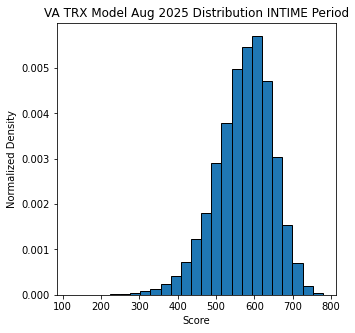

In [106]:
df = training_data.query(f"{date_column} >= @intime_start and {date_column} < @intime_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]

title = model_name_ov + ' Distribution INTIME Period'
scoring = score_name
plot_score_disb(df[scoring], figsize = [5,5], title = title, save_as = 'score_disb_intime.png')

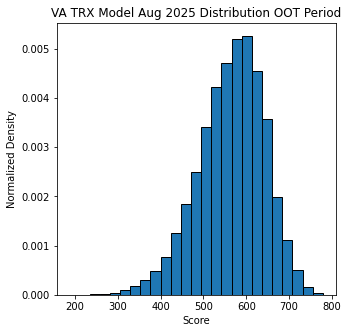

In [107]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]

title = model_name_ov + ' Distribution OOT Period'
scoring = score_name
plot_score_disb(df[scoring], figsize = [5,5], title = title, save_as = 'score_disb_oot.png')

## ROC CURVE

In [108]:
import gc
gc.collect()

9072

In [109]:
df['flag'].isna().sum()

0

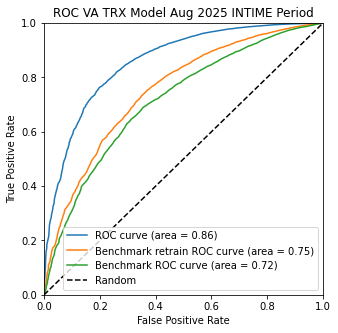

In [110]:
# INTIME
df = training_data.query(f"{date_column} >= @intime_start and {date_column} < @intime_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]
df = df[pd.notnull(df['flag'])]
title = 'ROC ' + model_name_ov + ' INTIME Period'
[auc_intime, auc_intime_b, auc_intime_c] = plot_roc(df['flag'], df[score_name], df[score_name_old], df['trx_score_log'], figsize = [5,5], title = title, save_as = 'roc_intime.png')

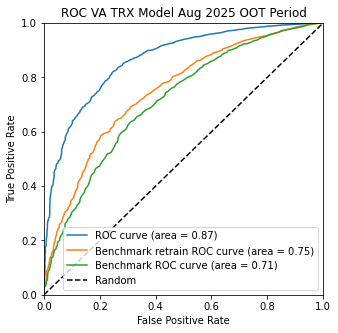

In [111]:
# OOT
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]
title = 'ROC ' + model_name_ov + ' OOT Period'
[auc_oot, auc_oot_b, auc_oot_c] = plot_roc(df['flag'], df[score_name], y_comp1 = df[score_name_old], y_comp2=df['trx_score_log'], figsize = [5,5], title = title, save_as = 'roc_oot.png')

## LIFT10

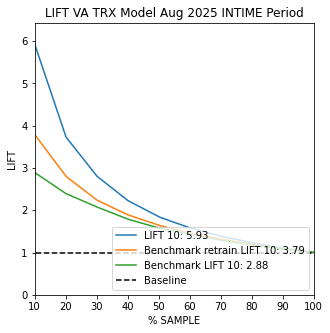

In [112]:
df = training_data.query(f"{date_column} >= @intime_start and {date_column} < @intime_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]

title = 'LIFT ' + model_name_ov + ' INTIME Period'
[lift10_intime, lift10_intime_b, lift10_intime_c] = plot_lift(df, score_name, score_name_old, "trx_score_log", figsize = [5,5], title = title, save_as = 'lift_intime.png')

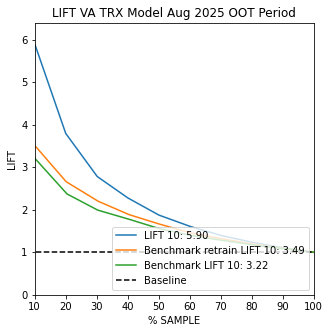

In [113]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]

title = 'LIFT ' + model_name_ov + ' OOT Period'
[lift10_oot, lift10_oot_b, lift10_oot_c] = plot_lift(df, score_name, score_name_old, "trx_score_log", figsize = [5,5], title = title, save_as = 'lift_oot.png')

## MODEL SUMMARY

In [224]:
model_summ = pd.DataFrame(data = {'training_segment': ['intime', 'oot'], 'NEW MODEL': [auc_intime, auc_oot], 'BENCHMARK RETRAIN': [auc_intime_b, auc_oot_b],'BENCHMARK': [auc_intime_c, auc_oot_c], 'LIFT10 NEW MODEL': [lift10_intime, lift10_oot], 'LIFT10 BENCHMARK RETRAIN': [lift10_intime_b, lift10_oot_b], 'LIFT10 BENCHMARK': [lift10_intime_c, lift10_oot_c]})
model_summ = model_summ.set_index('training_segment').round(3)
model_summ

,NEW MODEL,BENCHMARK RETRAIN,BENCHMARK,LIFT10 NEW MODEL,LIFT10 BENCHMARK RETRAIN,LIFT10 BENCHMARK
training_segment,,,,,,
intime,0.859,0.752,0.715,5.927,3.788,2.880
oot,0.867,0.749,0.715,5.895,3.490,3.216


## AUC COMPARISON

In [225]:
df = training_data.query("business_segment.isin(@business_segment_eval)")
df = df[pd.notnull(df['trx_score_log'])]
df = df[pd.notnull(df['flag'])]

### TRAINING RESULT

In [226]:
train_result = model_sc.evaluation
train_result['sample_cnt'] = train_result['gte_330'] + train_result['lt_330']
train_result['data_period'] = train_result['start_date'].dt.strftime('%Y/%m/%d') + ' - ' + train_result['end_date'].dt.strftime('%Y/%m/%d')
train_result = train_result[['data_period', 'sample_cnt', 'AUC', 'CROSS VALIDATION']]
train_result['AUC'] = train_result['AUC'].round(3)
train_result['CROSS VALIDATION'] = [round(train_result['CROSS VALIDATION'][0], 3), '']
train_result

,data_period,sample_cnt,AUC,CROSS VALIDATION
intime,2024/02/01 - 2025/03/01,250276,0.859,0.857
oot,2025/03/01 - 2025/06/01,65781,0.869,


### BUSINESS SEGMENT

In [227]:
auc_benchmark_retrain_pivot = df.groupby(['training_segment', 'data_period', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name_old]), 3)).to_frame().reset_index()
auc_benchmark_retrain_pivot = auc_benchmark_retrain_pivot.pivot_table(index = ['training_segment', 'data_period'], columns = 'business_segment', values = 0)
display(auc_benchmark_retrain_pivot)
gini_benchmark_retrain_pivot = auc_benchmark_retrain_pivot*2-1
display(gini_benchmark_retrain_pivot)

,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.747,0.750,0.697
oot,2025/03/01 - 2025/06/01,0.706,0.755,0.740


,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.494,0.50,0.394
oot,2025/03/01 - 2025/06/01,0.412,0.51,0.480


In [228]:
auc_benchmark_pivot = df.groupby(['training_segment', 'data_period', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x["trx_score_log"]), 3)).to_frame().reset_index()
auc_benchmark_pivot = auc_benchmark_pivot.pivot_table(index = ['training_segment', 'data_period'], columns = 'business_segment', values = 0)
display(auc_benchmark_pivot)
gini_benchmark_pivot = auc_benchmark_pivot*2-1
display(gini_benchmark_pivot)

,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.710,0.693,0.669
oot,2025/03/01 - 2025/06/01,0.648,0.728,0.657


,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.420,0.386,0.338
oot,2025/03/01 - 2025/06/01,0.296,0.456,0.314


In [229]:
auc_new_model_pivot = df.groupby(['training_segment', 'data_period', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name]), 3)).to_frame().reset_index()
auc_new_model_pivot = auc_new_model_pivot.pivot_table(index = ['training_segment', 'data_period'], columns = 'business_segment', values = 0)
display(auc_new_model_pivot)
gini_benchmark_pivot = auc_new_model_pivot*2-1
display(gini_benchmark_pivot)

,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.846,0.866,0.858
oot,2025/03/01 - 2025/06/01,0.845,0.870,0.852


,business_segment,CREDIT_LIMIT_INDODANA,CREDIT_LIMIT_OFFLINE,SECONDARY_CREDIT_LIMIT_INDODANA
training_segment,data_period,,,
intime,2024/02/01 - 2025/03/01,0.692,0.732,0.716
oot,2025/03/01 - 2025/06/01,0.690,0.740,0.704


### M2M

In [121]:
import gc
gc.collect()

13692

In [122]:
def calculate_auc(group):
    try:
        return round(1 - roc_auc_score(group['flag'], group[score_name]), 3)
    except ValueError as e:
        print(f"Error in group: {group['trx_approved_date_month'].iloc[0]}, {group['business_segment'].iloc[0]}")
        print(f"Error message: {e}")
        return float('nan')

auc_m2m_pivot = training_data.groupby(['trx_approved_date_month']).apply(calculate_auc).to_frame().reset_index()

In [123]:
auc_m2m_pivot

,trx_approved_date_month,0
0,2024-02,0.844
1,2024-03,0.805
2,2024-04,0.848
3,2024-05,0.809
4,2024-06,0.875
5,2024-07,0.879
6,2024-08,0.847
7,2024-09,0.862
8,2024-10,0.869
9,2024-11,0.882


In [124]:
auc_m2m_pivot = df.groupby(['trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name]), 3)).to_frame().reset_index()
auc_m2m_pivot = auc_m2m_pivot.pivot_table(index = ['trx_approved_date_month'], values = 0)

auc_m2m_benchmark_retrain_pivot = df.groupby(['trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name_old]), 3)).to_frame().reset_index()
auc_m2m_benchmark_retrain_pivot = auc_m2m_benchmark_retrain_pivot.pivot_table(index = ['trx_approved_date_month'], values = 0)

auc_m2m_benchmark_pivot = df.groupby(['trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x["trx_score_log"]), 3)).to_frame().reset_index()
auc_m2m_benchmark_pivot = auc_m2m_benchmark_pivot.pivot_table(index = ['trx_approved_date_month'], values = 0)

auc_m2m_final = pd.concat([auc_m2m_pivot, auc_m2m_benchmark_retrain_pivot, auc_m2m_benchmark_pivot], axis = 1)#, keys = ["new", "benchmark"])
auc_m2m_final.columns = ["New", "Retrain old", "Current"]
display(auc_m2m_final)

,New,Retrain old,Current
trx_approved_date_month,,,
2024-02,0.843,0.743,0.700
2024-03,0.814,0.718,0.743
2024-04,0.847,0.760,0.751
2024-05,0.805,0.723,0.685
2024-06,0.882,0.778,0.732
2024-07,0.879,0.731,0.664
2024-08,0.844,0.678,0.654
2024-09,0.860,0.739,0.708
2024-10,0.869,0.787,0.743


In [126]:
# auc_m2m_pivot = df[df['trx_approved_date_month'] != '2025-02'].groupby(['trx_approved_date_month', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name]), 3)).to_frame().reset_index()
# auc_m2m_pivot = auc_m2m_pivot.pivot_table(index = ['trx_approved_date_month'], columns = 'business_segment', values = 0)

# auc_m2m_benchmark_retrain_pivot = df[df['trx_approved_date_month'] != '2025-02'].groupby(['trx_approved_date_month', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name_old]), 3)).to_frame().reset_index()
# auc_m2m_benchmark_retrain_pivot = auc_m2m_benchmark_retrain_pivot.pivot_table(index = ['trx_approved_date_month'], columns = 'business_segment', values = 0)

# auc_m2m_benchmark_pivot = df[df['trx_approved_date_month'] != '2025-02'].groupby(['trx_approved_date_month', 'business_segment']).apply(lambda x: round(1-roc_auc_score(x['flag'], x["trx_score_log"]), 3)).to_frame().reset_index()
# auc_m2m_benchmark_pivot = auc_m2m_benchmark_pivot.pivot_table(index = ['trx_approved_date_month'], columns = 'business_segment', values = 0)

# auc_m2m_final = pd.concat([auc_m2m_pivot, auc_m2m_benchmark_retrain_pivot, auc_m2m_benchmark_pivot], axis = 1)#, keys = ["new", "benchmark"])
# display(auc_m2m_final)

### New & old users

In [127]:
df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

In [130]:
auc_pivot1 = df.groupby(['payment_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name]), 3)).to_frame().reset_index()
auc_pivot1 = auc_pivot1.pivot_table(index = ['payment_ctg','trx_approved_date_month'], values = 0)

auc_pivot1_retrain = df.groupby(['payment_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name_old]), 3)).to_frame().reset_index()
auc_pivot1_retrain = auc_pivot1_retrain.pivot_table(index = ['payment_ctg','trx_approved_date_month'], values = 0)

auc_pivot1_bechmark = df.groupby(['payment_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x["trx_score_log"]), 3)).to_frame().reset_index()
auc_pivot1_bechmark = auc_pivot1_bechmark.pivot_table(index = ['payment_ctg','trx_approved_date_month'], values = 0)

auc_pivot1_final = pd.concat([auc_pivot1, auc_pivot1_retrain, auc_pivot1_bechmark], axis = 1)#, keys = ["new", "benchmark"])
auc_pivot1_final.columns = ["New", "Retrain old", "Current"]
display(auc_pivot1_final)

New  Retrain old  Current
payment_ctg     trx_approved_date_month                             
1. No payment   2024-02                  0.593        0.766    0.546
                2024-03                  0.732        0.732    0.651
                2024-04                  0.853        0.876    0.800
                2024-05                  0.671        0.499    0.324
                2024-06                  0.788        0.498    0.457
                2024-07                  0.950        0.905    0.847
                2024-08                  0.882        0.745    0.620
                2024-09                  0.941        0.847    0.905
                2024-10                  0.809        0.749    0.596
                2024-11                  0.846        0.745    0.754
                2024-12                  0.617        0.711    0.545
                2025-01                  0.701        0.770    0.536
                2025-02                  0.693        0.701    0.586
                2025-03                  0.617        0.365    0.286
                2025-04                  0.863        0.770    0.596
                2025-05                  0.823        0.689    0.613
2. Have payment 2024-02                  0.843        0.741    0.698
                2024-03                  0.811        0.714    0.741
                2024-04                  0.847        0.756    0.748
                2024-05                  0.805        0.724    0.687
                2024-06                  0.883        0.782    0.737
                2024-07                  0.877        0.724    0.655
                2024-08                  0.844        0.676    0.652
                2024-09                  0.858        0.733    0.698
                2024-10                  0.864        0.781    0.738
                2024-11                  0.882        0.760    0.739
                2024-12                  0.862        0.760    0.711
                2025-01                  0.848        0.759    0.681
                2025-02                  0.862        0.739    0.690
                2025-03                  0.874        0.756    0.761
                2025-04                  0.874        0.776    0.714
                2025-05                  0.861        0.737    0.687

### High & low amount

In [131]:
df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

In [132]:
auc_pivot2 = df.groupby(['amount_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name]), 3)).to_frame().reset_index()
auc_pivot2 = auc_pivot2.pivot_table(index = ['amount_ctg','trx_approved_date_month'], values = 0)

auc_pivot2_retrain = df.groupby(['amount_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x[score_name_old]), 3)).to_frame().reset_index()
auc_pivot2_retrain = auc_pivot2_retrain.pivot_table(index = ['amount_ctg','trx_approved_date_month'], values = 0)

auc_pivot2_bechmark = df.groupby(['amount_ctg','trx_approved_date_month']).apply(lambda x: round(1-roc_auc_score(x['flag'], x["trx_score_log"]), 3)).to_frame().reset_index()
auc_pivot2_bechmark = auc_pivot2_bechmark.pivot_table(index = ['amount_ctg','trx_approved_date_month'], values = 0)

auc_pivot2_final = pd.concat([auc_pivot2, auc_pivot2_retrain, auc_pivot2_bechmark], axis = 1)#, keys = ["new", "benchmark"])
auc_pivot2_final.columns = ["New", "Retrain old", "Current"]
display(auc_pivot2_final)

New  Retrain old  Current
amount_ctg trx_approved_date_month                             
1. <= 1mio 2024-02                  0.817        0.701    0.689
           2024-03                  0.761        0.666    0.707
           2024-04                  0.754        0.672    0.705
           2024-05                  0.808        0.744    0.712
           2024-06                  0.887        0.788    0.750
           2024-07                  0.895        0.689    0.621
           2024-08                  0.837        0.636    0.614
           2024-09                  0.850        0.735    0.700
           2024-10                  0.852        0.771    0.753
           2024-11                  0.878        0.727    0.729
           2024-12                  0.847        0.743    0.694
           2025-01                  0.839        0.777    0.685
           2025-02                  0.861        0.733    0.690
           2025-03                  0.892        0.741    0.799
           2025-04                  0.877        0.760    0.697
           2025-05                  0.845        0.721    0.664
2. > 1mio  2024-02                  0.829        0.729    0.663
           2024-03                  0.827        0.703    0.729
           2024-04                  0.855        0.721    0.704
           2024-05                  0.753        0.634    0.598
           2024-06                  0.843        0.703    0.652
           2024-07                  0.808        0.724    0.661
           2024-08                  0.833        0.700    0.669
           2024-09                  0.854        0.705    0.677
           2024-10                  0.838        0.721    0.679
           2024-11                  0.858        0.743    0.719
           2024-12                  0.834        0.703    0.677
           2025-01                  0.822        0.682    0.637
           2025-02                  0.824        0.690    0.653
           2025-03                  0.812        0.683    0.642
           2025-04                  0.827        0.738    0.687
           2025-05                  0.842        0.693    0.678

## RESULT TABLES

### 10% BINS

In [133]:
even_bins_10 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perc_10 = []
for i in range(len(even_bins_10) - 1):
    perc_10.append(str(even_bins_10[i]) + ' - ' + str(even_bins_10[i+1]))

In [134]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_gladys_new_bin,,,,
"(0.0, 462.0]",6516,9.87%,"22,696,733,782.65",11.02%
"(462.0, 501.0]",6434,2.80%,"15,134,812,079.00",3.82%
"(501.0, 529.0]",6567,1.31%,"11,282,176,129.60",2.72%
"(529.0, 551.0]",6409,1.23%,"8,406,509,848.30",2.29%
"(551.0, 571.0]",6443,0.43%,"7,129,138,789.15",1.24%
"(571.0, 591.0]",6649,0.47%,"6,332,251,160.85",0.30%
"(591.0, 610.0]",6454,0.19%,"5,049,150,276.55",0.10%
"(610.0, 630.0]",6238,0.21%,"4,080,800,177.70",0.36%
"(630.0, 658.0]",6674,0.09%,"3,618,692,470.60",0.34%


In [135]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_old_retrain_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_10, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_old_retrain_bin,,,,
"(0.0, 457.0]",6676,5.84%,"18,959,684,058.35",7.85%
"(457.0, 481.0]",6373,3.00%,"15,317,986,063.95",5.48%
"(481.0, 502.0]",6652,2.18%,"12,252,166,695.10",5.19%
"(502.0, 519.0]",6467,1.55%,"9,443,529,037.15",3.08%
"(519.0, 532.0]",6276,1.24%,"7,874,092,539.05",1.38%
"(532.0, 547.0]",6641,0.71%,"6,775,829,641.50",2.87%
"(547.0, 561.0]",6348,0.82%,"5,071,813,885.30",1.68%
"(561.0, 576.0]",6592,0.53%,"4,444,349,688.30",0.59%
"(576.0, 592.0]",6146,0.44%,"3,450,390,668.20",1.20%


In [136]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_old_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_log_bin,,,,
"(0.0, 461.0]",6484,5.38%,"10,310,737,089.45",7.10%
"(461.0, 491.0]",6732,2.61%,"11,822,945,099.55",6.36%
"(491.0, 510.0]",6385,2.02%,"12,590,542,216.95",5.36%
"(510.0, 526.0]",6769,1.88%,"11,357,998,929.50",4.53%
"(526.0, 539.0]",5991,1.07%,"8,931,652,093.70",4.58%
"(539.0, 552.0]",6646,1.01%,"8,677,199,694.70",2.25%
"(552.0, 564.0]",6275,1.00%,"7,161,187,751.50",3.74%
"(564.0, 581.0]",6616,0.71%,"6,557,507,360.50",1.20%
"(581.0, 600.0]",6285,0.59%,"4,936,119,592.00",1.28%


In [137]:
percentile_oot_new_10['percentile'] = perc_10
percentile_oot_new_10 = percentile_oot_new_10.set_index('percentile')
percentile_oot_old_retrain_10['percentile'] = perc_10
percentile_oot_old_retrain_10 = percentile_oot_old_retrain_10.set_index('percentile')
percentile_oot_old_10['percentile'] = perc_10
percentile_oot_old_10 = percentile_oot_old_10.set_index('percentile')

### 10% BINS - New & old users

In [145]:
even_bins_10 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perc_10 = []
for i in range(len(even_bins_10) - 1):
    perc_10.append(str(even_bins_10[i]) + ' - ' + str(even_bins_10[i+1]))

In [146]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10_1 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

In [147]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ['trx_score_log']

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot__10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

In [148]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

### 10% BINS - Low & high amount

In [145]:
even_bins_10 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perc_10 = []
for i in range(len(even_bins_10) - 1):
    perc_10.append(str(even_bins_10[i]) + ' - ' + str(even_bins_10[i+1]))

In [149]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

In [150]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ['trx_score_log']

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

In [151]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
percentile_oot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values).reset_index()

### 5% BINS

In [78]:
even_bins_5 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
perc_5 = []
for i in range(len(even_bins_5) - 1):
    perc_5.append(str(even_bins_5[i]) + ' - ' + str(even_bins_5[i+1]))

In [152]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_new_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_gladys_new_bin,,,,
"(0.0, 428.0]",3269,14.04%,"12,442,313,206.90",14.27%
"(428.0, 462.0]",3247,5.67%,"10,254,420,575.75",7.08%
"(462.0, 484.0]",3210,3.61%,"8,159,397,248.15",4.38%
"(484.0, 501.0]",3224,1.99%,"6,975,414,830.85",3.16%
"(501.0, 516.0]",3273,1.25%,"6,299,512,208.95",2.40%
"(516.0, 529.0]",3294,1.37%,"4,982,663,920.65",3.11%
"(529.0, 541.0]",3366,1.43%,"4,655,358,576.05",2.22%
"(541.0, 551.0]",3043,1.02%,"3,751,151,272.25",2.39%
"(551.0, 561.0]",3228,0.53%,"3,517,958,570.35",1.31%


In [153]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_old_retrain_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_old_retrain_bin,,,,
"(0.0, 437.0]",3339,7.01%,"9,925,452,248.70",8.65%
"(437.0, 457.0]",3337,4.67%,"9,034,231,809.65",6.97%
"(457.0, 470.0]",3120,3.43%,"7,583,111,425.60",4.43%
"(470.0, 481.0]",3253,2.58%,"7,734,874,638.35",6.52%
"(481.0, 493.0]",3351,2.24%,"6,476,488,421.70",5.29%
"(493.0, 502.0]",3301,2.12%,"5,775,678,273.40",5.07%
"(502.0, 511.0]",3251,1.72%,"4,937,544,353.80",3.37%
"(511.0, 519.0]",3216,1.37%,"4,505,984,683.35",2.75%
"(519.0, 525.0]",3029,1.75%,"4,091,163,323.45",1.35%


In [154]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_old_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_log_bin,,,,
"(0.0, 436.0]",3332,6.63%,"5,256,151,765.95",8.65%
"(436.0, 461.0]",3152,4.06%,"5,054,585,323.50",5.48%
"(461.0, 478.0]",3335,2.88%,"5,538,611,858.70",5.46%
"(478.0, 491.0]",3397,2.36%,"6,284,333,240.85",7.15%
"(491.0, 501.0]",3049,2.30%,"6,370,964,919.15",6.63%
"(501.0, 510.0]",3336,1.77%,"6,219,577,297.80",4.05%
"(510.0, 518.0]",3340,2.16%,"5,901,987,220.95",4.30%
"(518.0, 526.0]",3429,1.60%,"5,456,011,708.55",4.78%
"(526.0, 533.0]",3055,0.85%,"4,594,190,257.65",4.57%


In [155]:
percentile_oot_new_5['percentile'] = perc_5
percentile_oot_new_5 = percentile_oot_new_5.set_index('percentile')
percentile_oot_old_retrain_5['percentile'] = perc_5
percentile_oot_old_retrain_5 = percentile_oot_old_retrain_5.set_index('percentile')
percentile_oot_old_5['percentile'] = perc_5
percentile_oot_old_5 = percentile_oot_old_5.set_index('percentile')

### 5% BINS - New & old users

In [156]:
even_bins_5 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
perc_5 = []
for i in range(len(even_bins_5) - 1):
    perc_5.append(str(even_bins_5[i]) + ' - ' + str(even_bins_5[i+1]))

In [157]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_new_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_gladys_new_bin,,,,
"(0.0, 428.0]",3269,14.04%,"12,442,313,206.90",14.27%
"(428.0, 462.0]",3247,5.67%,"10,254,420,575.75",7.08%
"(462.0, 484.0]",3210,3.61%,"8,159,397,248.15",4.38%
"(484.0, 501.0]",3224,1.99%,"6,975,414,830.85",3.16%
"(501.0, 516.0]",3273,1.25%,"6,299,512,208.95",2.40%
"(516.0, 529.0]",3294,1.37%,"4,982,663,920.65",3.11%
"(529.0, 541.0]",3366,1.43%,"4,655,358,576.05",2.22%
"(541.0, 551.0]",3043,1.02%,"3,751,151,272.25",2.39%
"(551.0, 561.0]",3228,0.53%,"3,517,958,570.35",1.31%


In [158]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_old_retrain_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_old_retrain_bin,,,,
"(0.0, 437.0]",3339,7.01%,"9,925,452,248.70",8.65%
"(437.0, 457.0]",3337,4.67%,"9,034,231,809.65",6.97%
"(457.0, 470.0]",3120,3.43%,"7,583,111,425.60",4.43%
"(470.0, 481.0]",3253,2.58%,"7,734,874,638.35",6.52%
"(481.0, 493.0]",3351,2.24%,"6,476,488,421.70",5.29%
"(493.0, 502.0]",3301,2.12%,"5,775,678,273.40",5.07%
"(502.0, 511.0]",3251,1.72%,"4,937,544,353.80",3.37%
"(511.0, 519.0]",3216,1.37%,"4,505,984,683.35",2.75%
"(519.0, 525.0]",3029,1.75%,"4,091,163,323.45",1.35%


In [159]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
percentile_oot_old_5 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values).reset_index()

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_log_bin,,,,
"(0.0, 436.0]",3332,6.63%,"5,256,151,765.95",8.65%
"(436.0, 461.0]",3152,4.06%,"5,054,585,323.50",5.48%
"(461.0, 478.0]",3335,2.88%,"5,538,611,858.70",5.46%
"(478.0, 491.0]",3397,2.36%,"6,284,333,240.85",7.15%
"(491.0, 501.0]",3049,2.30%,"6,370,964,919.15",6.63%
"(501.0, 510.0]",3336,1.77%,"6,219,577,297.80",4.05%
"(510.0, 518.0]",3340,2.16%,"5,901,987,220.95",4.30%
"(518.0, 526.0]",3429,1.60%,"5,456,011,708.55",4.78%
"(526.0, 533.0]",3055,0.85%,"4,594,190,257.65",4.57%


### STANDARD SCORES

In [264]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_new = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_gladys_new_bin,,,,
"(0.0, 390.0]",1365,19.71%,"5,523,838,550.55",20.30%
"(390.0, 400.0]",375,10.93%,"1,393,506,556.50",9.07%
"(400.0, 420.0]",1011,9.59%,"3,662,111,910.20",8.93%
"(420.0, 440.0]",1475,8.27%,"5,134,925,359.45",8.85%
"(440.0, 460.0]",2050,5.22%,"6,329,527,935.40",7.12%
"(460.0, 480.0]",2796,3.58%,"7,042,322,183.10",4.30%
"(480.0, inf]",55508,0.62%,"57,342,212,828.95",1.63%


In [265]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_old_retrain = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_old_retrain_bin,,,,
"(0.0, 390.0]",404,13.12%,"1,141,021,102.35",11.79%
"(390.0, 400.0]",279,8.24%,"815,907,662.55",6.72%
"(400.0, 420.0]",985,6.60%,"3,109,845,598.00",8.12%
"(420.0, 440.0]",2083,5.90%,"6,052,696,217.60",8.24%
"(440.0, 460.0]",3808,4.33%,"10,384,778,623.45",6.62%
"(460.0, 480.0]",5126,2.61%,"11,898,501,683.95",5.33%
"(480.0, inf]",51895,1.00%,"53,025,694,436.25",2.75%


In [266]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_old = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

,POPULATION,BADRATE_ACC,TOTAL,BADRATE
trx_score_log_bin,,,,
"(0.0, 390.0]",226,15.93%,"74,452,643.50",12.61%
"(390.0, 400.0]",418,7.18%,"740,404,214.65",10.40%
"(400.0, 420.0]",1239,7.26%,"2,104,974,863.75",9.21%
"(420.0, 440.0]",1874,4.59%,"3,061,214,450.70",6.28%
"(440.0, 460.0]",2578,4.00%,"4,112,208,890.75",6.22%
"(460.0, 480.0]",3990,2.98%,"6,713,121,482.70",5.88%
"(480.0, inf]",54255,1.14%,"69,622,068,778.10",3.73%


In [267]:
df = training_data.query(f"{date_column} >= @intime_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = []
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]
bins = [0, 320, 350, 370, 390, 400, 410, 420, 430, 450, 470, 490, 510, np.inf]

combined_disb = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values, show = False)
combined_disb['PERC DISB'] = (combined_disb['POPULATION']/combined_disb['POPULATION'].sum()*100).round(2).apply(str) + '%'
combined_disb = combined_disb[['POPULATION', 'PERC DISB', 'BADRATE']]
display(combined_disb)

,POPULATION,PERC DISB,BADRATE
trx_score_gladys_new_bin,,,
"(0.0, 320.0]",931,0.3%,36.70%
"(320.0, 350.0]",1187,0.38%,26.64%
"(350.0, 370.0]",1344,0.43%,19.84%
"(370.0, 390.0]",2064,0.67%,15.49%
"(390.0, 400.0]",1383,0.45%,12.14%
"(400.0, 410.0]",1774,0.57%,12.36%
"(410.0, 420.0]",2109,0.68%,9.15%
"(420.0, 430.0]",2571,0.83%,10.03%
"(430.0, 450.0]",6877,2.22%,6.99%


### STANDARD SCORES - New & old users

In [164]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_new = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

In [165]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_old_retrain = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

In [166]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['payment_ctg'] = 'Other'
df.loc[(df['sumTotalPayment']<=0), 'payment_ctg'] = '1. No payment'
df.loc[(df['sumTotalPayment']>0), 'payment_ctg'] = '2. Have payment'

index = ['payment_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

standard_oot_old = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

### STANDARD SCORES - Low & high amount

In [184]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]
bins = [
#     0, 390, 400, 420, 440, 460, 
    -np.inf, 480, np.inf]

standard_oot_new = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

In [183]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]
bins = [
#     0, 390, 400, 420, 440, 460, 
    -np.inf, 480, np.inf]

standard_oot_old_retrain = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

In [181]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

df['amount_ctg'] = 'Other'
df.loc[(df['transactionAmount']<=1000000), 'amount_ctg'] = '1. <= 1mio'
df.loc[(df['transactionAmount']>1000000), 'amount_ctg'] = '2. > 1mio'

index = ['amount_ctg']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]
bins = [
#     0, 390, 400, 420, 440, 460, 
    -np.inf, 480, np.inf]

standard_oot_old = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)

### PIVOT MONTHLY

In [185]:
df = training_data
df = df[pd.notnull(df['trx_score_log'])]

index = ['trx_approved_date_month']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]
bins = [0, 390, 400, 420, 440, 460, 480, np.inf]

monthly_pivot = pivot_badrate(df, index = index, scoring = scoring, bins = bins, acc_flag = acc_flag, values = values)
monthly_pivot = monthly_pivot.reset_index().set_index('trx_approved_date_month')

In [186]:
# percentile
df = training_data
df = df[pd.notnull(df['trx_score_log'])]

index = ['trx_approved_date_month']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

monthly_pivot_new_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values)
monthly_pivot_new_10 = monthly_pivot_new_10.reset_index().set_index('trx_approved_date_month')

In [187]:
# percentile
df = training_data
df = df[pd.notnull(df['trx_score_log'])]

index = ['trx_approved_date_month']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

monthly_pivot_old_retrain_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values)
monthly_pivot_old_retrain_10 = monthly_pivot_old_retrain_10.reset_index().set_index('trx_approved_date_month')

In [188]:
# percentile
df = training_data
df = df[pd.notnull(df['trx_score_log'])]

index = ['trx_approved_date_month']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

monthly_pivot_old_10 = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values)
monthly_pivot_old_10 = monthly_pivot_old_10.reset_index().set_index('trx_approved_date_month')

### BY EACH SEGMENT

In [322]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_new_10['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_new_10 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)


pivot_appended_new_10



Total Bad Rate per Score Bin (across all business segments):
                           Total_Population     Total_Bad    Total_Good  \
trx_score_gladys_new_bin                                                 
(0.0, 462.0]                          6516  2.501235e+09  2.019550e+10   
(462.0, 501.0]                        6434  5.781356e+08  1.455668e+10   
(501.0, 529.0]                        6567  3.065807e+08  1.097560e+10   
(529.0, 551.0]                        6409  1.928881e+08  8.213622e+09   
(551.0, 571.0]                        6443  8.834795e+07  7.040791e+09   
(571.0, 591.0]                        6649  1.903496e+07  6.313216e+09   
(591.0, 610.0]                        6454  5.163988e+06  5.043986e+09   
(610.0, 630.0]                        6238  1.484787e+07  4.065952e+09   
(630.0, 658.0]                        6674  1.223305e+07  3.606459e+09   
(658.0, inf]                          6196  7.413280e+05  2.697439e+09   

                                 Total  Overall_

ValueError: Length of values (20) does not match length of index (10)

In [323]:
even_bins_10 = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
perc_10 = []
for i in range(len(even_bins_10) - 1):
    perc_10.append(str(even_bins_10[i]) + ' - ' + str(even_bins_10[i+1]))

In [324]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]


bins_retrain_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

#pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name_old + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_retrain_10['BADRATE_ACC'])

print(total_badrate_to_append['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_retrain_10 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_retrain_10


Total Bad Rate per Score Bin (across all business segments):
                            Total_Population     Total_Bad    Total_Good  \
trx_score_old_retrain_bin                                                 
(0.0, 457.0]                           6676  1.488531e+09  1.747115e+10   
(457.0, 481.0]                         6373  8.399758e+08  1.447801e+10   
(481.0, 502.0]                         6652  6.357624e+08  1.161640e+10   
(502.0, 519.0]                         6467  2.904323e+08  9.153097e+09   
(519.0, 532.0]                         6276  1.085317e+08  7.765561e+09   
(532.0, 547.0]                         6641  1.945793e+08  6.581250e+09   
(547.0, 561.0]                         6348  8.506122e+07  4.986753e+09   
(561.0, 576.0]                         6592  2.640082e+07  4.417949e+09   
(576.0, 592.0]                         6146  4.141511e+07  3.408976e+09   
(592.0, inf]                           6409  8.518765e+06  2.830084e+09   

                                  To

,business_segment,trx_score_old_retrain_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,CREDIT_LIMIT_INDODANA,"(0.0, 457.0]",2536,4.38%,"6,329,926,090.35",8.01%
1,CREDIT_LIMIT_INDODANA,"(457.0, 481.0]",3109,2.12%,"6,848,316,834.70",5.03%
2,CREDIT_LIMIT_INDODANA,"(481.0, 502.0]",3076,1.37%,"5,378,769,123.40",4.53%
3,CREDIT_LIMIT_INDODANA,"(502.0, 519.0]",3125,1.22%,"4,559,508,950.85",3.34%
4,CREDIT_LIMIT_INDODANA,"(519.0, 532.0]",3053,0.85%,"3,756,687,203.45",0.57%
5,CREDIT_LIMIT_INDODANA,"(532.0, 547.0]",3418,0.61%,"3,366,910,916.85",2.47%
6,CREDIT_LIMIT_INDODANA,"(547.0, 561.0]",3006,0.96%,"2,299,132,254.50",1.34%
7,CREDIT_LIMIT_INDODANA,"(561.0, 576.0]",3633,0.74%,"2,528,909,031.35",0.52%
8,CREDIT_LIMIT_INDODANA,"(576.0, 592.0]",3371,0.50%,"1,729,598,689.65",1.25%
9,CREDIT_LIMIT_INDODANA,"(592.0, inf]",4009,0.22%,"1,690,250,670.90",0.12%


In [325]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby("trx_score_log" + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_10['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_old_10 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_old_10



Total Bad Rate per Score Bin (across all business segments):
                    Total_Population    Total_Bad    Total_Good         Total  \
trx_score_log_bin                                                              
(0.0, 461.0]                   6484  731669868.8  9.579067e+09  1.031074e+10   
(461.0, 491.0]                 6732  751726027.0  1.107122e+10  1.182295e+10   
(491.0, 510.0]                 6385  674385674.0  1.191616e+10  1.259054e+10   
(510.0, 526.0]                 6769  514705190.5  1.084329e+10  1.135800e+10   
(526.0, 539.0]                 5991  409218650.0  8.522433e+09  8.931652e+09   
(539.0, 552.0]                 6646  195606038.0  8.481594e+09  8.677200e+09   
(552.0, 564.0]                 6275  267508165.0  6.893680e+09  7.161188e+09   
(564.0, 581.0]                 6616   78989515.0  6.478518e+09  6.557507e+09   
(581.0, 600.0]                 6285   63152972.0  4.872967e+09  4.936120e+09   
(600.0, inf]                   6397   32246590.0  4.05030

,business_segment,trx_score_log_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,CREDIT_LIMIT_INDODANA,"(0.0, 461.0]",1400,2.43%,"2,004,924,978.45",5.31%
1,CREDIT_LIMIT_INDODANA,"(461.0, 491.0]",2512,2.67%,"4,260,231,625.90",7.00%
2,CREDIT_LIMIT_INDODANA,"(491.0, 510.0]",2990,1.87%,"5,181,435,430.95",5.03%
3,CREDIT_LIMIT_INDODANA,"(510.0, 526.0]",3362,1.43%,"4,981,795,040.95",3.99%
4,CREDIT_LIMIT_INDODANA,"(526.0, 539.0]",3227,0.90%,"4,487,658,264.40",4.35%
5,CREDIT_LIMIT_INDODANA,"(539.0, 552.0]",3525,0.82%,"4,337,760,018.40",1.40%
6,CREDIT_LIMIT_INDODANA,"(552.0, 564.0]",3533,1.47%,"4,014,618,859.15",5.10%
7,CREDIT_LIMIT_INDODANA,"(564.0, 581.0]",3820,1.02%,"3,816,736,287.05",1.19%
8,CREDIT_LIMIT_INDODANA,"(581.0, 600.0]",3693,0.49%,"2,894,572,537.85",1.55%
9,CREDIT_LIMIT_INDODANA,"(600.0, inf]",4274,0.33%,"2,508,276,722.90",0.18%


In [326]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_new_5['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_new_5 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_new_5



Total Bad Rate per Score Bin (across all business segments):
                           Total_Population     Total_Bad    Total_Good  \
trx_score_gladys_new_bin                                                 
(0.0, 428.0]                          3269  1.775056e+09  1.066726e+10   
(428.0, 462.0]                        3247  7.261793e+08  9.528241e+09   
(462.0, 484.0]                        3210  3.574209e+08  7.801976e+09   
(484.0, 501.0]                        3224  2.207147e+08  6.754700e+09   
(501.0, 516.0]                        3273  1.514001e+08  6.148112e+09   
(516.0, 529.0]                        3294  1.551806e+08  4.827483e+09   
(529.0, 541.0]                        3366  1.033827e+08  4.551976e+09   
(541.0, 551.0]                        3043  8.950538e+07  3.661646e+09   
(551.0, 561.0]                        3228  4.608296e+07  3.471876e+09   
(561.0, 571.0]                        3215  4.226498e+07  3.568915e+09   
(571.0, 581.0]                        3323  1.574

,business_segment,trx_score_gladys_new_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,CREDIT_LIMIT_INDODANA,"(0.0, 428.0]",1003,10.37%,"3,433,514,323.65",11.42%
1,CREDIT_LIMIT_INDODANA,"(428.0, 462.0]",1191,5.21%,"3,481,904,872.45",7.87%
2,CREDIT_LIMIT_INDODANA,"(462.0, 484.0]",1216,3.21%,"3,223,971,954.65",5.85%
3,CREDIT_LIMIT_INDODANA,"(484.0, 501.0]",1255,2.55%,"2,742,105,519.60",4.20%
4,CREDIT_LIMIT_INDODANA,"(501.0, 516.0]",1352,1.78%,"2,894,003,215.55",3.73%
...,...,...,...,...,...,...
75,Overall,"(620.0, 630.0]",3003,0.13%,1890037946.45,0.06%
76,Overall,"(630.0, 642.0]",3232,0.12%,1754925981.25,0.32%
77,Overall,"(642.0, 658.0]",3442,0.06%,1863766489.35,0.36%
78,Overall,"(658.0, 680.0]",3000,0.03%,1460889957.95,0.00%


In [327]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)

pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name_old + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_retrain_5['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_retrain_5 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_retrain_5


Total Bad Rate per Score Bin (across all business segments):
                            Total_Population    Total_Bad    Total_Good  \
trx_score_old_retrain_bin                                                
(0.0, 437.0]                           3339  858482742.0  9.066970e+09   
(437.0, 457.0]                         3337  630048636.0  8.404183e+09   
(457.0, 470.0]                         3120  335806990.6  7.247304e+09   
(470.0, 481.0]                         3253  504168773.0  7.230706e+09   
(481.0, 493.0]                         3351  342896229.0  6.133592e+09   
(493.0, 502.0]                         3301  292866166.2  5.482812e+09   
(502.0, 511.0]                         3251  166528709.0  4.771016e+09   
(511.0, 519.0]                         3216  123903559.0  4.382081e+09   
(519.0, 525.0]                         3029   55252983.5  4.035910e+09   
(525.0, 532.0]                         3247   53278682.0  3.729651e+09   
(532.0, 541.0]                         3409  1273

,business_segment,trx_score_old_retrain_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,CREDIT_LIMIT_INDODANA,"(0.0, 437.0]",1060,4.72%,"2,915,109,397.40",8.06%
1,CREDIT_LIMIT_INDODANA,"(437.0, 457.0]",1476,4.13%,"3,414,816,692.95",7.98%
2,CREDIT_LIMIT_INDODANA,"(457.0, 470.0]",1483,2.02%,"3,263,019,525.70",4.02%
3,CREDIT_LIMIT_INDODANA,"(470.0, 481.0]",1626,2.21%,"3,585,297,309.00",5.95%
4,CREDIT_LIMIT_INDODANA,"(481.0, 493.0]",1439,1.25%,"2,599,065,302.25",4.50%
...,...,...,...,...,...,...
75,Overall,"(568.0, 576.0]",3219,0.47%,1838647260.8,0.92%
76,Overall,"(576.0, 582.0]",3068,0.46%,1766190855.65,1.55%
77,Overall,"(582.0, 592.0]",3078,0.42%,1684199812.55,0.84%
78,Overall,"(592.0, 603.0]",3581,0.25%,1602053461.05,0.46%


In [328]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['business_segment'] 
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby("trx_score_log"+ '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all business segments):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['business_segment'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_5['BADRATE_ACC'])

pivot_output = pivot_output[['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['business_segment', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_old_5 = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_old_5


Total Bad Rate per Score Bin (across all business segments):
                    Total_Population    Total_Bad    Total_Good         Total  \
trx_score_log_bin                                                              
(0.0, 436.0]                   3332  454722790.0  4.801429e+09  5.256152e+09   
(436.0, 461.0]                 3152  276947078.8  4.777638e+09  5.054585e+09   
(461.0, 478.0]                 3335  302565303.0  5.236047e+09  5.538612e+09   
(478.0, 491.0]                 3397  449160724.0  5.835173e+09  6.284333e+09   
(491.0, 501.0]                 3049  422307733.0  5.948657e+09  6.370965e+09   
(501.0, 510.0]                 3336  252077941.0  5.967499e+09  6.219577e+09   
(510.0, 518.0]                 3340  253645666.5  5.648342e+09  5.901987e+09   
(518.0, 526.0]                 3429  261059524.0  5.194952e+09  5.456012e+09   
(526.0, 533.0]                 3055  209905209.0  4.384285e+09  4.594190e+09   
(533.0, 539.0]                 2936  199313441.0  4.13814

,business_segment,trx_score_log_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,CREDIT_LIMIT_INDODANA,"(0.0, 436.0]",550,2.00%,"732,670,936.80",3.12%
1,CREDIT_LIMIT_INDODANA,"(436.0, 461.0]",850,2.71%,"1,272,254,041.65",6.57%
2,CREDIT_LIMIT_INDODANA,"(461.0, 478.0]",1169,2.74%,"1,934,878,367.05",5.92%
3,CREDIT_LIMIT_INDODANA,"(478.0, 491.0]",1343,2.61%,"2,325,353,258.85",7.90%
4,CREDIT_LIMIT_INDODANA,"(491.0, 501.0]",1343,2.01%,"2,460,508,849.65",6.06%
...,...,...,...,...,...,...
75,Overall,"(572.0, 581.0]",3237,0.68%,2835034433.3,0.69%
76,Overall,"(581.0, 590.0]",3180,0.72%,2675556040.45,1.50%
77,Overall,"(590.0, 600.0]",3105,0.45%,2260563551.55,1.02%
78,Overall,"(600.0, 615.0]",3249,0.37%,2161430564.95,1.26%


### BY MERCHANT

In [329]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2'] # Include business segment in the index
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_new_10['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_new_10_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_new_10_mc



Total Bad Rate per Score Bin (across all merchant_name_2):
                           Total_Population     Total_Bad    Total_Good  \
trx_score_gladys_new_bin                                                 
(0.0, 462.0]                          6516  2.501235e+09  2.019550e+10   
(462.0, 501.0]                        6434  5.781356e+08  1.455668e+10   
(501.0, 529.0]                        6567  3.065807e+08  1.097560e+10   
(529.0, 551.0]                        6409  1.928881e+08  8.213622e+09   
(551.0, 571.0]                        6443  8.834795e+07  7.040791e+09   
(571.0, 591.0]                        6649  1.903496e+07  6.313216e+09   
(591.0, 610.0]                        6454  5.163988e+06  5.043986e+09   
(610.0, 630.0]                        6238  1.484787e+07  4.065952e+09   
(630.0, 658.0]                        6674  1.223305e+07  3.606459e+09   
(658.0, inf]                          6196  7.413280e+05  2.697439e+09   

                                 Total  Overall_BA

ValueError: Length of values (20) does not match length of index (10)

In [330]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)

pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name_old + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_retrain_10['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_retrain_10_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_retrain_10_mc


Total Bad Rate per Score Bin (across all merchant_name_2):
                            Total_Population     Total_Bad    Total_Good  \
trx_score_old_retrain_bin                                                 
(0.0, 457.0]                           6676  1.488531e+09  1.747115e+10   
(457.0, 481.0]                         6373  8.399758e+08  1.447801e+10   
(481.0, 502.0]                         6652  6.357624e+08  1.161640e+10   
(502.0, 519.0]                         6467  2.904323e+08  9.153097e+09   
(519.0, 532.0]                         6276  1.085317e+08  7.765561e+09   
(532.0, 547.0]                         6641  1.945793e+08  6.581250e+09   
(547.0, 561.0]                         6348  8.506122e+07  4.986753e+09   
(561.0, 576.0]                         6592  2.640082e+07  4.417949e+09   
(576.0, 592.0]                         6146  4.141511e+07  3.408976e+09   
(592.0, inf]                           6409  8.518765e+06  2.830084e+09   

                                  Tota

,merchant_name_2,trx_score_old_retrain_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,VA,"(0.0, 457.0]",6676,5.84%,"18,959,684,058.35",7.85%
1,VA,"(457.0, 481.0]",6373,3.00%,"15,317,986,063.95",5.48%
2,VA,"(481.0, 502.0]",6652,2.18%,"12,252,166,695.10",5.19%
3,VA,"(502.0, 519.0]",6467,1.55%,"9,443,529,037.15",3.08%
4,VA,"(519.0, 532.0]",6276,1.24%,"7,874,092,539.05",1.38%
5,VA,"(532.0, 547.0]",6641,0.71%,"6,775,829,641.50",2.87%
6,VA,"(547.0, 561.0]",6348,0.82%,"5,071,813,885.30",1.68%
7,VA,"(561.0, 576.0]",6592,0.53%,"4,444,349,688.30",0.59%
8,VA,"(576.0, 592.0]",6146,0.44%,"3,450,390,668.20",1.20%
9,VA,"(592.0, inf]",6409,0.25%,"2,838,603,047.25",0.30%


In [331]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_10 = score_percentile(df, even_by = scoring, even_bins = even_bins_10)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_10, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby("trx_score_log" + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_10['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', "trx_score_log" + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_old_10_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_old_10_mc



Total Bad Rate per Score Bin (across all merchant_name_2):
                    Total_Population    Total_Bad    Total_Good         Total  \
trx_score_log_bin                                                              
(0.0, 461.0]                   6484  731669868.8  9.579067e+09  1.031074e+10   
(461.0, 491.0]                 6732  751726027.0  1.107122e+10  1.182295e+10   
(491.0, 510.0]                 6385  674385674.0  1.191616e+10  1.259054e+10   
(510.0, 526.0]                 6769  514705190.5  1.084329e+10  1.135800e+10   
(526.0, 539.0]                 5991  409218650.0  8.522433e+09  8.931652e+09   
(539.0, 552.0]                 6646  195606038.0  8.481594e+09  8.677200e+09   
(552.0, 564.0]                 6275  267508165.0  6.893680e+09  7.161188e+09   
(564.0, 581.0]                 6616   78989515.0  6.478518e+09  6.557507e+09   
(581.0, 600.0]                 6285   63152972.0  4.872967e+09  4.936120e+09   
(600.0, inf]                   6397   32246590.0  4.050309e

,merchant_name_2,trx_score_log_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,VA,"(0.0, 461.0]",6484,5.38%,"10,310,737,089.45",7.10%
1,VA,"(461.0, 491.0]",6732,2.61%,"11,822,945,099.55",6.36%
2,VA,"(491.0, 510.0]",6385,2.02%,"12,590,542,216.95",5.36%
3,VA,"(510.0, 526.0]",6769,1.88%,"11,357,998,929.50",4.53%
4,VA,"(526.0, 539.0]",5991,1.07%,"8,931,652,093.70",4.58%
5,VA,"(539.0, 552.0]",6646,1.01%,"8,677,199,694.70",2.25%
6,VA,"(552.0, 564.0]",6275,1.00%,"7,161,187,751.50",3.74%
7,VA,"(564.0, 581.0]",6616,0.71%,"6,557,507,360.50",1.20%
8,VA,"(581.0, 600.0]",6285,0.59%,"4,936,119,592.00",1.28%
9,VA,"(600.0, inf]",6397,0.34%,"4,082,555,496.30",0.79%


In [332]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_new_5['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', score_name + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_new_5_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_new_5_mc



Total Bad Rate per Score Bin (across all merchant_name_2):
                           Total_Population     Total_Bad    Total_Good  \
trx_score_gladys_new_bin                                                 
(0.0, 428.0]                          3269  1.775056e+09  1.066726e+10   
(428.0, 462.0]                        3247  7.261793e+08  9.528241e+09   
(462.0, 484.0]                        3210  3.574209e+08  7.801976e+09   
(484.0, 501.0]                        3224  2.207147e+08  6.754700e+09   
(501.0, 516.0]                        3273  1.514001e+08  6.148112e+09   
(516.0, 529.0]                        3294  1.551806e+08  4.827483e+09   
(529.0, 541.0]                        3366  1.033827e+08  4.551976e+09   
(541.0, 551.0]                        3043  8.950538e+07  3.661646e+09   
(551.0, 561.0]                        3228  4.608296e+07  3.471876e+09   
(561.0, 571.0]                        3215  4.226498e+07  3.568915e+09   
(571.0, 581.0]                        3323  1.57439

,merchant_name_2,trx_score_gladys_new_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,VA,"(0.0, 428.0]",3269,14.04%,"12,442,313,206.90",14.27%
1,VA,"(428.0, 462.0]",3247,5.67%,"10,254,420,575.75",7.08%
2,VA,"(462.0, 484.0]",3210,3.61%,"8,159,397,248.15",4.38%
3,VA,"(484.0, 501.0]",3224,1.99%,"6,975,414,830.85",3.16%
4,VA,"(501.0, 516.0]",3273,1.25%,"6,299,512,208.95",2.40%
5,VA,"(516.0, 529.0]",3294,1.37%,"4,982,663,920.65",3.11%
6,VA,"(529.0, 541.0]",3366,1.43%,"4,655,358,576.05",2.22%
7,VA,"(541.0, 551.0]",3043,1.02%,"3,751,151,272.25",2.39%
8,VA,"(551.0, 561.0]",3228,0.53%,"3,517,958,570.35",1.31%
9,VA,"(561.0, 571.0]",3215,0.34%,"3,611,180,218.80",1.17%


In [333]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = [score_name_old]

bins_retrain_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)

pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_retrain_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby(score_name_old + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_retrain_5['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', score_name_old + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_retrain_5_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_retrain_5_mc


Total Bad Rate per Score Bin (across all merchant_name_2):
                            Total_Population    Total_Bad    Total_Good  \
trx_score_old_retrain_bin                                                
(0.0, 437.0]                           3339  858482742.0  9.066970e+09   
(437.0, 457.0]                         3337  630048636.0  8.404183e+09   
(457.0, 470.0]                         3120  335806990.6  7.247304e+09   
(470.0, 481.0]                         3253  504168773.0  7.230706e+09   
(481.0, 493.0]                         3351  342896229.0  6.133592e+09   
(493.0, 502.0]                         3301  292866166.2  5.482812e+09   
(502.0, 511.0]                         3251  166528709.0  4.771016e+09   
(511.0, 519.0]                         3216  123903559.0  4.382081e+09   
(519.0, 525.0]                         3029   55252983.5  4.035910e+09   
(525.0, 532.0]                         3247   53278682.0  3.729651e+09   
(532.0, 541.0]                         3409  127330

,merchant_name_2,trx_score_old_retrain_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,VA,"(0.0, 437.0]",3339,7.01%,"9,925,452,248.70",8.65%
1,VA,"(437.0, 457.0]",3337,4.67%,"9,034,231,809.65",6.97%
2,VA,"(457.0, 470.0]",3120,3.43%,"7,583,111,425.60",4.43%
3,VA,"(470.0, 481.0]",3253,2.58%,"7,734,874,638.35",6.52%
4,VA,"(481.0, 493.0]",3351,2.24%,"6,476,488,421.70",5.29%
5,VA,"(493.0, 502.0]",3301,2.12%,"5,775,678,273.40",5.07%
6,VA,"(502.0, 511.0]",3251,1.72%,"4,937,544,353.80",3.37%
7,VA,"(511.0, 519.0]",3216,1.37%,"4,505,984,683.35",2.75%
8,VA,"(519.0, 525.0]",3029,1.75%,"4,091,163,323.45",1.35%
9,VA,"(525.0, 532.0]",3247,0.77%,"3,782,929,215.60",1.41%


In [334]:
df = training_data.query(f"{date_column} >= @oot_start and {date_column} < @oot_end")
df = df[pd.notnull(df['trx_score_log'])]

index = ['merchant_name_2']
acc_flag = target_flag
values = [BAD_col, GOOD_col]
scoring = ["trx_score_log"]

bins_5 = score_percentile(df, even_by = scoring, even_bins = even_bins_5)
pivot_output = pivot_badrate(df, index = index, scoring = scoring, bins = bins_5, acc_flag = acc_flag, values = values, columns = ['POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE', 'BAD', 'GOOD']).reset_index()

# Calculate total bad rate per bin
total_badrate_per_bin = pivot_output.groupby('trx_score_log' + '_bin').agg(
    Total_Population=('POPULATION', 'sum'),
    Total_Bad=('BAD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total_Good=('GOOD', lambda x: x.str.replace(',', '').astype(float).sum()),
    Total=('TOTAL', lambda x: x.str.replace(',', '').astype(float).sum())
)

# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
# total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

total_badrate_per_bin['Overall_BADRATE'] = total_badrate_per_bin['Total_Bad'] / (total_badrate_per_bin['Total_Bad'] + total_badrate_per_bin['Total_Good'])
total_badrate_per_bin['Overall_BADRATE_Formatted'] = total_badrate_per_bin['Overall_BADRATE'].apply("{:.2%}".format)

print("\nTotal Bad Rate per Score Bin (across all merchant_name_2):\n", total_badrate_per_bin)


total_badrate_for_append = total_badrate_per_bin.reset_index()
total_badrate_for_append['merchant_name_2'] = 'Overall' 
total_badrate_for_append = total_badrate_for_append.rename(columns={
    'Total_Population': 'POPULATION',
    'Overall_BADRATE_Formatted': 'BADRATE',
    'Overall_BADRATE': 'BADRATE_RAW', 
    'Total':'TOTAL'
})

columns_to_append = ['merchant_name_2', 'trx_score_log' + '_bin', 'POPULATION', 'BADRATE', 'TOTAL']
total_badrate_to_append = total_badrate_for_append[columns_to_append].copy()

total_badrate_to_append['BADRATE_ACC'] = list(percentile_oot_old_5['BADRATE_ACC'])

pivot_output = pivot_output[['merchant_name_2', 'trx_score_log' + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]
total_badrate_to_append = total_badrate_to_append[['merchant_name_2', 'trx_score_log' + '_bin', 'POPULATION', 'BADRATE_ACC', 'TOTAL', 'BADRATE']]

pivot_appended_old_5_mc = pd.concat([pivot_output, total_badrate_to_append], ignore_index=True)

pivot_appended_old_5_mc


Total Bad Rate per Score Bin (across all merchant_name_2):
                    Total_Population    Total_Bad    Total_Good         Total  \
trx_score_log_bin                                                              
(0.0, 436.0]                   3332  454722790.0  4.801429e+09  5.256152e+09   
(436.0, 461.0]                 3152  276947078.8  4.777638e+09  5.054585e+09   
(461.0, 478.0]                 3335  302565303.0  5.236047e+09  5.538612e+09   
(478.0, 491.0]                 3397  449160724.0  5.835173e+09  6.284333e+09   
(491.0, 501.0]                 3049  422307733.0  5.948657e+09  6.370965e+09   
(501.0, 510.0]                 3336  252077941.0  5.967499e+09  6.219577e+09   
(510.0, 518.0]                 3340  253645666.5  5.648342e+09  5.901987e+09   
(518.0, 526.0]                 3429  261059524.0  5.194952e+09  5.456012e+09   
(526.0, 533.0]                 3055  209905209.0  4.384285e+09  4.594190e+09   
(533.0, 539.0]                 2936  199313441.0  4.138148e

,merchant_name_2,trx_score_log_bin,POPULATION,BADRATE_ACC,TOTAL,BADRATE
0,VA,"(0.0, 436.0]",3332,6.63%,"5,256,151,765.95",8.65%
1,VA,"(436.0, 461.0]",3152,4.06%,"5,054,585,323.50",5.48%
2,VA,"(461.0, 478.0]",3335,2.88%,"5,538,611,858.70",5.46%
3,VA,"(478.0, 491.0]",3397,2.36%,"6,284,333,240.85",7.15%
4,VA,"(491.0, 501.0]",3049,2.30%,"6,370,964,919.15",6.63%
5,VA,"(501.0, 510.0]",3336,1.77%,"6,219,577,297.80",4.05%
6,VA,"(510.0, 518.0]",3340,2.16%,"5,901,987,220.95",4.30%
7,VA,"(518.0, 526.0]",3429,1.60%,"5,456,011,708.55",4.78%
8,VA,"(526.0, 533.0]",3055,0.85%,"4,594,190,257.65",4.57%
9,VA,"(533.0, 539.0]",2936,1.29%,"4,337,461,836.05",4.60%


## SCORECARD

**Please access [Model TDD Repo](https://docs.google.com/spreadsheets/d/1QXtCXTSd3hIw-_-_hgNYh0hGOa5TsglpDVpdcoGECLs/edit?gid=0#gid=0), create a new tab to store the scorecard and put the tab link on the <font color='red'>scorecard link</font> column**

In [194]:
scorecard = generate_scorecard(model_sc, model_json)
display_full(scorecard)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


,features,rules,binning,0_intime,1_intime,cum_dist_intime,BADRATE_intime,0_oot,1_oot,cum_dist_oot,BADRATE_oot,SCORE
0,adjusted_limit_utilization,izi,"(-inf, 0.3]",95274,569,38.3%,0.59%,25176,154,38.5%,0.61%,37.0
1,adjusted_limit_utilization,izi,"(0.3, 0.5]",50212,498,58.6%,0.98%,12933,190,58.5%,1.45%,15.0
2,adjusted_limit_utilization,izi,"(0.5, 0.7]",38239,558,74.1%,1.44%,10001,198,74.0%,1.94%,-1.0
3,adjusted_limit_utilization,izi,"(0.7, 0.9]",32705,694,87.4%,2.08%,8570,221,87.3%,2.51%,-17.0
4,adjusted_limit_utilization,izi,"(0.9, 0.95]",9938,324,91.5%,3.16%,2672,86,91.5%,3.12%,-36.0
5,adjusted_limit_utilization,izi,"(0.95, inf]",20402,863,100.0%,4.06%,5340,240,100.0%,4.3%,-47.0
6,total_limit_usage,izi,"(-inf, 1500000.0]",98661,617,39.7%,0.62%,22402,147,34.3%,0.65%,22.0
7,total_limit_usage,izi,"(1500000.0, 8500000.0]",108742,1529,83.7%,1.39%,27453,442,76.7%,1.58%,0.0
8,total_limit_usage,izi,"(8500000.0, 20000000.0]",28941,834,95.6%,2.8%,9194,247,91.0%,2.62%,-19.0
9,total_limit_usage,izi,"(20000000.0, inf]",10426,526,100.0%,4.8%,5643,253,100.0%,4.29%,-34.0


## MODEL QUERY

In [195]:
model_scorecard = scorecard_to_query(model_name + '.json', base)

# Appendix

## EXPORT TO EXCEL

In [367]:
a = Report(model_name)

### EXPORT MODEL OVERVIEW

In [368]:
sheet = 'Overview'
a.export_cell(sheet, overview.iloc[0,0], 'B2:C2', 'ov_index')
a.export_cell(sheet, overview.iloc[1,0], 'B3:C3', 'ov_index')
a.export_cell(sheet, overview.iloc[2,0], 'B4:B5', 'ov_index')
a.export_cell(sheet, overview.iloc[2,1], 'C4:C4', 'ov_index')
a.export_cell(sheet, overview.iloc[3,1], 'C5:C5', 'ov_index')
a.export_cell(sheet, overview.iloc[4,0], 'B6:B7', 'ov_index')
a.export_cell(sheet, overview.iloc[4,1], 'C6:C6', 'ov_index')
a.export_cell(sheet, overview.iloc[5,1], 'C7:C7', 'ov_index')
a.export_cell(sheet, overview.iloc[6,0], 'B8:C8', 'ov_index')
a.export_cell(sheet, overview.iloc[7,0], 'B9:B10', 'ov_index')
a.export_cell(sheet, overview.iloc[7,1], 'C9:C9', 'ov_index')
a.export_cell(sheet, overview.iloc[8,1], 'C10:C10', 'ov_index')
a.export_cell(sheet, overview.iloc[9,0], 'B11:B12', 'ov_index')
a.export_cell(sheet, overview.iloc[9,1], 'C11:C11', 'ov_index')
a.export_cell(sheet, overview.iloc[10,1], 'C12:C12', 'ov_index')
a.export_cell(sheet, overview.iloc[11,0], 'B13:C13', 'ov_index')
a.export_cell(sheet, overview.iloc[12,0], 'B14:C14', 'ov_index')
a.export_cell(sheet, overview.iloc[13,0], 'B15:C15', 'ov_index')
a.export_cell(sheet, overview.iloc[14,0], 'B16:C16', 'ov_index')
a.export_table(sheet, overview.value.to_frame(), 'D2', format_template = 'overview', header = False, autofit=False)

### EXPORT FEATURE DESC

In [369]:
a.export_table('Features Description', feature_desc, 'B2', format_template = 'scorecard', filtering = True, autofit=False)

### EXPORT RESULT TABLES

### TRAINING RESULT

In [370]:
sheet_name = 'Results'
a.export_cell(sheet_name, 'TRAINING RESULT', 'A1:L1', 'banner')
a.export_table(sheet_name, train_result, 'B3', format_template = 'pivot_2c', index = True, autofit=False)

In [371]:
a.export_cell(sheet_name, 'MODEL SUMMARY', 'B41:B41', 'label_orange')
a.export_cell(sheet_name, 'AUC', 'C41:E41', 'label_white')
a.export_cell(sheet_name, 'LIFT10', 'F41:H41', 'label_white')
a.export_table(sheet_name, model_summ, 'B42', format_template = 'pivot_2a', index = True, autofit=False)
a.export_cell(sheet_name, 'NEW MODEL', 'C42:C42', 'label_white')
a.export_cell(sheet_name, 'BENCHMARK RETRAIN', 'D42:D42', 'label_white')
a.export_cell(sheet_name, 'BENCHMARK', 'E42:E42', 'label_white')
a.export_cell(sheet_name, 'NEW MODEL', 'F42:F42', 'label_white')
a.export_cell(sheet_name, 'BENCHMARK RETRAIN', 'G42:G42', 'label_white')
a.export_cell(sheet_name, 'BENCHMARK', 'H42:H42', 'label_white')

#### AUC COMPARISON

In [372]:
a.export_cell(sheet_name, 'AUC COMPARISON', 'A47:L47', 'banner')

In [373]:
a.export_cell(sheet_name, 'NEW MODEL', 'B49:C49', 'label_orange')
a.export_cell(sheet_name, 'AUC', 'D49:' + chr(67 + len(auc_new_model_pivot.columns)) + '49', 'label_white')
a.export_table(sheet_name, auc_new_model_pivot.reset_index().set_index('training_segment'), 'B50', format_template = 'pivot_2b', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK RETRAIN', 'B54:C54', 'label_green')
a.export_cell(sheet_name, 'AUC', 'D54:' + chr(67 + len(auc_new_model_pivot.columns)) + '54', 'label_white')
a.export_table(sheet_name, auc_benchmark_retrain_pivot.reset_index().set_index('training_segment'), 'B55', format_template = 'pivot_2b', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK', 'B59:C59', 'label_green')
a.export_cell(sheet_name, 'AUC', 'D59:' + chr(67 + len(auc_new_model_pivot.columns)) + '59', 'label_white')
a.export_table(sheet_name, auc_benchmark_pivot.reset_index().set_index('training_segment'), 'B60', format_template = 'pivot_2b', index = True, autofit=False)

In [374]:
a.export_cell(sheet_name, 'MONTH TO MONTH', 'B64:B64', 'label_white')
a.export_cell(sheet_name, 'NEW MODEL', 'C64:C64', 'label_orange')
a.export_cell(sheet_name, 'BENCHMARK RETRAIN', 'E64:E64', 'label_green')
a.export_cell(sheet_name, 'BENCHMARK', 'G64:G64', 'label_green')
a.export_table(sheet_name, auc_m2m_final, 'B65', format_template = 'pivot_2a', index = True, autofit=False)

#### COMBINED DISB

In [375]:
a.export_cell(sheet_name, 'COMBINED (INTIME + OOT) DISTRIBUTION', 'B' + str(79 + len(auc_m2m_final)) + ':C' + str(79 + len(auc_m2m_final)), 'label_green')
a.export_table(sheet_name, combined_disb, 'B' + str(80 + len(auc_m2m_final)), format_template = 'pivot_2a', index = True, autofit=False)
a.set_conditional_data_bar(sheet_name, 'C' + str(81 + len(auc_m2m_final)) + ':C' +  str(81 + len(auc_m2m_final) + len(combined_disb)),  val_type = 'percent', values = [0, 100])

#### PIVOT PERCENTILE

In [376]:
a.export_cell(sheet_name, 'PIVOT BADRATE - 10%', 'A' + str(97 + len(auc_m2m_final)) + ':L' + str(97 + len(auc_m2m_final)), 'banner')

In [377]:
a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 10%', 'B' + str(99 + len(auc_m2m_final)) + ':C' + str(99 + len(auc_m2m_final)), 'label_green')
a.export_table(sheet_name, percentile_oot_new_10, 'B' + str(100 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 10%', 'B' + str(112 + len(auc_m2m_final)) + ':C' + str(112 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, percentile_oot_old_retrain_10, 'B' + str(113 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 10%', 'B' + str(125 + len(auc_m2m_final)) + ':C' + str(125 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, percentile_oot_old_10, 'B' + str(126 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [378]:
# 5% Percentile - New Model
a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 5%', 'B' + str(138 + len(auc_m2m_final)) + ':C' + str(138 + len(auc_m2m_final)), 'label_green') #adjusted the row number
a.export_table(sheet_name, percentile_oot_new_5, 'B' + str(139+ len(auc_m2m_final)), format_template='pivot_2', index=True, autofit=False) #adjusted the row number

# 5% Percentile - Benchmark Model
a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 5%', 'B' + str(161 + len(auc_m2m_final)) + ':C' + str(161 + len(auc_m2m_final)), 'label_orange') #adjusted the row number
a.export_table(sheet_name, percentile_oot_old_retrain_5, 'B' + str(162 + len(auc_m2m_final)), format_template='pivot_2', index=True, autofit=False) #adjusted the row number

# 5% Percentile - Benchmark Model
a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 5%', 'B' + str(185 + len(auc_m2m_final)) + ':C' + str(185 + len(auc_m2m_final)), 'label_orange') #adjusted the row number
a.export_table(sheet_name, percentile_oot_old_5, 'B' + str(186 + len(auc_m2m_final)), format_template='pivot_2', index=True, autofit=False) #adjusted the row number


#### PIVOT STANDARD

In [379]:
a.export_cell(sheet_name, 'NEW MODEL PIVOT STANDARD SCORING (OOT)', 'B' + str(209 + len(auc_m2m_final)) + ':C' + str(209 + len(auc_m2m_final)), 'label_green')
a.export_table(sheet_name, standard_oot_new, 'B' + str(210 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK PIVOT RETRAIN STANDARD SCORING (OOT)', 'B' + str(221 + len(auc_m2m_final)) + ':C' + str(221 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, standard_oot_old_retrain, 'B' + str(222 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK PIVOT STANDARD SCORING (OOT)', 'B' + str(233 + len(auc_m2m_final)) + ':C' + str(233 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, standard_oot_old, 'B' + str(234 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

#### PIVOT OTHERS

In [380]:
a.export_cell(sheet_name, 'PIVOT OTHERS', 'A' + str(245 + len(auc_m2m_final)) + ':L' + str(245 + len(auc_m2m_final)), 'banner')

In [381]:
a.export_cell(sheet_name, 'PIVOT MONTHLY', 'B' + str(246 + len(auc_m2m_final)) + ':C' + str(246 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, monthly_pivot, 'B' + str(247 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [382]:
a.export_cell(sheet_name, 'PIVOT MONTHLY NEW 10%', 'B' + str(388 + len(auc_m2m_final)) + ':C' + str(388 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, monthly_pivot_new_10, 'B' + str(389 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [383]:
a.export_cell(sheet_name, 'PIVOT MONTHLY OLD RETRAIN 10%', 'B' + str(580 + len(auc_m2m_final)) + ':C' + str(580 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, monthly_pivot_old_retrain_10, 'B' + str(581 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [384]:
a.export_cell(sheet_name, 'PIVOT MONTHLY OLD 10%', 'B' + str(742 + len(auc_m2m_final)) + ':C' + str(742 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, monthly_pivot_old_10, 'B' + str(743 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [385]:
a.set_column_width(sheet_name, 0, 0, 10)
a.set_column_width(sheet_name, 1, 1, 25)

### EXPORT CHARTS

In [386]:
# ROC INTIME
a.export_image(sheet_name, 'roc_intime.png', 'B6', scale = [0.75, 0.75])
# ROC OOT
a.export_image(sheet_name, 'roc_oot.png', 'D6', scale = [0.75, 0.75])

In [387]:
# LIFT INTIME
a.export_image(sheet_name, 'lift_intime.png', 'B23', scale = [0.75, 0.75])
# LIFT OOT
a.export_image(sheet_name, 'lift_oot.png', 'D23', scale = [0.75, 0.75])

In [388]:
# SCORE DISB INTIME
a.export_image(sheet_name, 'score_disb_intime.png', 'B' + str(67 + len(auc_m2m_final)), scale = [0.5, 0.5])
# SCORE DISB OOT
a.export_image(sheet_name, 'score_disb_oot.png', 'D' + str(67 + len(auc_m2m_final)), scale = [0.5, 0.5])

### EXPORT FEATURE CSI

In [389]:
sheet_name = 'Features Stability'
a.export_table(sheet_name, psi_final, 'B2', format_template = 'csi', filtering = True, autofit=False)
for i in range(len(psi_final.columns)):
    a.set_conditional_color_scale(sheet_name, chr(67 + i) + '3:' + chr(67 + i) + str(len(psi_final) + 2), bar_color = '#e06666', val_type = 'num', values = [0.05, 0.1])

### EXPORT FEATURE CONTRIBUTION

In [390]:
sheet_name = 'Features Contribution'
a.export_table(sheet_name, feature_cont, 'B2', format_template = 'scorecard', filtering = True, autofit=False)
a.set_conditional_color_scale(sheet_name, 'C3:C' + str(len(feature_cont) + 2))
a.set_conditional_color_scale(sheet_name, 'D3:D' + str(len(feature_cont) + 2))
a.set_conditional_color_scale(sheet_name, 'G3:G' + str(len(feature_cont) + 2))
a.set_conditional_color_scale(sheet_name, 'H3:H' + str(len(feature_cont) + 2), reverse = True)

### EXPORT SCORECARD

In [391]:
a.export_cell('Scorecard', 'BASE SCORE', 'B2:L2', 'label_yellow')
a.export_cell('Scorecard', base, 'M2:M2', 'cell_white')
a.export_table('Scorecard', scorecard, 'B4', format_template = 'scorecard', filtering = True, autofit=False)

### EXPORT JSON

In [392]:
sheet_name = 'Model JSON and QUERY'
json_string = json.dumps(model_json.model, ensure_ascii=False)
a.export_cell(sheet_name, 'MODEL JSON', 'B2:B2', 'label_yellow')
a.export_cell(sheet_name, json_string, 'B3:B500', 'cell_white_wrapped')
a.export_cell(sheet_name, 'MODEL QUERY', 'C2:C2', 'label_yellow')
a.export_cell(sheet_name, model_scorecard, 'C3:C500', 'cell_white_wrapped_left')
a.set_column_width(sheet_name, 1, 2, 100)

### pivot by business segment

In [393]:
sheet_name = 'pivot business segment'
a.export_cell(sheet_name, 'RESULT', 'A1:L1', 'banner')

a.export_cell(sheet_name, 'PIVOT BADRATE', 'A' + str(3 + len(auc_m2m_final)) + ':L' + str(3 + len(auc_m2m_final)), 'banner')

In [394]:
a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 10%', 'B' + str(5 + len(auc_m2m_final)) + ':C' + str(5 + len(auc_m2m_final)), 'label_green')
a.export_table(sheet_name, pivot_appended_new_10, 'B' + str(6 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 10%', 'B' + str(60 + len(auc_m2m_final)) + ':C' + str(60 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, pivot_appended_retrain_10, 'B' + str(61 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 10%', 'B' + str(115+ len(auc_m2m_final)) + ':C' + str(115 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, pivot_appended_old_10, 'B' + str(116 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [395]:
a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 5%', 'B' + str(170 + len(auc_m2m_final)) + ':C' + str(170 + len(auc_m2m_final)), 'label_green')
a.export_table(sheet_name, pivot_appended_new_5, 'B' + str(171 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 5%', 'B' + str(275 + len(auc_m2m_final)) + ':C' + str(275 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, pivot_appended_retrain_5, 'B' + str(276 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 5%', 'B' + str(380+ len(auc_m2m_final)) + ':C' + str(380 + len(auc_m2m_final)), 'label_orange')
a.export_table(sheet_name, pivot_appended_old_5, 'B' + str(381 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

### pivot by merchant

In [396]:
# sheet_name = 'pivot merchant'
# a.export_cell(sheet_name, 'RESULT', 'A1:L1', 'banner')

# a.export_cell(sheet_name, 'PIVOT BADRATE', 'A' + str(3 + len(auc_m2m_final)) + ':L' + str(3 + len(auc_m2m_final)), 'banner')

In [397]:
# a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 10%', 'B' + str(5 + len(auc_m2m_final)) + ':C' + str(5 + len(auc_m2m_final)), 'label_green')
# a.export_table(sheet_name, pivot_appended_new_10_mc, 'B' + str(6 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

# a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 10%', 'B' + str(40 + len(auc_m2m_final)) + ':C' + str(40 + len(auc_m2m_final)), 'label_orange')
# a.export_table(sheet_name, pivot_appended_retrain_10_mc, 'B' + str(41 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

# a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 10%', 'B' + str(75+ len(auc_m2m_final)) + ':C' + str(75 + len(auc_m2m_final)), 'label_orange')
# a.export_table(sheet_name, pivot_appended_old_10_mc, 'B' + str(76 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

In [398]:
# a.export_cell(sheet_name, 'NEW MODEL PIVOT PERCENTILE (OOT) 5%', 'B' + str(110 + len(auc_m2m_final)) + ':C' + str(110 + len(auc_m2m_final)), 'label_green')
# a.export_table(sheet_name, pivot_appended_new_5_mc, 'B' + str(111 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

# a.export_cell(sheet_name, 'BENCHMARK RETRAIN PIVOT PERCENTILE (OOT) 5%', 'B' + str(175 + len(auc_m2m_final)) + ':C' + str(175 + len(auc_m2m_final)), 'label_orange')
# a.export_table(sheet_name, pivot_appended_retrain_5_mc, 'B' + str(176 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

# a.export_cell(sheet_name, 'BENCHMARK PIVOT PERCENTILE (OOT) 5%', 'B' + str(240+ len(auc_m2m_final)) + ':C' + str(240 + len(auc_m2m_final)), 'label_orange')
# a.export_table(sheet_name, pivot_appended_old_5_mc, 'B' + str(241 + len(auc_m2m_final)), format_template = 'pivot_2', index = True, autofit=False)

### CLOSE BOOK

In [399]:
a.close_report()